In [ ]:
# !pip yfinance -q

ERROR: unknown command "yfinance"


In [1]:
import yfinance as yf
import random 
import numpy as np
import pandas as pd
import random
import numpy as np
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm
import os
import gc
from matplotlib import pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
%matplotlib inline


In [114]:
CONTEXT=30
def technical_indicators(df):
  df_close=df['Close']
  df_close=pd.DataFrame(df_close, columns=['Close'])
  df11=df_close.reset_index()
  

  df11['change'] = df11['Close'].diff()
  # df['change']=df11['change']
  #SMA
  df['SMA10'] = df11['Close'].rolling(10).mean()
  
  # df11['gain'] = df11.change.mask(df11.change < 0, 0.0)
  # df11['loss'] = -df11.change.mask(df11.change > 0, -0.0)
  def rma(x, n):
      """Running moving average"""
      a = np.full_like(x, np.nan)
      a[n] = x[1:n+1].mean()
      for i in range(n+1, len(x)):
          a[i] = (a[i-1] * (n - 1) + x[i]) / n
      return a

  # df11['avg_gain'] = rma(df11.gain.to_numpy(), 14)        
  # df11['avg_loss'] = rma(df11.loss.to_numpy(), 14)     

  #RSI
  # df11['rs'] = df11.avg_gain / df11.avg_loss
  # df11['rsi'] = 100 - (100 / (1 + df11.rs))

  #disparity index
  ma = df['Close'].rolling(14).mean()
  # df['disparity'] = ((df['Close'] - ma) / ma) * 100
  
  
  df11.drop(columns=['Close','index','change'], inplace=True)
  # print(df11.columns)
  df_cat=pd.concat([df, df11], axis=1)
  df_cat.fillna(method='bfill', axis=0, inplace=True)
  df_cat.fillna(method='ffill', axis=0, inplace=True)
  return df_cat
STOCK_csv = pd.read_csv("AAPL.csv")
STOCK=technical_indicators(STOCK_csv).drop(columns=['Date','Adj Close','Open',"High","Low"])
print(STOCK.columns)
# STOCK=STOCK.reset_index()
STOCK

Index(['Close', 'Volume', 'SMA10'], dtype='object')


,Close,Volume,SMA10
0,44.560001,106421600,41.955750
1,44.459999,83018000,41.955750
2,43.200001,139235200,41.955750
3,41.430000,261964400,41.955750
4,41.310001,146062000,41.955750
...,...,...,...
1253,162.029999,47716900,162.620999
1254,160.800003,47644200,162.873000
1255,160.100006,50133100,163.118001
1256,165.559998,68445600,163.597000


In [115]:
dataset_standard=np.array(STOCK)
stock=dataset_standard
stock

array([[4.45600010e+01, 1.06421600e+08, 4.19557502e+01],
       [4.44599990e+01, 8.30180000e+07, 4.19557502e+01],
       [4.32000010e+01, 1.39235200e+08, 4.19557502e+01],
       ...,
       [1.60100006e+02, 5.01331000e+07, 1.63118001e+02],
       [1.65559998e+02, 6.84456000e+07, 1.63597000e+02],
       [1.65210007e+02, 4.93372000e+07, 1.63882001e+02]])

<ipython-input-116-755cfdffd617>:7: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate("AAPL",xy=(0,60),textcoords='offset points', fontsize=20)


Text(0, 60, 'AAPL')

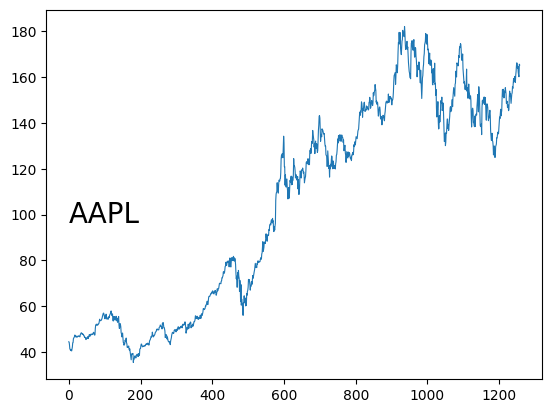

In [116]:
# stock_ma=np.array(dataset_standard[:3])   #MA, 6
# stock_delta=np.array(dataset_standard[:,2])   #change 5
stock_price=np.array(dataset_standard[:,0])   #Price   3
plt.plot(stock_price, linewidth=0.8)
# plt.plot(stock_ma, linewidth=0.8, color='orange')
# plt.plot(stock_delta, linewidth=0.8, color='b', alpha=0.2)
plt.annotate("AAPL",xy=(0,60),textcoords='offset points', fontsize=20)


629


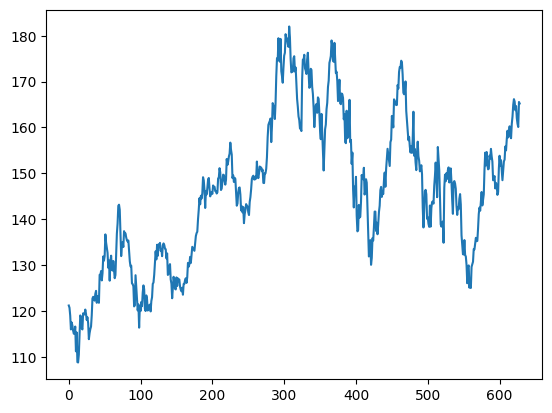

In [117]:
stock.shape
used_length=int(len(stock_price)*0.5)

print(len(stock_price[used_length:]))
stock_price=stock_price[used_length:]
stock=stock[used_length:]
plt.plot(stock_price)

In [118]:
stock.shape

(629, 3)

In [90]:
# transformer_pred = np.array(pd.read_csv("AAPL_pred.csv" ))[:,-1]
# transformer_pred = transformer_pred[used_length:]
# transformer_pred.shape


(629,)

In [119]:
TRANSACTION=0.0001
class GameAI:  # the AI go through the stock, look at a window of prices, and try to make actions at each timestep
    def __init__(self, w=CONTEXT):
        self.w = w #window size
        self.reset() 

    def reset(self):
        # restart game, initialize game state
        self.money=1000000 
        self.positions=10000   # shares holding

        self.today=CONTEXT-7    #30, 7
        self.inital_property=self.positions*stock_price[self.today]+self.money  #initial total investment = 10,000 shares + cash

        
        self.window_right=self.w-1   #14
        self.window_left=0 
        
        self.today_price = stock_price[self.today]
        self.window = stock_price[ 0: self.w] #price    0~14
        # self.window1= stock_delta[ 0: self.w] #delta
        self.window_all=stock[ 0: self.w]  #8 features
        
        self.previous_reward=0  #to store and plot the mean reward during each game to see if improves
        self.yesterday_property= self.inital_property
        self.profit=0 
        

        # self.actions=np.zeros((CONTEXT))
        self.money_record=[self.money]*CONTEXT
        self.positions_record=[self.money]*CONTEXT

        self.money_window=self.money_record[-CONTEXT:]
        self.positions_window=self.positions_record[-CONTEXT:]
        
    def play_step(self, action):
        self.yesterday_property=(self.money + self.today_price*self.positions )

        # 2. make a move, compute money, update positions
        self.money=self.money - self.today_price * action
         #update positions
        self.positions += action     #shares in hand

        self.money_record.append(self.money)
        self.positions_record.append(self.positions)

        self.today += 1  # update the head and window
        self.today_price=stock_price[self.today] 
        #move window forward
        self.window_left += 1 
        self.window_right += 1 
        self.window=stock_price[self.window_left:self.window_right+1]       #price
        # self.window1=stock_delta[self.window_left:self.window_right+1]      #delta
        self.window_all=stock[self.window_left:self.window_right+1]         #9 features

        self.left_mean =  np.mean( stock_price[self.window_left:self.today]  )
        self.right_mean =  np.mean( stock_price[self.today:self.window_right]  )

        # self.left_mean_delta =  np.mean( stock_delta[self.today-5:self.today]  )
        # self.right_mean_delta =  np.mean( stock_delta[self.today:self.today+5]  )

        # self.action_window
        
        self.money_window=self.money_record[-CONTEXT:]
        self.positions_window=self.positions_record[-CONTEXT:]


        # 3. check if game over
        game_over = False

        if self.is_collision():
            
            game_over = True
            reward= (self.money + self.today_price*self.positions ) - self.yesterday_property      -  abs(action)*TRANSACTION
            reward/=100
            reward=reward+ 1.*(self.right_mean-self.left_mean)*action 
            #calculate profit at the end of each game
            self.profit= ((self.money + self.today_price*self.positions )-self.inital_property) /self.inital_property  #profitability at the end of each game
            
            return reward, game_over

        #the reward function will be defined as the difference between the portfolio value 
        #at the end of the time step and the portfolio value at the beginning of the time step.

        reward= (self.money + self.today_price*self.positions ) - self.yesterday_property            -  abs(action)*TRANSACTION
        # print("daily",reward)
        reward/=100
        
        # print("curriculum",0.1*(self.right_mean-self.left_mean)*action + 10*(self.right_mean_delta-self.left_mean_delta)*action)
        reward=reward+1.*(self.right_mean-self.left_mean)*action 
                #curriculum1: if right mean > left mean, and you buy today, then reward the agent, vice versa for sell
                

        return reward, game_over


    def is_collision(self):
        # hits boundary 
        if self.window_right==len(stock_price)-2:
            return 1
        return 0


In [120]:
STATE_SIZE=2+ stock.shape[-1] #prices in window + position and money in hand
print("State size:", STATE_SIZE)
ACTION_SPACE=np.arange(-5000,5001,500).tolist()    #actions
ACTION_SIZE=len(ACTION_SPACE)
print("Action_size:", ACTION_SIZE)
print("Action_space:", ACTION_SPACE)

State size: 5
Action_size: 21
Action_space: [-5000, -4500, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, 0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]


In [121]:
MAX_MEMORY = 5000 # record 5000 state, action, reward, next_state, done tuples
BATCH_SIZE = 128
criterion = nn.SmoothL1Loss()
LR = 0.001
GAMMA=0.995
TAU=0.5
Q_UPDATE_FREQ=20
#Qnet for a given state action pair gives value
class QNetwork(nn.Module):
    def __init__(self, state_size=STATE_SIZE, action_size=ACTION_SIZE, hidden_size=256):
        super(QNetwork, self).__init__()
        self.embedding=nn.Sequential(
        nn.Conv1d(state_size, hidden_size, kernel_size=3, stride=1, padding=1, bias=False ),
        nn.GELU(),
        nn.BatchNorm1d(hidden_size),

        nn.Conv1d(hidden_size, hidden_size, kernel_size=3, stride=1, padding=1, bias=False ),
        nn.BatchNorm1d(hidden_size),
        )

        self.fc=nn.Sequential(
            
        nn.Linear(hidden_size, hidden_size),
        nn.GELU(),
        nn.Linear(hidden_size, hidden_size),
        nn.GELU(),
        nn.Linear(hidden_size, hidden_size),
        nn.GELU()
        )
        self.Linear_out=nn.Linear(hidden_size * CONTEXT, action_size)
    def forward(self, x):

        out=self.embedding(torch.transpose(x,1,2))
        out=self.fc(torch.transpose(out,1,2))
        # print("out", out.flatten(1).shape)
        out=self.Linear_out(    out.flatten(1)   )
        return out

class DoubleDQN:
    def __init__(self, state_size=STATE_SIZE, action_size=ACTION_SIZE, hidden_size=256, lr=LR, tau=TAU,
                 q_update_freq=Q_UPDATE_FREQ, 
                 ):
        self.q_net = QNetwork(state_size, action_size, hidden_size)
        self.target_q_net = QNetwork(state_size, action_size, hidden_size)
        self.target_q_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.tau = tau
        self.total_steps=0
        self.q_update_freq=q_update_freq

    def soft_update(self):
        if self.total_steps % self.q_update_freq==0:
          for target_param, param in zip(self.target_q_net.parameters(), self.q_net.parameters()):
              target_param.data.copy_(self.tau * param.data + (1-self.tau) * target_param.data)

    def train_step(self, state, action, reward, next_state, done):
      self.total_steps += 1

      states_tensor = torch.FloatTensor(state)  #b * state_size 
      actions_tensor = torch.LongTensor(action)  #b 
      rewards_tensor = torch.FloatTensor(reward) #b 
      next_states_tensor = torch.FloatTensor(next_state)  #b * state_size 
      dones_tensor = torch.BoolTensor(done)  #b

      with torch.no_grad():
        q_next=self.target_q_net(next_states_tensor)
        max_q_next,_ = torch.max(q_next, dim=1)
        q_target = rewards_tensor + GAMMA * max_q_next * (~dones_tensor)

      q_pred = self.q_net(states_tensor)
      actions_index=[]
      for b in range(BATCH_SIZE):
        #print(actions_tensor[b])
        actions_index.append(ACTION_SPACE.index(actions_tensor[b]))
      actions_index=torch.tensor(actions_index, dtype=torch.int64)

      q_values_pred_selected = q_pred.gather(1, actions_index.unsqueeze(1)).squeeze(1)

      loss = criterion(q_values_pred_selected, q_target) /(BATCH_SIZE*1e+3 )

      self.optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), 1e+8)
      self.optimizer.step()

      self.soft_update()

      return loss.item()

In [122]:
class Agent:
    def __init__(self):
        self.n_games = 0
        self.trainer = DoubleDQN() 
        self.memory = deque(maxlen=MAX_MEMORY) # a collection of past experiences 

    def get_state(self, game):

        window_all=np.array(game.window_all )
        money_window=(np.array(game.money_window)/10000).reshape(-1,1)   #your money
        positions_window=(np.array(game.positions_window)/100).reshape(-1,1)

        assert(game.money>=0.0)
        assert(game.positions>=0.0)

        state= np.concatenate( [positions_window, money_window, window_all], axis=-1  ) #state

        return state

    def remember(self, state, action, reward, next_state, done):
        #state=(state- np.mean(state,axis=0))/np.std(state,axis=0) #normalize
        # reward/=100
        self.memory.append((state, action, reward, next_state, done)) # popleft if MAX_MEMORY is reached

    # def train_single_experience(self, states, actions, rewards, next_states, dones):
    #     loss=self.trainer.train_step(states, actions, rewards, next_states, dones)
    #     return loss
        
    def train_batch_experience(self):

        if len(self.memory) >= BATCH_SIZE:
            batch_sample = random.sample(self.memory, BATCH_SIZE)  # list of tuples
            #pass in batch to train
            states, actions, rewards, next_states, dones = zip(*batch_sample)
            # print("states", states.shape)
            loss=self.trainer.train_step(states, actions, rewards, next_states, dones)
            return loss
            
    def get_action(self, state, game):    # e p s i l o n greedy---------------------------------------------------------------------------------
        #80% possibility of taking random action. decrease in time
        self.epsilon = 90 - self.n_games//20   #20 games reduce 1% chance of choosing action other than the best action
        if self.epsilon<5:
          self.epsilon=5 #not allowing below 5%  randomness
        position=game.positions
        money=game.money

        today_price=game.today_price

        final_move=0.
        #explore random actions
        if random.randint(0, 100) < max(self.epsilon,0) or (len(self.memory) <= BATCH_SIZE):
            actions=np.array(ACTION_SPACE)
            final_move=np.random.choice(actions)  
            #cannot buy more than the money you have, find closest value in the action space
            if final_move>0 and final_move*today_price >= money:
              for a in reversed(ACTION_SPACE): # find action that doesn't use up all your money in action space
                if a>=0 and a*today_price < money:
                  return a
              
            if final_move<0 and final_move<-position:    
              for a in ACTION_SPACE:  #find action that doesn't sell all your shares in action space
                if a<=0 and a+position>=0:
                  return a

        #take max q action
        else:
            state_input = torch.tensor(state, dtype=torch.float).unsqueeze(0)
            # print("QpredstateL",state_input.shape)
            Q_pred= self.trainer.q_net(state_input)
            move = torch.argmax(Q_pred).item() # 
            #allowable=np.clip(move, -position, money//today_price)    
            final_move=ACTION_SPACE[move]
            
            #cannot buy more than the money you have, find closest value in the action space
            if final_move>0 and final_move*today_price > money:
              for a in reversed(ACTION_SPACE):
                if a>=0 and a*today_price< money: #find action that doesn't use up all your money in action space
                  # print("action", a, today_price, money)
                  return a
            
            if final_move<0 and final_move<-position:   
              for a in ACTION_SPACE: #find action that doesn't sell all your shares in action space
                if a<=0 and a+position>=0:
                  return a

        if final_move>0 and final_move*today_price >= money:
          # print("action", a, today_price, money)
          return 0.
        if final_move<0 and final_move<-position:
          return 0.

        return final_move

actions=[]
plot_profit=[]
plot_reward=[]
plot_loss=[]
agent = Agent()
def train():
    rewards = []
    record = 0
    game = GameAI()
    epoch=1000000 #a very large number just to keep the game running
    optimizer=agent.trainer.optimizer
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=stock_price.shape[0]*3, gamma=0.99)
    for i in tqdm( range(1,epoch+1) ):
        
        curr_lr = float(optimizer.param_groups[0]['lr'])
        state_old = agent.get_state(game)
        action = agent.get_action(state_old, game)
        actions.append(action)
        
        reward, done= game.play_step(action)
#--------------------------------------------------------------------------------------------------------------------
        state_new = agent.get_state(game)
        # memory stored for replay
        agent.remember(state_old, action, reward, state_new, done)
        #loss=agent.train_single_experience(state_old, action, reward, state_new, done)

          
        rewards.append(reward)
        profit=game.profit

        if done:
            mean_reward=np.mean(rewards)
            plot_reward.append(mean_reward)
            rewards=[]
            # train minibatch
            loss=agent.train_batch_experience()
            plot_loss.append(loss)
            game.reset()
            agent.n_games += 1
            
            if profit > record:
                record = profit
               # agent.model.save()

            print('Game', agent.n_games,"mean Reward", round(mean_reward,2), 'Profit', round(profit*100,2) ,'Record:', round(record*100,2), "eps",agent.epsilon,"lr",round(curr_lr,6), "loss", round(loss,6))

            plot_profit.append(profit)
        scheduler.step()


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# PATH = "/content/drive/MyDrive/checkpoint01"
# torch.save(agent.trainer.q_net.state_dict(), PATH)

In [123]:
gc.collect()
torch.cuda.empty_cache()

In [124]:
train()
#profit is the percentage of cumulated money through the money over money that I had in hand before the game
#mean reward is the average daily dollar returns in each game

  0%|          | 0/1000000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  0%|          | 1170/1000000 [00:00<10:36, 1570.27it/s]

Game 1 mean Reward -874.95 Profit 71.28 Record: 71.28 eps 90 lr 0.001 loss 0.121291


  0%|          | 1442/1000000 [00:01<17:00, 978.71it/s] 

Game 2 mean Reward 520.02 Profit 37.92 Record: 71.28 eps 90 lr 0.001 loss 0.130343


  0%|          | 2230/1000000 [00:01<14:44, 1128.33it/s]

Game 3 mean Reward 23.27 Profit 22.87 Record: 71.28 eps 90 lr 0.001 loss 0.103997


  0%|          | 2752/1000000 [00:02<15:23, 1079.46it/s]

Game 4 mean Reward -645.31 Profit 22.5 Record: 71.28 eps 90 lr 0.00099 loss 0.11488


  0%|          | 3230/1000000 [00:03<16:25, 1011.86it/s]

Game 5 mean Reward 288.87 Profit 3.05 Record: 71.28 eps 90 lr 0.00099 loss 0.106191


  0%|          | 4110/1000000 [00:03<13:31, 1227.44it/s]

Game 6 mean Reward 858.9 Profit 26.84 Record: 71.28 eps 90 lr 0.00099 loss 0.102109


  0%|          | 4656/1000000 [00:04<14:24, 1150.88it/s]

Game 7 mean Reward -367.91 Profit 22.91 Record: 71.28 eps 90 lr 0.00098 loss 0.102104


  1%|          | 5143/1000000 [00:04<15:18, 1082.71it/s]

Game 8 mean Reward -76.43 Profit 25.32 Record: 71.28 eps 90 lr 0.00098 loss 0.112977


  1%|          | 5655/1000000 [00:05<15:36, 1061.34it/s]

Game 9 mean Reward 610.38 Profit 11.28 Record: 71.28 eps 90 lr 0.00098 loss 0.115644


  1%|          | 6251/1000000 [00:06<14:54, 1110.52it/s]

Game 10 mean Reward 384.19 Profit -6.18 Record: 71.28 eps 90 lr 0.00097 loss 0.106814


  1%|          | 6963/1000000 [00:06<19:15, 859.49it/s]

Game 11 mean Reward -1410.89 Profit 47.96 Record: 71.28 eps 90 lr 0.00097 loss 0.113656


  1%|          | 7495/1000000 [00:07<24:45, 668.35it/s]

Game 12 mean Reward 288.43 Profit 28.33 Record: 71.28 eps 90 lr 0.00097 loss 0.109542


  1%|          | 8068/1000000 [00:08<25:49, 640.06it/s]

Game 13 mean Reward -1403.37 Profit 23.98 Record: 71.28 eps 90 lr 0.000961 loss 0.09992


  1%|          | 8674/1000000 [00:09<25:14, 654.72it/s]

Game 14 mean Reward -306.75 Profit 43.33 Record: 71.28 eps 90 lr 0.000961 loss 0.09393


  1%|          | 9273/1000000 [00:10<21:32, 766.31it/s]

Game 15 mean Reward 673.15 Profit -2.43 Record: 71.28 eps 90 lr 0.000961 loss 0.115316


  1%|          | 9854/1000000 [00:11<17:17, 954.45it/s]

Game 16 mean Reward -340.4 Profit 21.0 Record: 71.28 eps 90 lr 0.000951 loss 0.131217


  1%|          | 10656/1000000 [00:11<14:20, 1149.78it/s]

Game 17 mean Reward -518.2 Profit 7.44 Record: 71.28 eps 90 lr 0.000951 loss 0.080573


  1%|          | 11200/1000000 [00:12<14:13, 1158.63it/s]

Game 18 mean Reward 993.55 Profit 8.71 Record: 71.28 eps 90 lr 0.000951 loss 0.108762


  1%|          | 11756/1000000 [00:12<14:13, 1157.59it/s]

Game 19 mean Reward 242.5 Profit 44.18 Record: 71.28 eps 90 lr 0.000941 loss 0.10637


  1%|          | 12204/1000000 [00:13<16:27, 1000.64it/s]

Game 20 mean Reward -366.88 Profit 36.0 Record: 71.28 eps 90 lr 0.000941 loss 0.113387


  1%|▏         | 13043/1000000 [00:14<13:52, 1185.20it/s]

Game 21 mean Reward -31.63 Profit 43.3 Record: 71.28 eps 89 lr 0.000941 loss 0.100445


  1%|▏         | 13541/1000000 [00:14<15:01, 1093.70it/s]

Game 22 mean Reward 30.54 Profit 13.97 Record: 71.28 eps 89 lr 0.000941 loss 0.108547


  1%|▏         | 13970/1000000 [00:15<16:46, 979.23it/s]

Game 23 mean Reward -112.81 Profit 18.39 Record: 71.28 eps 89 lr 0.000932 loss 0.100575


  1%|▏         | 14795/1000000 [00:15<14:01, 1170.46it/s]

Game 24 mean Reward -416.1 Profit 5.47 Record: 71.28 eps 89 lr 0.000932 loss 0.096686


  2%|▏         | 15245/1000000 [00:16<15:27, 1061.25it/s]

Game 25 mean Reward 1097.64 Profit 8.01 Record: 71.28 eps 89 lr 0.000932 loss 0.095732


  2%|▏         | 16026/1000000 [00:17<13:57, 1175.50it/s]

Game 26 mean Reward -769.44 Profit 26.6 Record: 71.28 eps 89 lr 0.000923 loss 0.104946


  2%|▏         | 16520/1000000 [00:17<14:58, 1094.75it/s]

Game 27 mean Reward -354.13 Profit 35.49 Record: 71.28 eps 89 lr 0.000923 loss 0.102361


  2%|▏         | 16983/1000000 [00:18<16:08, 1014.55it/s]

Game 28 mean Reward -634.57 Profit 33.74 Record: 71.28 eps 89 lr 0.000923 loss 0.09809


  2%|▏         | 17711/1000000 [00:18<14:34, 1122.77it/s]

Game 29 mean Reward 140.26 Profit 23.03 Record: 71.28 eps 89 lr 0.000914 loss 0.118951


  2%|▏         | 18204/1000000 [00:19<15:48, 1035.64it/s]

Game 30 mean Reward 83.3 Profit 1.36 Record: 71.28 eps 89 lr 0.000914 loss 0.095301


  2%|▏         | 19022/1000000 [00:20<13:27, 1214.71it/s]

Game 31 mean Reward 527.21 Profit 37.41 Record: 71.28 eps 89 lr 0.000914 loss 0.113916


  2%|▏         | 19431/1000000 [00:20<19:31, 836.72it/s]

Game 32 mean Reward -56.98 Profit -1.16 Record: 71.28 eps 89 lr 0.000904 loss 0.109411


  2%|▏         | 19988/1000000 [00:21<23:31, 694.48it/s]

Game 33 mean Reward 889.49 Profit -19.35 Record: 71.28 eps 89 lr 0.000904 loss 0.125198


  2%|▏         | 20505/1000000 [00:22<26:46, 609.75it/s]

Game 34 mean Reward -689.67 Profit 13.93 Record: 71.28 eps 89 lr 0.000904 loss 0.112088


  2%|▏         | 21238/1000000 [00:23<25:38, 636.26it/s]

Game 35 mean Reward -822.14 Profit 13.63 Record: 71.28 eps 89 lr 0.000895 loss 0.103651


  2%|▏         | 21809/1000000 [00:24<23:08, 704.51it/s]

Game 36 mean Reward 346.89 Profit 27.33 Record: 71.28 eps 89 lr 0.000895 loss 0.102451


  2%|▏         | 22533/1000000 [00:25<16:10, 1006.73it/s]

Game 37 mean Reward -493.82 Profit 51.05 Record: 71.28 eps 89 lr 0.000895 loss 0.106279


  2%|▏         | 22977/1000000 [00:25<16:45, 971.63it/s]

Game 38 mean Reward -963.08 Profit 39.16 Record: 71.28 eps 89 lr 0.000886 loss 0.104191


  2%|▏         | 23697/1000000 [00:26<15:30, 1049.52it/s]

Game 39 mean Reward 712.18 Profit 22.68 Record: 71.28 eps 89 lr 0.000886 loss 0.107851


  2%|▏         | 24138/1000000 [00:27<17:03, 953.43it/s]

Game 40 mean Reward -666.75 Profit 34.27 Record: 71.28 eps 89 lr 0.000886 loss 0.119394


  2%|▏         | 24778/1000000 [00:27<16:30, 984.72it/s]

Game 41 mean Reward 274.22 Profit 40.0 Record: 71.28 eps 88 lr 0.000886 loss 0.104553


  3%|▎         | 25541/1000000 [00:28<14:22, 1129.92it/s]

Game 42 mean Reward 410.93 Profit -2.88 Record: 71.28 eps 88 lr 0.000878 loss 0.121389


  3%|▎         | 26005/1000000 [00:28<15:43, 1031.90it/s]

Game 43 mean Reward 49.4 Profit 30.24 Record: 71.28 eps 88 lr 0.000878 loss 0.114893


  3%|▎         | 26756/1000000 [00:29<14:43, 1101.39it/s]

Game 44 mean Reward 42.12 Profit 0.81 Record: 71.28 eps 88 lr 0.000878 loss 0.113641


  3%|▎         | 27179/1000000 [00:30<16:57, 956.52it/s]

Game 45 mean Reward 497.71 Profit 28.68 Record: 71.28 eps 88 lr 0.000869 loss 0.109867


  3%|▎         | 27969/1000000 [00:30<14:41, 1102.78it/s]

Game 46 mean Reward 14.22 Profit 14.04 Record: 71.28 eps 88 lr 0.000869 loss 0.124737


  3%|▎         | 28439/1000000 [00:31<15:45, 1028.05it/s]

Game 47 mean Reward -1011.43 Profit 41.12 Record: 71.28 eps 88 lr 0.000869 loss 0.111151


  3%|▎         | 29156/1000000 [00:32<14:52, 1087.42it/s]

Game 48 mean Reward -749.66 Profit 20.15 Record: 71.28 eps 88 lr 0.00086 loss 0.103158


  3%|▎         | 29598/1000000 [00:32<16:13, 997.17it/s]

Game 49 mean Reward 786.62 Profit 18.92 Record: 71.28 eps 88 lr 0.00086 loss 0.109424


  3%|▎         | 30270/1000000 [00:33<16:06, 1003.59it/s]

Game 50 mean Reward 602.64 Profit 19.71 Record: 71.28 eps 88 lr 0.00086 loss 0.100159


  3%|▎         | 30714/1000000 [00:33<17:02, 947.69it/s]

Game 51 mean Reward -237.0 Profit 17.91 Record: 71.28 eps 88 lr 0.000851 loss 0.099877


  3%|▎         | 31319/1000000 [00:34<18:47, 859.28it/s]

Game 52 mean Reward -840.09 Profit -2.87 Record: 71.28 eps 88 lr 0.000851 loss 0.103333


  3%|▎         | 31960/1000000 [00:35<24:59, 645.62it/s]

Game 53 mean Reward -113.25 Profit 23.49 Record: 71.28 eps 88 lr 0.000851 loss 0.090468


  3%|▎         | 32525/1000000 [00:36<25:19, 636.82it/s]

Game 54 mean Reward -93.82 Profit 12.41 Record: 71.28 eps 88 lr 0.000843 loss 0.102673


  3%|▎         | 33017/1000000 [00:37<29:03, 554.56it/s]

Game 55 mean Reward -665.44 Profit 24.94 Record: 71.28 eps 88 lr 0.000843 loss 0.10787


  3%|▎         | 33792/1000000 [00:38<22:32, 714.43it/s]

Game 56 mean Reward 624.08 Profit 23.9 Record: 71.28 eps 88 lr 0.000843 loss 0.099536


  3%|▎         | 34515/1000000 [00:39<17:25, 923.23it/s]

Game 57 mean Reward -418.98 Profit 22.3 Record: 71.28 eps 88 lr 0.000835 loss 0.088062


  3%|▎         | 34999/1000000 [00:39<16:31, 973.48it/s]

Game 58 mean Reward -67.05 Profit -12.53 Record: 71.28 eps 88 lr 0.000835 loss 0.0945


  4%|▎         | 35544/1000000 [00:40<15:29, 1037.11it/s]

Game 59 mean Reward -126.79 Profit 29.1 Record: 71.28 eps 88 lr 0.000835 loss 0.115976


  4%|▎         | 36225/1000000 [00:41<14:58, 1072.79it/s]

Game 60 mean Reward -145.43 Profit 24.22 Record: 71.28 eps 88 lr 0.000826 loss 0.098102


  4%|▎         | 36881/1000000 [00:41<15:20, 1046.70it/s]

Game 61 mean Reward 788.62 Profit -1.18 Record: 71.28 eps 87 lr 0.000826 loss 0.115231


  4%|▎         | 37291/1000000 [00:42<17:18, 926.64it/s]

Game 62 mean Reward 513.39 Profit 26.31 Record: 71.28 eps 87 lr 0.000826 loss 0.118322


  4%|▍         | 38026/1000000 [00:42<15:10, 1056.22it/s]

Game 63 mean Reward 472.35 Profit 16.63 Record: 71.28 eps 87 lr 0.000826 loss 0.093416


  4%|▍         | 38500/1000000 [00:43<16:07, 993.92it/s]

Game 64 mean Reward -770.82 Profit 2.08 Record: 71.28 eps 87 lr 0.000818 loss 0.089961


  4%|▍         | 39227/1000000 [00:44<15:12, 1053.06it/s]

Game 65 mean Reward -549.38 Profit 36.9 Record: 71.28 eps 87 lr 0.000818 loss 0.11578


  4%|▍         | 39746/1000000 [00:44<15:15, 1048.81it/s]

Game 66 mean Reward -66.01 Profit 16.82 Record: 71.28 eps 87 lr 0.000818 loss 0.113629


  4%|▍         | 40411/1000000 [00:45<15:40, 1020.09it/s]

Game 67 mean Reward -778.78 Profit 13.74 Record: 71.28 eps 87 lr 0.00081 loss 0.108788


  4%|▍         | 40914/1000000 [00:46<16:22, 975.82it/s]

Game 68 mean Reward 513.79 Profit 3.22 Record: 71.28 eps 87 lr 0.00081 loss 0.108663


  4%|▍         | 41544/1000000 [00:46<17:39, 904.91it/s]

Game 69 mean Reward -14.28 Profit 47.17 Record: 71.28 eps 87 lr 0.00081 loss 0.102797


  4%|▍         | 42058/1000000 [00:47<24:09, 660.86it/s]

Game 70 mean Reward 426.57 Profit 35.8 Record: 71.28 eps 87 lr 0.000802 loss 0.1011


  4%|▍         | 42682/1000000 [00:48<27:28, 580.57it/s]

Game 71 mean Reward 308.58 Profit 12.39 Record: 71.28 eps 87 lr 0.000802 loss 0.117575


  4%|▍         | 43209/1000000 [00:49<34:24, 463.49it/s]

Game 72 mean Reward 208.17 Profit 7.51 Record: 71.28 eps 87 lr 0.000802 loss 0.108849


  4%|▍         | 43923/1000000 [00:51<30:32, 521.65it/s]

Game 73 mean Reward 75.88 Profit 43.44 Record: 71.28 eps 87 lr 0.000794 loss 0.09115


  4%|▍         | 44482/1000000 [00:52<32:50, 484.87it/s]

Game 74 mean Reward 775.04 Profit 15.6 Record: 71.28 eps 87 lr 0.000794 loss 0.110281


  5%|▍         | 45052/1000000 [00:53<29:53, 532.55it/s]

Game 75 mean Reward -441.5 Profit 20.99 Record: 71.28 eps 87 lr 0.000794 loss 0.133776


  5%|▍         | 45699/1000000 [00:54<28:14, 563.17it/s]

Game 76 mean Reward -103.62 Profit 20.27 Record: 71.28 eps 87 lr 0.000786 loss 0.118767


  5%|▍         | 46265/1000000 [00:54<20:28, 776.43it/s]

Game 77 mean Reward -430.84 Profit 58.11 Record: 71.28 eps 87 lr 0.000786 loss 0.103816


  5%|▍         | 46966/1000000 [00:55<15:53, 999.43it/s]

Game 78 mean Reward -100.62 Profit 47.59 Record: 71.28 eps 87 lr 0.000786 loss 0.105691


  5%|▍         | 47517/1000000 [00:56<17:55, 886.00it/s]

Game 79 mean Reward 593.5 Profit -13.3 Record: 71.28 eps 87 lr 0.000778 loss 0.121366


  5%|▍         | 48174/1000000 [00:56<16:33, 958.21it/s]

Game 80 mean Reward 556.57 Profit 5.22 Record: 71.28 eps 87 lr 0.000778 loss 0.119818


  5%|▍         | 48667/1000000 [00:57<16:36, 954.49it/s]

Game 81 mean Reward 338.74 Profit 32.48 Record: 71.28 eps 86 lr 0.000778 loss 0.120549


  5%|▍         | 49375/1000000 [00:58<15:02, 1053.54it/s]

Game 82 mean Reward -172.06 Profit 31.79 Record: 71.28 eps 86 lr 0.000778 loss 0.109331


  5%|▌         | 50024/1000000 [00:58<15:32, 1018.69it/s]

Game 83 mean Reward 69.07 Profit 26.68 Record: 71.28 eps 86 lr 0.00077 loss 0.105767


  5%|▌         | 50448/1000000 [00:59<17:21, 911.42it/s]

Game 84 mean Reward 194.6 Profit 30.99 Record: 71.28 eps 86 lr 0.00077 loss 0.115852


  5%|▌         | 50873/1000000 [01:00<29:11, 541.91it/s] 

Game 85 mean Reward -831.24 Profit 32.97 Record: 71.28 eps 86 lr 0.00077 loss 0.103447


  5%|▌         | 51540/1000000 [01:01<30:08, 524.54it/s]

Game 86 mean Reward 72.36 Profit 0.15 Record: 71.28 eps 86 lr 0.000762 loss 0.098873


  5%|▌         | 52125/1000000 [01:02<28:05, 562.32it/s]

Game 87 mean Reward 218.28 Profit 20.4 Record: 71.28 eps 86 lr 0.000762 loss 0.099289


  5%|▌         | 52963/1000000 [01:03<18:33, 850.50it/s]

Game 88 mean Reward -380.82 Profit 36.14 Record: 71.28 eps 86 lr 0.000762 loss 0.124067


  5%|▌         | 53457/1000000 [01:04<17:19, 910.58it/s]

Game 89 mean Reward -465.28 Profit 82.82 Record: 82.82 eps 86 lr 0.000755 loss 0.11541


  5%|▌         | 53983/1000000 [01:05<23:41, 665.58it/s]

Game 90 mean Reward -182.62 Profit 28.7 Record: 82.82 eps 86 lr 0.000755 loss 0.102305


  5%|▌         | 54618/1000000 [01:06<26:24, 596.75it/s]

Game 91 mean Reward 207.26 Profit 12.9 Record: 82.82 eps 86 lr 0.000755 loss 0.126016


  6%|▌         | 55253/1000000 [01:07<26:50, 586.79it/s]

Game 92 mean Reward -298.5 Profit 23.4 Record: 82.82 eps 86 lr 0.000747 loss 0.115198


  6%|▌         | 55865/1000000 [01:08<28:11, 558.02it/s]

Game 93 mean Reward -623.87 Profit 36.65 Record: 82.82 eps 86 lr 0.000747 loss 0.101755


  6%|▌         | 56516/1000000 [01:08<20:16, 775.74it/s]

Game 94 mean Reward -382.86 Profit 43.02 Record: 82.82 eps 86 lr 0.000747 loss 0.115457


  6%|▌         | 57153/1000000 [01:09<17:15, 910.46it/s]

Game 95 mean Reward -1245.86 Profit 59.35 Record: 82.82 eps 86 lr 0.00074 loss 0.091505


  6%|▌         | 57754/1000000 [01:10<16:53, 929.30it/s]

Game 96 mean Reward -771.14 Profit -1.38 Record: 82.82 eps 86 lr 0.00074 loss 0.11278


  6%|▌         | 58364/1000000 [01:10<16:39, 942.31it/s]

Game 97 mean Reward -596.56 Profit 6.62 Record: 82.82 eps 86 lr 0.00074 loss 0.110594


  6%|▌         | 59049/1000000 [01:11<14:38, 1071.57it/s]

Game 98 mean Reward -206.27 Profit 36.85 Record: 82.82 eps 86 lr 0.000732 loss 0.096754


  6%|▌         | 59474/1000000 [01:12<16:01, 978.46it/s]

Game 99 mean Reward 439.77 Profit 10.99 Record: 82.82 eps 86 lr 0.000732 loss 0.108586


  6%|▌         | 60055/1000000 [01:12<16:41, 938.62it/s]

Game 100 mean Reward 479.23 Profit 28.84 Record: 82.82 eps 86 lr 0.000732 loss 0.134551


  6%|▌         | 60742/1000000 [01:13<15:33, 1005.87it/s]

Game 101 mean Reward 1.7 Profit 52.22 Record: 82.82 eps 85 lr 0.000725 loss 0.108021


  6%|▌         | 61427/1000000 [01:14<15:10, 1030.75it/s]

Game 102 mean Reward -684.13 Profit 54.25 Record: 82.82 eps 85 lr 0.000725 loss 0.114684


  6%|▌         | 61887/1000000 [01:14<15:56, 980.32it/s]

Game 103 mean Reward -30.91 Profit 52.91 Record: 82.82 eps 85 lr 0.000725 loss 0.112149


  6%|▋         | 62598/1000000 [01:15<15:11, 1027.93it/s]

Game 104 mean Reward -369.2 Profit 17.09 Record: 82.82 eps 85 lr 0.000725 loss 0.106436


  6%|▋         | 62984/1000000 [01:16<17:26, 895.03it/s]

Game 105 mean Reward -388.87 Profit 26.06 Record: 82.82 eps 85 lr 0.000718 loss 0.119936


  6%|▋         | 63690/1000000 [01:16<15:40, 995.49it/s]

Game 106 mean Reward 365.68 Profit 23.82 Record: 82.82 eps 85 lr 0.000718 loss 0.116301


  6%|▋         | 64283/1000000 [01:17<16:52, 924.42it/s]

Game 107 mean Reward -411.55 Profit 25.24 Record: 82.82 eps 85 lr 0.000718 loss 0.116879


  6%|▋         | 64949/1000000 [01:18<15:14, 1022.48it/s]

Game 108 mean Reward 84.19 Profit -6.09 Record: 82.82 eps 85 lr 0.000711 loss 0.108749


  7%|▋         | 65318/1000000 [01:18<19:57, 780.51it/s]

Game 109 mean Reward -101.95 Profit 6.38 Record: 82.82 eps 85 lr 0.000711 loss 0.114248


  7%|▋         | 66005/1000000 [01:19<27:14, 571.59it/s]

Game 110 mean Reward 232.36 Profit 30.4 Record: 82.82 eps 85 lr 0.000711 loss 0.132422


  7%|▋         | 66521/1000000 [01:20<31:23, 495.71it/s]

Game 111 mean Reward 235.76 Profit 16.69 Record: 82.82 eps 85 lr 0.000703 loss 0.132223


  7%|▋         | 67139/1000000 [01:21<27:52, 557.78it/s]

Game 112 mean Reward 532.35 Profit 12.11 Record: 82.82 eps 85 lr 0.000703 loss 0.106017


  7%|▋         | 67919/1000000 [01:22<20:48, 746.69it/s]

Game 113 mean Reward 217.42 Profit 25.83 Record: 82.82 eps 85 lr 0.000703 loss 0.137291


  7%|▋         | 68547/1000000 [01:23<17:40, 878.13it/s]

Game 114 mean Reward -493.99 Profit 24.64 Record: 82.82 eps 85 lr 0.000696 loss 0.098261


  7%|▋         | 69145/1000000 [01:24<17:22, 892.54it/s]

Game 115 mean Reward -167.78 Profit 24.89 Record: 82.82 eps 85 lr 0.000696 loss 0.096488


  7%|▋         | 69758/1000000 [01:24<16:24, 944.45it/s]

Game 116 mean Reward 727.62 Profit 25.12 Record: 82.82 eps 85 lr 0.000696 loss 0.106187


  7%|▋         | 70394/1000000 [01:25<15:39, 989.27it/s]

Game 117 mean Reward -1411.69 Profit 45.48 Record: 82.82 eps 85 lr 0.000689 loss 0.103607


  7%|▋         | 70794/1000000 [01:26<17:09, 902.29it/s]

Game 118 mean Reward 88.48 Profit 17.56 Record: 82.82 eps 85 lr 0.000689 loss 0.116392


  7%|▋         | 71368/1000000 [01:26<17:44, 872.02it/s]

Game 119 mean Reward 296.82 Profit 2.84 Record: 82.82 eps 85 lr 0.000689 loss 0.111829


  7%|▋         | 71987/1000000 [01:27<16:37, 930.30it/s]

Game 120 mean Reward 411.01 Profit 14.35 Record: 82.82 eps 85 lr 0.000683 loss 0.094825


  7%|▋         | 72580/1000000 [01:28<17:55, 862.57it/s]

Game 121 mean Reward 163.69 Profit 34.62 Record: 82.82 eps 84 lr 0.000683 loss 0.125345


  7%|▋         | 73159/1000000 [01:28<17:31, 881.76it/s]

Game 122 mean Reward -537.04 Profit 17.75 Record: 82.82 eps 84 lr 0.000683 loss 0.111696


  7%|▋         | 73775/1000000 [01:29<16:48, 918.61it/s]

Game 123 mean Reward -548.42 Profit 25.89 Record: 82.82 eps 84 lr 0.000683 loss 0.132149


  7%|▋         | 74370/1000000 [01:30<17:08, 899.70it/s]

Game 124 mean Reward 483.52 Profit 18.26 Record: 82.82 eps 84 lr 0.000676 loss 0.090356


  7%|▋         | 74996/1000000 [01:30<16:10, 953.55it/s]

Game 125 mean Reward 166.1 Profit 33.6 Record: 82.82 eps 84 lr 0.000676 loss 0.09983


  8%|▊         | 75607/1000000 [01:31<16:12, 950.50it/s]

Game 126 mean Reward -232.17 Profit 40.46 Record: 82.82 eps 84 lr 0.000676 loss 0.082496


  8%|▊         | 76232/1000000 [01:32<16:04, 957.50it/s]

Game 127 mean Reward -646.44 Profit 25.35 Record: 82.82 eps 84 lr 0.000669 loss 0.102123


  8%|▊         | 76763/1000000 [01:33<21:18, 722.04it/s]

Game 128 mean Reward -692.11 Profit 30.65 Record: 82.82 eps 84 lr 0.000669 loss 0.108679


  8%|▊         | 77466/1000000 [01:34<23:30, 654.01it/s]

Game 129 mean Reward 487.19 Profit -1.1 Record: 82.82 eps 84 lr 0.000669 loss 0.100249


  8%|▊         | 77870/1000000 [01:35<30:17, 507.32it/s]

Game 130 mean Reward 182.52 Profit 11.26 Record: 82.82 eps 84 lr 0.000662 loss 0.11605


  8%|▊         | 78568/1000000 [01:36<28:51, 532.10it/s]

Game 131 mean Reward 78.87 Profit 19.46 Record: 82.82 eps 84 lr 0.000662 loss 0.108096


  8%|▊         | 79189/1000000 [01:37<22:04, 695.36it/s]

Game 132 mean Reward -150.67 Profit 23.29 Record: 82.82 eps 84 lr 0.000662 loss 0.103433


  8%|▊         | 79772/1000000 [01:37<18:08, 845.30it/s]

Game 133 mean Reward 327.56 Profit 28.9 Record: 82.82 eps 84 lr 0.000656 loss 0.106785


  8%|▊         | 80438/1000000 [01:38<15:52, 965.16it/s]

Game 134 mean Reward -251.08 Profit 20.83 Record: 82.82 eps 84 lr 0.000656 loss 0.118715


  8%|▊         | 81052/1000000 [01:39<15:56, 960.46it/s]

Game 135 mean Reward -664.25 Profit 24.23 Record: 82.82 eps 84 lr 0.000656 loss 0.120284


  8%|▊         | 81629/1000000 [01:39<16:46, 912.37it/s]

Game 136 mean Reward 445.95 Profit 16.36 Record: 82.82 eps 84 lr 0.000649 loss 0.09987


  8%|▊         | 82255/1000000 [01:40<15:45, 970.46it/s]

Game 137 mean Reward -214.63 Profit 8.92 Record: 82.82 eps 84 lr 0.000649 loss 0.130638


  8%|▊         | 82829/1000000 [01:41<16:31, 924.74it/s]

Game 138 mean Reward -407.34 Profit 17.06 Record: 82.82 eps 84 lr 0.000649 loss 0.109698


  8%|▊         | 83399/1000000 [01:41<16:35, 920.80it/s]

Game 139 mean Reward -379.62 Profit 53.79 Record: 82.82 eps 84 lr 0.000643 loss 0.117491


  8%|▊         | 84039/1000000 [01:42<16:01, 952.74it/s]

Game 140 mean Reward -154.64 Profit 39.85 Record: 82.82 eps 84 lr 0.000643 loss 0.106435


  8%|▊         | 84653/1000000 [01:43<16:20, 933.86it/s]

Game 141 mean Reward -288.59 Profit 43.51 Record: 82.82 eps 83 lr 0.000643 loss 0.098612


  9%|▊         | 85226/1000000 [01:43<17:30, 870.64it/s]

Game 142 mean Reward 983.06 Profit 12.07 Record: 82.82 eps 83 lr 0.000636 loss 0.121623


  9%|▊         | 85813/1000000 [01:44<17:01, 894.95it/s]

Game 143 mean Reward 675.71 Profit 28.33 Record: 82.82 eps 83 lr 0.000636 loss 0.10246


  9%|▊         | 86418/1000000 [01:45<16:55, 899.78it/s]

Game 144 mean Reward -675.73 Profit 28.02 Record: 82.82 eps 83 lr 0.000636 loss 0.091563


  9%|▊         | 87017/1000000 [01:45<16:20, 931.24it/s]

Game 145 mean Reward 311.07 Profit 39.55 Record: 82.82 eps 83 lr 0.000636 loss 0.101862


  9%|▉         | 87635/1000000 [01:46<16:24, 926.30it/s]

Game 146 mean Reward 448.19 Profit 16.23 Record: 82.82 eps 83 lr 0.00063 loss 0.111739


  9%|▉         | 88152/1000000 [01:47<23:00, 660.61it/s]

Game 147 mean Reward 214.24 Profit 16.99 Record: 82.82 eps 83 lr 0.00063 loss 0.127052


  9%|▉         | 88680/1000000 [01:48<28:51, 526.23it/s]

Game 148 mean Reward -134.35 Profit 15.14 Record: 82.82 eps 83 lr 0.00063 loss 0.101528


  9%|▉         | 89236/1000000 [01:49<29:54, 507.57it/s]

Game 149 mean Reward 468.69 Profit 21.15 Record: 82.82 eps 83 lr 0.000624 loss 0.105476


  9%|▉         | 89896/1000000 [01:50<30:33, 496.41it/s]

Game 150 mean Reward -622.8 Profit 28.2 Record: 82.82 eps 83 lr 0.000624 loss 0.121589


  9%|▉         | 90595/1000000 [01:51<18:42, 810.35it/s]

Game 151 mean Reward 497.31 Profit 31.04 Record: 82.82 eps 83 lr 0.000624 loss 0.128064


  9%|▉         | 91240/1000000 [01:52<15:58, 947.81it/s]

Game 152 mean Reward -924.3 Profit 13.77 Record: 82.82 eps 83 lr 0.000617 loss 0.102445


  9%|▉         | 91836/1000000 [01:52<16:17, 929.02it/s]

Game 153 mean Reward 107.3 Profit 10.15 Record: 82.82 eps 83 lr 0.000617 loss 0.111968


  9%|▉         | 92462/1000000 [01:53<16:01, 943.43it/s]

Game 154 mean Reward 62.88 Profit 38.54 Record: 82.82 eps 83 lr 0.000617 loss 0.097048


  9%|▉         | 93030/1000000 [01:54<17:07, 882.33it/s]

Game 155 mean Reward -724.84 Profit 51.02 Record: 82.82 eps 83 lr 0.000611 loss 0.100163


  9%|▉         | 93565/1000000 [01:54<18:21, 823.09it/s]

Game 156 mean Reward -134.22 Profit 55.09 Record: 82.82 eps 83 lr 0.000611 loss 0.097041


  9%|▉         | 94124/1000000 [01:55<17:23, 868.10it/s]

Game 157 mean Reward -8.68 Profit 18.94 Record: 82.82 eps 83 lr 0.000611 loss 0.112864


  9%|▉         | 94714/1000000 [01:56<16:56, 890.80it/s]

Game 158 mean Reward 117.0 Profit 38.19 Record: 82.82 eps 83 lr 0.000605 loss 0.108491


 10%|▉         | 95353/1000000 [01:56<15:39, 963.14it/s]

Game 159 mean Reward 140.04 Profit 3.42 Record: 82.82 eps 83 lr 0.000605 loss 0.123081


 10%|▉         | 95924/1000000 [01:57<16:15, 926.64it/s]

Game 160 mean Reward 605.05 Profit -1.21 Record: 82.82 eps 83 lr 0.000605 loss 0.117397


 10%|▉         | 96501/1000000 [01:58<16:39, 904.14it/s]

Game 161 mean Reward 166.59 Profit 40.9 Record: 82.82 eps 82 lr 0.000599 loss 0.135388


 10%|▉         | 97054/1000000 [01:58<17:31, 858.49it/s]

Game 162 mean Reward 809.24 Profit 52.5 Record: 82.82 eps 82 lr 0.000599 loss 0.099219


 10%|▉         | 97660/1000000 [01:59<17:02, 882.45it/s]

Game 163 mean Reward 539.18 Profit 6.82 Record: 82.82 eps 82 lr 0.000599 loss 0.118942


 10%|▉         | 98300/1000000 [02:00<15:37, 961.89it/s]

Game 164 mean Reward 404.83 Profit 27.3 Record: 82.82 eps 82 lr 0.000599 loss 0.127906


 10%|▉         | 98930/1000000 [02:00<16:00, 937.86it/s]

Game 165 mean Reward -15.68 Profit 7.85 Record: 82.82 eps 82 lr 0.000593 loss 0.129996


 10%|▉         | 99407/1000000 [02:01<29:30, 508.58it/s] 

Game 166 mean Reward 544.01 Profit 4.34 Record: 82.82 eps 82 lr 0.000593 loss 0.10247


 10%|█         | 100094/1000000 [02:02<30:33, 490.80it/s]

Game 167 mean Reward -406.37 Profit 64.16 Record: 82.82 eps 82 lr 0.000593 loss 0.138876


 10%|█         | 100614/1000000 [02:04<31:27, 476.59it/s]

Game 168 mean Reward -42.86 Profit 45.38 Record: 82.82 eps 82 lr 0.000587 loss 0.102924


 10%|█         | 101317/1000000 [02:05<25:48, 580.52it/s]

Game 169 mean Reward 191.26 Profit 24.69 Record: 82.82 eps 82 lr 0.000587 loss 0.135839


 10%|█         | 101871/1000000 [02:05<19:55, 751.44it/s]

Game 170 mean Reward -421.34 Profit 38.63 Record: 82.82 eps 82 lr 0.000587 loss 0.113121


 10%|█         | 102547/1000000 [02:06<18:16, 818.78it/s]

Game 171 mean Reward 213.7 Profit 26.29 Record: 82.82 eps 82 lr 0.000581 loss 0.114112


 10%|█         | 103100/1000000 [02:07<18:27, 809.80it/s]

Game 172 mean Reward 219.47 Profit 38.1 Record: 82.82 eps 82 lr 0.000581 loss 0.103516


 10%|█         | 103821/1000000 [02:07<16:28, 906.24it/s]

Game 173 mean Reward -809.01 Profit 35.69 Record: 82.82 eps 82 lr 0.000581 loss 0.105747


 10%|█         | 104252/1000000 [02:08<17:23, 858.75it/s]

Game 174 mean Reward 703.72 Profit 51.95 Record: 82.82 eps 82 lr 0.000575 loss 0.109305


 10%|█         | 104875/1000000 [02:09<16:55, 881.22it/s]

Game 175 mean Reward 468.24 Profit 27.79 Record: 82.82 eps 82 lr 0.000575 loss 0.114334


 11%|█         | 105609/1000000 [02:09<14:21, 1038.02it/s]

Game 176 mean Reward -465.72 Profit 52.08 Record: 82.82 eps 82 lr 0.000575 loss 0.111523


 11%|█         | 106232/1000000 [02:10<15:38, 952.58it/s]

Game 177 mean Reward 716.25 Profit 48.52 Record: 82.82 eps 82 lr 0.00057 loss 0.139298


 11%|█         | 106771/1000000 [02:11<17:18, 859.99it/s]

Game 178 mean Reward -39.51 Profit 44.72 Record: 82.82 eps 82 lr 0.00057 loss 0.115643


 11%|█         | 107322/1000000 [02:12<17:55, 830.06it/s]

Game 179 mean Reward -195.51 Profit 50.34 Record: 82.82 eps 82 lr 0.00057 loss 0.098691


 11%|█         | 107935/1000000 [02:12<15:49, 939.44it/s]

Game 180 mean Reward -243.87 Profit 6.89 Record: 82.82 eps 82 lr 0.000564 loss 0.110618


 11%|█         | 108448/1000000 [02:13<17:33, 846.07it/s]

Game 181 mean Reward 987.89 Profit 18.67 Record: 82.82 eps 81 lr 0.000564 loss 0.135057


 11%|█         | 109156/1000000 [02:14<17:01, 871.69it/s]

Game 182 mean Reward 224.73 Profit 16.36 Record: 82.82 eps 81 lr 0.000564 loss 0.124663


 11%|█         | 109741/1000000 [02:14<16:49, 881.97it/s]

Game 183 mean Reward -494.59 Profit 27.92 Record: 82.82 eps 81 lr 0.000564 loss 0.128991


 11%|█         | 110160/1000000 [02:15<26:35, 557.83it/s]

Game 184 mean Reward -391.29 Profit 47.62 Record: 82.82 eps 81 lr 0.000558 loss 0.141442


 11%|█         | 110778/1000000 [02:16<30:36, 484.19it/s]

Game 185 mean Reward 1642.46 Profit 25.88 Record: 82.82 eps 81 lr 0.000558 loss 0.125034


 11%|█         | 111429/1000000 [02:18<31:14, 473.97it/s]

Game 186 mean Reward 221.93 Profit 24.19 Record: 82.82 eps 81 lr 0.000558 loss 0.107366


 11%|█         | 112148/1000000 [02:19<23:48, 621.64it/s]

Game 187 mean Reward 283.56 Profit 30.59 Record: 82.82 eps 81 lr 0.000553 loss 0.093508


 11%|█▏        | 112736/1000000 [02:19<19:48, 746.53it/s]

Game 188 mean Reward 583.75 Profit 20.92 Record: 82.82 eps 81 lr 0.000553 loss 0.118239


 11%|█▏        | 113292/1000000 [02:20<18:11, 812.18it/s]

Game 189 mean Reward 488.07 Profit 41.63 Record: 82.82 eps 81 lr 0.000553 loss 0.125151


 11%|█▏        | 113931/1000000 [02:21<16:05, 918.20it/s]

Game 190 mean Reward 12.56 Profit 42.07 Record: 82.82 eps 81 lr 0.000547 loss 0.12479


 11%|█▏        | 114450/1000000 [02:21<18:02, 818.25it/s]

Game 191 mean Reward -214.9 Profit 32.5 Record: 82.82 eps 81 lr 0.000547 loss 0.124428


 12%|█▏        | 115185/1000000 [02:22<16:33, 890.22it/s]

Game 192 mean Reward -309.49 Profit 26.9 Record: 82.82 eps 81 lr 0.000547 loss 0.116714


 12%|█▏        | 115720/1000000 [02:23<17:37, 835.95it/s]

Game 193 mean Reward -307.94 Profit 31.29 Record: 82.82 eps 81 lr 0.000542 loss 0.119197


 12%|█▏        | 116228/1000000 [02:23<17:52, 824.14it/s]

Game 194 mean Reward 222.53 Profit 27.0 Record: 82.82 eps 81 lr 0.000542 loss 0.136621


 12%|█▏        | 116812/1000000 [02:24<17:09, 858.00it/s]

Game 195 mean Reward 286.68 Profit 54.19 Record: 82.82 eps 81 lr 0.000542 loss 0.117976


 12%|█▏        | 117359/1000000 [02:25<17:46, 827.24it/s]

Game 196 mean Reward 520.58 Profit 28.53 Record: 82.82 eps 81 lr 0.000536 loss 0.120501


 12%|█▏        | 118149/1000000 [02:26<15:08, 970.38it/s]

Game 197 mean Reward 67.13 Profit 30.19 Record: 82.82 eps 81 lr 0.000536 loss 0.133711


 12%|█▏        | 118729/1000000 [02:26<16:46, 875.46it/s]

Game 198 mean Reward -1250.26 Profit 57.77 Record: 82.82 eps 81 lr 0.000536 loss 0.115411


 12%|█▏        | 119298/1000000 [02:27<16:13, 904.40it/s]

Game 199 mean Reward 574.19 Profit 22.41 Record: 82.82 eps 81 lr 0.000531 loss 0.117699


 12%|█▏        | 119804/1000000 [02:28<17:07, 857.00it/s]

Game 200 mean Reward 142.21 Profit 62.38 Record: 82.82 eps 81 lr 0.000531 loss 0.117597


 12%|█▏        | 120539/1000000 [02:28<16:37, 881.86it/s]

Game 201 mean Reward -159.13 Profit 57.66 Record: 82.82 eps 80 lr 0.000531 loss 0.127878


 12%|█▏        | 121013/1000000 [02:29<23:44, 617.18it/s]

Game 202 mean Reward 434.68 Profit 37.91 Record: 82.82 eps 80 lr 0.000526 loss 0.121426


 12%|█▏        | 121541/1000000 [02:30<30:32, 479.32it/s]

Game 203 mean Reward -352.55 Profit 43.29 Record: 82.82 eps 80 lr 0.000526 loss 0.117197


 12%|█▏        | 122149/1000000 [02:31<27:51, 525.33it/s]

Game 204 mean Reward -706.38 Profit 44.93 Record: 82.82 eps 80 lr 0.000526 loss 0.130442


 12%|█▏        | 122738/1000000 [02:32<27:00, 541.51it/s]

Game 205 mean Reward 38.49 Profit 27.37 Record: 82.82 eps 80 lr 0.000526 loss 0.134162


 12%|█▏        | 123365/1000000 [02:33<20:08, 725.51it/s]

Game 206 mean Reward -637.54 Profit 44.21 Record: 82.82 eps 80 lr 0.00052 loss 0.120163


 12%|█▏        | 124073/1000000 [02:34<18:05, 806.78it/s]

Game 207 mean Reward 257.36 Profit 34.98 Record: 82.82 eps 80 lr 0.00052 loss 0.116346


 12%|█▏        | 124586/1000000 [02:35<17:53, 815.23it/s]

Game 208 mean Reward -744.23 Profit 67.88 Record: 82.82 eps 80 lr 0.00052 loss 0.122016


 13%|█▎        | 125312/1000000 [02:35<16:06, 904.61it/s]

Game 209 mean Reward -145.1 Profit 25.01 Record: 82.82 eps 80 lr 0.000515 loss 0.138203


 13%|█▎        | 125869/1000000 [02:36<17:32, 830.31it/s]

Game 210 mean Reward -779.24 Profit 47.22 Record: 82.82 eps 80 lr 0.000515 loss 0.123247


 13%|█▎        | 126364/1000000 [02:37<18:45, 776.09it/s]

Game 211 mean Reward 473.29 Profit 64.48 Record: 82.82 eps 80 lr 0.000515 loss 0.120707


 13%|█▎        | 127106/1000000 [02:38<16:29, 882.45it/s]

Game 212 mean Reward 582.01 Profit 37.01 Record: 82.82 eps 80 lr 0.00051 loss 0.13438


 13%|█▎        | 127590/1000000 [02:38<18:45, 775.38it/s]

Game 213 mean Reward -395.91 Profit 32.83 Record: 82.82 eps 80 lr 0.00051 loss 0.119297


 13%|█▎        | 128341/1000000 [02:39<15:54, 912.95it/s]

Game 214 mean Reward -621.26 Profit 76.92 Record: 82.82 eps 80 lr 0.00051 loss 0.108146


 13%|█▎        | 128912/1000000 [02:40<16:30, 879.22it/s]

Game 215 mean Reward -71.28 Profit 24.5 Record: 82.82 eps 80 lr 0.000505 loss 0.11196


 13%|█▎        | 129404/1000000 [02:40<18:24, 788.19it/s]

Game 216 mean Reward -97.13 Profit 35.83 Record: 82.82 eps 80 lr 0.000505 loss 0.12597


 13%|█▎        | 129965/1000000 [02:41<17:23, 834.10it/s]

Game 217 mean Reward -607.9 Profit 57.41 Record: 82.82 eps 80 lr 0.000505 loss 0.135261


 13%|█▎        | 130568/1000000 [02:42<16:20, 886.79it/s]

Game 218 mean Reward -327.78 Profit 50.97 Record: 82.82 eps 80 lr 0.0005 loss 0.10074


 13%|█▎        | 131089/1000000 [02:43<21:11, 683.22it/s] 

Game 219 mean Reward -417.79 Profit 31.59 Record: 82.82 eps 80 lr 0.0005 loss 0.128257


 13%|█▎        | 131816/1000000 [02:44<26:27, 546.78it/s]

Game 220 mean Reward 287.56 Profit 54.29 Record: 82.82 eps 80 lr 0.0005 loss 0.122123


 13%|█▎        | 132332/1000000 [02:45<30:39, 471.76it/s]

Game 221 mean Reward 141.94 Profit 49.29 Record: 82.82 eps 79 lr 0.000495 loss 0.133178


 13%|█▎        | 132897/1000000 [02:46<32:07, 449.92it/s]

Game 222 mean Reward 627.55 Profit 15.68 Record: 82.82 eps 79 lr 0.000495 loss 0.130038


 13%|█▎        | 133537/1000000 [02:47<25:13, 572.50it/s]

Game 223 mean Reward 330.88 Profit 48.67 Record: 82.82 eps 79 lr 0.000495 loss 0.119551


 13%|█▎        | 134226/1000000 [02:48<19:45, 730.37it/s]

Game 224 mean Reward 1255.38 Profit 23.55 Record: 82.82 eps 79 lr 0.000495 loss 0.134096


 13%|█▎        | 134773/1000000 [02:48<17:55, 804.34it/s]

Game 225 mean Reward 379.54 Profit 14.93 Record: 82.82 eps 79 lr 0.00049 loss 0.134791


 14%|█▎        | 135346/1000000 [02:49<17:22, 829.77it/s]

Game 226 mean Reward 646.66 Profit 9.6 Record: 82.82 eps 79 lr 0.00049 loss 0.142445


 14%|█▎        | 136041/1000000 [02:50<16:48, 856.57it/s]

Game 227 mean Reward -925.35 Profit 36.77 Record: 82.82 eps 79 lr 0.00049 loss 0.139197


 14%|█▎        | 136651/1000000 [02:51<17:50, 806.74it/s]

Game 228 mean Reward 75.99 Profit 30.86 Record: 82.82 eps 79 lr 0.000485 loss 0.127605


 14%|█▎        | 137170/1000000 [02:51<18:20, 783.93it/s]

Game 229 mean Reward -251.93 Profit 15.52 Record: 82.82 eps 79 lr 0.000485 loss 0.112637


 14%|█▍        | 137906/1000000 [02:52<16:03, 894.29it/s]

Game 230 mean Reward 286.61 Profit 14.48 Record: 82.82 eps 79 lr 0.000485 loss 0.153601


 14%|█▍        | 138386/1000000 [02:53<17:55, 800.89it/s]

Game 231 mean Reward -248.18 Profit 25.72 Record: 82.82 eps 79 lr 0.00048 loss 0.12233


 14%|█▍        | 138920/1000000 [02:53<17:31, 819.28it/s]

Game 232 mean Reward 40.53 Profit 46.05 Record: 82.82 eps 79 lr 0.00048 loss 0.123477


 14%|█▍        | 139691/1000000 [02:54<15:52, 903.16it/s]

Game 233 mean Reward 557.11 Profit 48.48 Record: 82.82 eps 79 lr 0.00048 loss 0.120646


 14%|█▍        | 140190/1000000 [02:55<17:47, 805.45it/s]

Game 234 mean Reward 872.5 Profit 55.52 Record: 82.82 eps 79 lr 0.000475 loss 0.103326


 14%|█▍        | 140942/1000000 [02:56<13:41, 1045.68it/s]

Game 235 mean Reward 713.89 Profit 31.99 Record: 82.82 eps 79 lr 0.000475 loss 0.110218


 14%|█▍        | 141495/1000000 [02:56<15:52, 901.66it/s]

Game 236 mean Reward -603.71 Profit 43.72 Record: 82.82 eps 79 lr 0.000475 loss 0.149942


 14%|█▍        | 141836/1000000 [02:57<24:32, 582.67it/s] 

Game 237 mean Reward 469.54 Profit 28.78 Record: 82.82 eps 79 lr 0.000471 loss 0.119071


 14%|█▍        | 142485/1000000 [02:58<30:57, 461.64it/s]

Game 238 mean Reward -489.7 Profit 58.19 Record: 82.82 eps 79 lr 0.000471 loss 0.141022


 14%|█▍        | 143056/1000000 [02:59<33:27, 426.78it/s]

Game 239 mean Reward 118.29 Profit 50.08 Record: 82.82 eps 79 lr 0.000471 loss 0.142319


 14%|█▍        | 143739/1000000 [03:01<27:53, 511.77it/s]

Game 240 mean Reward 631.7 Profit 16.7 Record: 82.82 eps 79 lr 0.000466 loss 0.101162


 14%|█▍        | 144363/1000000 [03:01<21:18, 669.06it/s]

Game 241 mean Reward 494.99 Profit 44.27 Record: 82.82 eps 78 lr 0.000466 loss 0.142909


 14%|█▍        | 144967/1000000 [03:02<16:22, 870.48it/s]

Game 242 mean Reward -94.37 Profit 17.79 Record: 82.82 eps 78 lr 0.000466 loss 0.119419


 15%|█▍        | 145513/1000000 [03:03<16:39, 854.51it/s]

Game 243 mean Reward -136.84 Profit 10.29 Record: 82.82 eps 78 lr 0.000461 loss 0.133686


 15%|█▍        | 146246/1000000 [03:04<15:45, 902.75it/s]

Game 244 mean Reward 986.54 Profit 58.95 Record: 82.82 eps 78 lr 0.000461 loss 0.123027


 15%|█▍        | 146691/1000000 [03:04<19:40, 723.13it/s]

Game 245 mean Reward 1009.75 Profit 35.12 Record: 82.82 eps 78 lr 0.000461 loss 0.110759


 15%|█▍        | 147339/1000000 [03:05<18:28, 769.17it/s]

Game 246 mean Reward 1286.14 Profit 58.94 Record: 82.82 eps 78 lr 0.000461 loss 0.133486


 15%|█▍        | 148034/1000000 [03:06<16:14, 873.83it/s]

Game 247 mean Reward 203.36 Profit 28.36 Record: 82.82 eps 78 lr 0.000457 loss 0.125139


 15%|█▍        | 148562/1000000 [03:06<17:10, 826.43it/s]

Game 248 mean Reward -17.56 Profit 28.41 Record: 82.82 eps 78 lr 0.000457 loss 0.110082


 15%|█▍        | 149074/1000000 [03:07<17:39, 803.09it/s]

Game 249 mean Reward -1143.35 Profit 59.28 Record: 82.82 eps 78 lr 0.000457 loss 0.158233


 15%|█▍        | 149727/1000000 [03:08<16:59, 834.12it/s]

Game 250 mean Reward 290.49 Profit 24.74 Record: 82.82 eps 78 lr 0.000452 loss 0.139236


 15%|█▌        | 150270/1000000 [03:09<17:17, 819.27it/s]

Game 251 mean Reward -95.77 Profit 74.06 Record: 82.82 eps 78 lr 0.000452 loss 0.120676


 15%|█▌        | 150981/1000000 [03:09<15:59, 885.07it/s]

Game 252 mean Reward 279.46 Profit 40.73 Record: 82.82 eps 78 lr 0.000452 loss 0.134149


 15%|█▌        | 151468/1000000 [03:10<17:26, 810.89it/s]

Game 253 mean Reward 383.8 Profit 38.2 Record: 82.82 eps 78 lr 0.000448 loss 0.113078


 15%|█▌        | 152151/1000000 [03:11<16:37, 850.22it/s]

Game 254 mean Reward 642.13 Profit 22.69 Record: 82.82 eps 78 lr 0.000448 loss 0.129687


 15%|█▌        | 152677/1000000 [03:12<26:24, 534.81it/s]

Game 255 mean Reward 576.61 Profit 0.02 Record: 82.82 eps 78 lr 0.000448 loss 0.115298


 15%|█▌        | 153278/1000000 [03:13<30:57, 455.85it/s]

Game 256 mean Reward 92.72 Profit 42.02 Record: 82.82 eps 78 lr 0.000443 loss 0.117937


 15%|█▌        | 153885/1000000 [03:14<31:33, 446.93it/s]

Game 257 mean Reward -73.58 Profit 42.56 Record: 82.82 eps 78 lr 0.000443 loss 0.141258


 15%|█▌        | 154542/1000000 [03:15<26:35, 529.77it/s]

Game 258 mean Reward 160.43 Profit 48.48 Record: 82.82 eps 78 lr 0.000443 loss 0.121666


 16%|█▌        | 155157/1000000 [03:16<19:57, 705.23it/s]

Game 259 mean Reward 393.4 Profit 8.23 Record: 82.82 eps 78 lr 0.000439 loss 0.132575


 16%|█▌        | 155634/1000000 [03:17<19:32, 720.30it/s]

Game 260 mean Reward 205.16 Profit 2.41 Record: 82.82 eps 78 lr 0.000439 loss 0.113


 16%|█▌        | 156390/1000000 [03:18<17:23, 808.37it/s]

Game 261 mean Reward 72.65 Profit 44.8 Record: 82.82 eps 77 lr 0.000439 loss 0.111235


 16%|█▌        | 156856/1000000 [03:18<18:46, 748.72it/s]

Game 262 mean Reward -86.51 Profit 27.95 Record: 82.82 eps 77 lr 0.000434 loss 0.153632


 16%|█▌        | 157496/1000000 [03:19<17:52, 785.89it/s]

Game 263 mean Reward 549.87 Profit 39.17 Record: 82.82 eps 77 lr 0.000434 loss 0.139165


 16%|█▌        | 158173/1000000 [03:20<17:05, 820.59it/s]

Game 264 mean Reward -268.77 Profit 48.59 Record: 82.82 eps 77 lr 0.000434 loss 0.139195


 16%|█▌        | 158679/1000000 [03:20<17:20, 808.31it/s]

Game 265 mean Reward 775.06 Profit 14.87 Record: 82.82 eps 77 lr 0.000434 loss 0.128868


 16%|█▌        | 159330/1000000 [03:21<17:32, 798.85it/s]

Game 266 mean Reward -605.14 Profit 29.41 Record: 82.82 eps 77 lr 0.00043 loss 0.135314


 16%|█▌        | 159803/1000000 [03:22<18:47, 745.24it/s]

Game 267 mean Reward 46.67 Profit 35.49 Record: 82.82 eps 77 lr 0.00043 loss 0.139375


 16%|█▌        | 160477/1000000 [03:23<17:25, 803.10it/s]

Game 268 mean Reward -270.18 Profit 50.32 Record: 82.82 eps 77 lr 0.00043 loss 0.146706


 16%|█▌        | 161158/1000000 [03:23<16:35, 842.67it/s]

Game 269 mean Reward -326.66 Profit 52.78 Record: 82.82 eps 77 lr 0.000426 loss 0.134523


 16%|█▌        | 161671/1000000 [03:24<17:09, 814.06it/s]

Game 270 mean Reward -660.65 Profit 35.14 Record: 82.82 eps 77 lr 0.000426 loss 0.138707


 16%|█▌        | 162395/1000000 [03:25<15:55, 876.16it/s]

Game 271 mean Reward -876.54 Profit 74.1 Record: 82.82 eps 77 lr 0.000426 loss 0.140075


 16%|█▋        | 162809/1000000 [03:26<22:44, 613.50it/s]

Game 272 mean Reward 315.3 Profit 32.49 Record: 82.82 eps 77 lr 0.000421 loss 0.132977


 16%|█▋        | 163415/1000000 [03:27<29:04, 479.61it/s]

Game 273 mean Reward 137.34 Profit 15.1 Record: 82.82 eps 77 lr 0.000421 loss 0.122538


 16%|█▋        | 164051/1000000 [03:28<29:30, 472.28it/s]

Game 274 mean Reward -372.48 Profit 34.38 Record: 82.82 eps 77 lr 0.000421 loss 0.110844


 16%|█▋        | 164629/1000000 [03:29<31:02, 448.47it/s]

Game 275 mean Reward 756.93 Profit 2.91 Record: 82.82 eps 77 lr 0.000417 loss 0.111013


 17%|█▋        | 165330/1000000 [03:30<18:49, 739.12it/s]

Game 276 mean Reward -59.83 Profit 29.87 Record: 82.82 eps 77 lr 0.000417 loss 0.111232


 17%|█▋        | 165827/1000000 [03:31<18:54, 735.56it/s]

Game 277 mean Reward -324.53 Profit 32.28 Record: 82.82 eps 77 lr 0.000417 loss 0.122352


 17%|█▋        | 166543/1000000 [03:31<15:51, 876.18it/s]

Game 278 mean Reward 29.85 Profit 18.58 Record: 82.82 eps 77 lr 0.000413 loss 0.11031


 17%|█▋        | 167071/1000000 [03:32<16:34, 837.86it/s]

Game 279 mean Reward 2.7 Profit 49.94 Record: 82.82 eps 77 lr 0.000413 loss 0.133735


 17%|█▋        | 167741/1000000 [03:33<16:32, 838.22it/s]

Game 280 mean Reward 7.14 Profit 47.52 Record: 82.82 eps 77 lr 0.000413 loss 0.137837


 17%|█▋        | 168244/1000000 [03:33<17:56, 772.92it/s]

Game 281 mean Reward -70.84 Profit 28.81 Record: 82.82 eps 76 lr 0.000409 loss 0.144319


 17%|█▋        | 168900/1000000 [03:34<17:36, 786.30it/s]

Game 282 mean Reward -73.4 Profit 55.0 Record: 82.82 eps 76 lr 0.000409 loss 0.139334


 17%|█▋        | 169453/1000000 [03:35<19:57, 693.43it/s]

Game 283 mean Reward 380.36 Profit 44.08 Record: 82.82 eps 76 lr 0.000409 loss 0.148303


 17%|█▋        | 170015/1000000 [03:36<19:05, 724.29it/s]

Game 284 mean Reward 518.43 Profit 49.2 Record: 82.82 eps 76 lr 0.000405 loss 0.132016


 17%|█▋        | 170610/1000000 [03:37<19:17, 716.64it/s]

Game 285 mean Reward -527.78 Profit 18.19 Record: 82.82 eps 76 lr 0.000405 loss 0.129219


 17%|█▋        | 171170/1000000 [03:37<19:46, 698.45it/s]

Game 286 mean Reward 10.23 Profit 62.54 Record: 82.82 eps 76 lr 0.000405 loss 0.133427


 17%|█▋        | 171963/1000000 [03:38<14:44, 936.59it/s]

Game 287 mean Reward -134.22 Profit 61.31 Record: 82.82 eps 76 lr 0.000405 loss 0.107721


 17%|█▋        | 172385/1000000 [03:39<18:40, 738.46it/s]

Game 288 mean Reward -888.55 Profit 64.08 Record: 82.82 eps 76 lr 0.000401 loss 0.109377


 17%|█▋        | 172928/1000000 [03:40<23:09, 595.23it/s]

Game 289 mean Reward 233.42 Profit 58.78 Record: 82.82 eps 76 lr 0.000401 loss 0.112702


 17%|█▋        | 173621/1000000 [03:41<29:16, 470.42it/s]

Game 290 mean Reward -216.51 Profit 73.53 Record: 82.82 eps 76 lr 0.000401 loss 0.117418


 17%|█▋        | 174201/1000000 [03:42<30:47, 447.05it/s]

Game 291 mean Reward 382.03 Profit 34.28 Record: 82.82 eps 76 lr 0.000397 loss 0.135192


 17%|█▋        | 174822/1000000 [03:43<31:47, 432.71it/s]

Game 292 mean Reward -665.96 Profit 62.81 Record: 82.82 eps 76 lr 0.000397 loss 0.132709


 18%|█▊        | 175371/1000000 [03:44<21:36, 636.07it/s]

Game 293 mean Reward 96.8 Profit 60.25 Record: 82.82 eps 76 lr 0.000397 loss 0.124251


 18%|█▊        | 176023/1000000 [03:45<17:48, 770.90it/s]

Game 294 mean Reward 320.02 Profit 41.58 Record: 82.82 eps 76 lr 0.000393 loss 0.131844


 18%|█▊        | 176661/1000000 [03:46<17:53, 767.21it/s]

Game 295 mean Reward 669.03 Profit 44.71 Record: 82.82 eps 76 lr 0.000393 loss 0.112133


 18%|█▊        | 177315/1000000 [03:46<16:52, 812.50it/s]

Game 296 mean Reward -1171.16 Profit 72.43 Record: 82.82 eps 76 lr 0.000393 loss 0.135946


 18%|█▊        | 177835/1000000 [03:47<17:09, 798.51it/s]

Game 297 mean Reward 390.27 Profit 26.5 Record: 82.82 eps 76 lr 0.000389 loss 0.122929


 18%|█▊        | 178484/1000000 [03:48<17:08, 799.11it/s]

Game 298 mean Reward -1051.04 Profit 67.16 Record: 82.82 eps 76 lr 0.000389 loss 0.112842


 18%|█▊        | 179051/1000000 [03:49<18:24, 743.24it/s]

Game 299 mean Reward 367.2 Profit 36.55 Record: 82.82 eps 76 lr 0.000389 loss 0.115063


 18%|█▊        | 179685/1000000 [03:49<17:43, 771.63it/s]

Game 300 mean Reward -125.75 Profit 89.23 Record: 89.23 eps 76 lr 0.000385 loss 0.115675


 18%|█▊        | 180161/1000000 [03:50<18:37, 733.76it/s]

Game 301 mean Reward -124.3 Profit 43.45 Record: 89.23 eps 75 lr 0.000385 loss 0.148944


 18%|█▊        | 180801/1000000 [03:51<17:32, 778.46it/s]

Game 302 mean Reward 172.0 Profit 73.53 Record: 89.23 eps 75 lr 0.000385 loss 0.130626


 18%|█▊        | 181435/1000000 [03:52<17:21, 785.71it/s]

Game 303 mean Reward -395.19 Profit 41.75 Record: 89.23 eps 75 lr 0.000381 loss 0.118048


 18%|█▊        | 182044/1000000 [03:52<17:14, 790.91it/s]

Game 304 mean Reward -239.56 Profit 28.87 Record: 89.23 eps 75 lr 0.000381 loss 0.139526


 18%|█▊        | 182685/1000000 [03:53<16:57, 803.05it/s]

Game 305 mean Reward -314.52 Profit 36.1 Record: 89.23 eps 75 lr 0.000381 loss 0.132805


 18%|█▊        | 183090/1000000 [03:54<24:24, 557.91it/s]

Game 306 mean Reward -541.13 Profit 74.7 Record: 89.23 eps 75 lr 0.000381 loss 0.129415


 18%|█▊        | 183754/1000000 [03:55<31:26, 432.72it/s]

Game 307 mean Reward -469.16 Profit 19.33 Record: 89.23 eps 75 lr 0.000377 loss 0.140469


 18%|█▊        | 184315/1000000 [03:56<31:00, 438.31it/s]

Game 308 mean Reward 687.47 Profit 5.25 Record: 89.23 eps 75 lr 0.000377 loss 0.127378


 18%|█▊        | 184857/1000000 [03:58<41:31, 327.11it/s]

Game 309 mean Reward 269.4 Profit 47.27 Record: 89.23 eps 75 lr 0.000377 loss 0.116255


 19%|█▊        | 185658/1000000 [03:59<19:50, 684.07it/s]

Game 310 mean Reward -420.2 Profit 83.88 Record: 89.23 eps 75 lr 0.000373 loss 0.121313


 19%|█▊        | 186244/1000000 [03:59<18:51, 718.92it/s]

Game 311 mean Reward 246.73 Profit 47.79 Record: 89.23 eps 75 lr 0.000373 loss 0.136156


 19%|█▊        | 186831/1000000 [04:00<18:50, 719.55it/s]

Game 312 mean Reward -166.2 Profit 51.6 Record: 89.23 eps 75 lr 0.000373 loss 0.127046


 19%|█▊        | 187339/1000000 [04:01<17:55, 755.34it/s]

Game 313 mean Reward 148.47 Profit 38.77 Record: 89.23 eps 75 lr 0.00037 loss 0.13736


 19%|█▉        | 187941/1000000 [04:01<17:56, 754.19it/s]

Game 314 mean Reward 374.2 Profit 79.51 Record: 89.23 eps 75 lr 0.00037 loss 0.114422


 19%|█▉        | 188604/1000000 [04:02<17:17, 782.02it/s]

Game 315 mean Reward 412.43 Profit 35.25 Record: 89.23 eps 75 lr 0.00037 loss 0.144627


 19%|█▉        | 189231/1000000 [04:03<16:55, 798.03it/s]

Game 316 mean Reward 166.46 Profit 36.03 Record: 89.23 eps 75 lr 0.000366 loss 0.133142


 19%|█▉        | 189796/1000000 [04:04<18:09, 743.79it/s]

Game 317 mean Reward 793.82 Profit 43.87 Record: 89.23 eps 75 lr 0.000366 loss 0.123593


 19%|█▉        | 190379/1000000 [04:05<18:12, 741.35it/s]

Game 318 mean Reward -270.79 Profit 23.77 Record: 89.23 eps 75 lr 0.000366 loss 0.122647


 19%|█▉        | 190959/1000000 [04:05<18:54, 713.07it/s]

Game 319 mean Reward -182.95 Profit 58.42 Record: 89.23 eps 75 lr 0.000362 loss 0.129677


 19%|█▉        | 191582/1000000 [04:06<17:52, 753.62it/s]

Game 320 mean Reward 159.94 Profit 30.77 Record: 89.23 eps 75 lr 0.000362 loss 0.147517


 19%|█▉        | 192099/1000000 [04:07<19:40, 684.55it/s]

Game 321 mean Reward 438.17 Profit 45.52 Record: 89.23 eps 74 lr 0.000362 loss 0.143053


 19%|█▉        | 192719/1000000 [04:08<18:25, 730.49it/s]

Game 322 mean Reward -223.55 Profit 18.45 Record: 89.23 eps 74 lr 0.000359 loss 0.148623


 19%|█▉        | 193274/1000000 [04:09<30:37, 439.12it/s]

Game 323 mean Reward 24.33 Profit 48.94 Record: 89.23 eps 74 lr 0.000359 loss 0.129305


 19%|█▉        | 193898/1000000 [04:10<33:55, 395.98it/s]

Game 324 mean Reward -101.49 Profit 59.44 Record: 89.23 eps 74 lr 0.000359 loss 0.113084


 19%|█▉        | 194520/1000000 [04:11<32:27, 413.57it/s]

Game 325 mean Reward -18.46 Profit 46.82 Record: 89.23 eps 74 lr 0.000359 loss 0.135296


 20%|█▉        | 195146/1000000 [04:12<22:44, 590.00it/s]

Game 326 mean Reward -520.54 Profit 83.39 Record: 89.23 eps 74 lr 0.000355 loss 0.104937


 20%|█▉        | 195677/1000000 [04:13<20:39, 648.72it/s]

Game 327 mean Reward -78.77 Profit 47.96 Record: 89.23 eps 74 lr 0.000355 loss 0.127271


 20%|█▉        | 196283/1000000 [04:14<18:16, 732.93it/s]

Game 328 mean Reward 98.52 Profit 34.67 Record: 89.23 eps 74 lr 0.000355 loss 0.140315


 20%|█▉        | 197028/1000000 [04:15<17:28, 765.79it/s]

Game 329 mean Reward -292.29 Profit 15.9 Record: 89.23 eps 74 lr 0.000352 loss 0.133461


 20%|█▉        | 197450/1000000 [04:15<20:09, 663.80it/s]

Game 330 mean Reward 506.23 Profit 31.42 Record: 89.23 eps 74 lr 0.000352 loss 0.133508


 20%|█▉        | 198192/1000000 [04:16<17:50, 749.26it/s]

Game 331 mean Reward 104.03 Profit 45.31 Record: 89.23 eps 74 lr 0.000352 loss 0.138483


 20%|█▉        | 198792/1000000 [04:17<17:54, 745.32it/s]

Game 332 mean Reward 403.56 Profit 78.02 Record: 89.23 eps 74 lr 0.000348 loss 0.123337


 20%|█▉        | 199442/1000000 [04:18<16:50, 791.89it/s]

Game 333 mean Reward 187.84 Profit 18.43 Record: 89.23 eps 74 lr 0.000348 loss 0.125998


 20%|█▉        | 199873/1000000 [04:18<18:48, 708.97it/s]

Game 334 mean Reward 277.9 Profit 23.69 Record: 89.23 eps 74 lr 0.000348 loss 0.138268


 20%|██        | 200572/1000000 [04:19<19:00, 701.17it/s]

Game 335 mean Reward -157.73 Profit 41.12 Record: 89.23 eps 74 lr 0.000345 loss 0.136771


 20%|██        | 201129/1000000 [04:20<19:20, 688.24it/s]

Game 336 mean Reward -290.66 Profit 39.56 Record: 89.23 eps 74 lr 0.000345 loss 0.12772


 20%|██        | 201646/1000000 [04:21<21:39, 614.55it/s] 

Game 337 mean Reward 27.04 Profit 65.12 Record: 89.23 eps 74 lr 0.000345 loss 0.122619


 20%|██        | 202208/1000000 [04:22<37:29, 354.60it/s]

Game 338 mean Reward 307.17 Profit 33.43 Record: 89.23 eps 74 lr 0.000341 loss 0.13741


 20%|██        | 202856/1000000 [04:23<33:43, 393.89it/s]

Game 339 mean Reward -133.41 Profit 28.57 Record: 89.23 eps 74 lr 0.000341 loss 0.142792


 20%|██        | 203403/1000000 [04:25<48:41, 272.63it/s]

Game 340 mean Reward 126.56 Profit 86.13 Record: 89.23 eps 74 lr 0.000341 loss 0.165119


 20%|██        | 204066/1000000 [04:26<33:44, 393.18it/s]

Game 341 mean Reward -234.55 Profit 72.26 Record: 89.23 eps 73 lr 0.000338 loss 0.149445


 20%|██        | 204674/1000000 [04:27<34:27, 384.73it/s]

Game 342 mean Reward -647.94 Profit 67.29 Record: 89.23 eps 73 lr 0.000338 loss 0.146856


 21%|██        | 205267/1000000 [04:29<31:29, 420.66it/s]

Game 343 mean Reward 615.58 Profit 47.93 Record: 89.23 eps 73 lr 0.000338 loss 0.151892


 21%|██        | 205952/1000000 [04:29<18:52, 701.41it/s]

Game 344 mean Reward -836.94 Profit 74.17 Record: 89.23 eps 73 lr 0.000334 loss 0.138822


 21%|██        | 206507/1000000 [04:30<19:01, 695.10it/s]

Game 345 mean Reward 942.88 Profit 37.88 Record: 89.23 eps 73 lr 0.000334 loss 0.119694


 21%|██        | 207080/1000000 [04:31<19:02, 693.72it/s]

Game 346 mean Reward -387.59 Profit 34.45 Record: 89.23 eps 73 lr 0.000334 loss 0.13157


 21%|██        | 207683/1000000 [04:32<17:29, 754.71it/s]

Game 347 mean Reward 12.31 Profit 47.49 Record: 89.23 eps 73 lr 0.000334 loss 0.137287


 21%|██        | 208387/1000000 [04:33<17:34, 750.74it/s]

Game 348 mean Reward 145.26 Profit 38.15 Record: 89.23 eps 73 lr 0.000331 loss 0.138264


 21%|██        | 208958/1000000 [04:33<18:29, 712.67it/s]

Game 349 mean Reward -437.63 Profit 46.71 Record: 89.23 eps 73 lr 0.000331 loss 0.131674


 21%|██        | 209489/1000000 [04:34<19:56, 660.49it/s]

Game 350 mean Reward 344.27 Profit 45.6 Record: 89.23 eps 73 lr 0.000331 loss 0.139691


 21%|██        | 210087/1000000 [04:35<17:12, 764.73it/s]

Game 351 mean Reward -344.28 Profit 24.91 Record: 89.23 eps 73 lr 0.000328 loss 0.141


 21%|██        | 210667/1000000 [04:36<18:22, 715.70it/s]

Game 352 mean Reward 519.51 Profit 42.45 Record: 89.23 eps 73 lr 0.000328 loss 0.146328


 21%|██        | 211258/1000000 [04:36<19:11, 684.80it/s]

Game 353 mean Reward 45.58 Profit 50.05 Record: 89.23 eps 73 lr 0.000328 loss 0.113096


 21%|██        | 211823/1000000 [04:37<19:35, 670.65it/s]

Game 354 mean Reward -696.05 Profit 42.42 Record: 89.23 eps 73 lr 0.000324 loss 0.136341


 21%|██        | 212420/1000000 [04:38<18:07, 724.42it/s]

Game 355 mean Reward 977.18 Profit 39.03 Record: 89.23 eps 73 lr 0.000324 loss 0.121943


 21%|██▏       | 212992/1000000 [04:39<20:04, 653.50it/s]

Game 356 mean Reward -44.39 Profit 37.38 Record: 89.23 eps 73 lr 0.000324 loss 0.165305


 21%|██▏       | 213624/1000000 [04:40<30:25, 430.67it/s]

Game 357 mean Reward -150.33 Profit 37.28 Record: 89.23 eps 73 lr 0.000321 loss 0.120011


 21%|██▏       | 214186/1000000 [04:41<35:34, 368.15it/s]

Game 358 mean Reward -235.82 Profit 23.76 Record: 89.23 eps 73 lr 0.000321 loss 0.123773


 21%|██▏       | 214820/1000000 [04:43<34:30, 379.30it/s]

Game 359 mean Reward 573.27 Profit 35.92 Record: 89.23 eps 73 lr 0.000321 loss 0.115247


 22%|██▏       | 215511/1000000 [04:44<20:40, 632.50it/s]

Game 360 mean Reward -6.13 Profit 31.49 Record: 89.23 eps 73 lr 0.000318 loss 0.117336


 22%|██▏       | 216097/1000000 [04:44<18:43, 697.84it/s]

Game 361 mean Reward -442.07 Profit 37.73 Record: 89.23 eps 72 lr 0.000318 loss 0.149877


 22%|██▏       | 216693/1000000 [04:45<18:09, 719.13it/s]

Game 362 mean Reward -400.11 Profit 29.03 Record: 89.23 eps 72 lr 0.000318 loss 0.151444


 22%|██▏       | 217266/1000000 [04:46<18:01, 724.06it/s]

Game 363 mean Reward -627.45 Profit 57.63 Record: 89.23 eps 72 lr 0.000315 loss 0.129238


 22%|██▏       | 217790/1000000 [04:47<20:19, 641.26it/s]

Game 364 mean Reward -612.08 Profit 45.33 Record: 89.23 eps 72 lr 0.000315 loss 0.139059


 22%|██▏       | 218442/1000000 [04:48<18:19, 710.93it/s]

Game 365 mean Reward -81.32 Profit 73.64 Record: 89.23 eps 72 lr 0.000315 loss 0.15426


 22%|██▏       | 219124/1000000 [04:48<18:33, 701.47it/s]

Game 366 mean Reward 241.42 Profit 32.56 Record: 89.23 eps 72 lr 0.000315 loss 0.137066


 22%|██▏       | 219680/1000000 [04:49<19:37, 662.93it/s]

Game 367 mean Reward -443.06 Profit 58.7 Record: 89.23 eps 72 lr 0.000312 loss 0.161055


 22%|██▏       | 220197/1000000 [04:50<19:52, 653.67it/s]

Game 368 mean Reward -99.22 Profit 46.69 Record: 89.23 eps 72 lr 0.000312 loss 0.145208


 22%|██▏       | 220887/1000000 [04:51<19:13, 675.60it/s]

Game 369 mean Reward -355.88 Profit 32.4 Record: 89.23 eps 72 lr 0.000312 loss 0.13749


 22%|██▏       | 221435/1000000 [04:52<19:07, 678.43it/s]

Game 370 mean Reward -709.77 Profit 38.21 Record: 89.23 eps 72 lr 0.000309 loss 0.151282


 22%|██▏       | 222049/1000000 [04:52<16:53, 767.39it/s]

Game 371 mean Reward -317.2 Profit 58.04 Record: 89.23 eps 72 lr 0.000309 loss 0.129191


 22%|██▏       | 222563/1000000 [04:53<21:25, 604.86it/s]

Game 372 mean Reward 236.82 Profit 22.41 Record: 89.23 eps 72 lr 0.000309 loss 0.133243


 22%|██▏       | 223198/1000000 [04:54<30:23, 426.06it/s]

Game 373 mean Reward -818.12 Profit 47.73 Record: 89.23 eps 72 lr 0.000305 loss 0.121967


 22%|██▏       | 223838/1000000 [04:56<30:56, 418.08it/s]

Game 374 mean Reward -123.76 Profit 45.2 Record: 89.23 eps 72 lr 0.000305 loss 0.128763


 22%|██▏       | 224449/1000000 [04:57<32:02, 403.49it/s]

Game 375 mean Reward -3.26 Profit 34.77 Record: 89.23 eps 72 lr 0.000305 loss 0.114095


 23%|██▎       | 225087/1000000 [04:58<20:11, 639.72it/s]

Game 376 mean Reward -784.67 Profit 63.35 Record: 89.23 eps 72 lr 0.000302 loss 0.141134


 23%|██▎       | 225686/1000000 [04:59<17:27, 739.30it/s]

Game 377 mean Reward 153.78 Profit 32.45 Record: 89.23 eps 72 lr 0.000302 loss 0.115677


 23%|██▎       | 226232/1000000 [04:59<19:00, 678.58it/s]

Game 378 mean Reward 281.92 Profit 42.37 Record: 89.23 eps 72 lr 0.000302 loss 0.141079


 23%|██▎       | 226777/1000000 [05:00<19:12, 670.64it/s]

Game 379 mean Reward -18.05 Profit 17.56 Record: 89.23 eps 72 lr 0.000299 loss 0.123621


 23%|██▎       | 227376/1000000 [05:01<17:59, 715.95it/s]

Game 380 mean Reward -304.48 Profit 37.82 Record: 89.23 eps 72 lr 0.000299 loss 0.133074


 23%|██▎       | 228061/1000000 [05:02<18:31, 694.51it/s]

Game 381 mean Reward 277.07 Profit 22.06 Record: 89.23 eps 71 lr 0.000299 loss 0.145979


 23%|██▎       | 228645/1000000 [05:03<17:28, 735.85it/s]

Game 382 mean Reward -87.27 Profit 33.35 Record: 89.23 eps 71 lr 0.000296 loss 0.14978


 23%|██▎       | 229240/1000000 [05:03<17:50, 720.04it/s]

Game 383 mean Reward 30.61 Profit 79.87 Record: 89.23 eps 71 lr 0.000296 loss 0.121897


 23%|██▎       | 229765/1000000 [05:04<19:14, 666.94it/s]

Game 384 mean Reward 866.92 Profit 49.53 Record: 89.23 eps 71 lr 0.000296 loss 0.14131


 23%|██▎       | 230415/1000000 [05:05<18:49, 681.41it/s]

Game 385 mean Reward -578.6 Profit 40.09 Record: 89.23 eps 71 lr 0.000293 loss 0.135855


 23%|██▎       | 231053/1000000 [05:06<19:01, 673.61it/s]

Game 386 mean Reward 313.6 Profit 24.13 Record: 89.23 eps 71 lr 0.000293 loss 0.131559


 23%|██▎       | 231685/1000000 [05:07<16:44, 764.72it/s]

Game 387 mean Reward 343.58 Profit 40.64 Record: 89.23 eps 71 lr 0.000293 loss 0.136922


 23%|██▎       | 232112/1000000 [05:08<24:45, 516.89it/s] 

Game 388 mean Reward -638.08 Profit 37.07 Record: 89.23 eps 71 lr 0.000293 loss 0.129494


 23%|██▎       | 232769/1000000 [05:09<29:42, 430.47it/s]

Game 389 mean Reward 7.14 Profit 43.6 Record: 89.23 eps 71 lr 0.00029 loss 0.137661


 23%|██▎       | 233313/1000000 [05:10<31:18, 408.05it/s]

Game 390 mean Reward -742.89 Profit 27.63 Record: 89.23 eps 71 lr 0.00029 loss 0.142468


 23%|██▎       | 233923/1000000 [05:11<32:24, 393.88it/s]

Game 391 mean Reward -598.92 Profit 58.88 Record: 89.23 eps 71 lr 0.00029 loss 0.132725


 23%|██▎       | 234552/1000000 [05:12<21:17, 598.95it/s]

Game 392 mean Reward -290.11 Profit 55.67 Record: 89.23 eps 71 lr 0.000288 loss 0.148543


 24%|██▎       | 235211/1000000 [05:13<19:43, 646.28it/s]

Game 393 mean Reward 26.42 Profit 54.2 Record: 89.23 eps 71 lr 0.000288 loss 0.124315


 24%|██▎       | 235777/1000000 [05:14<18:42, 680.94it/s]

Game 394 mean Reward 134.93 Profit 17.25 Record: 89.23 eps 71 lr 0.000288 loss 0.121849


 24%|██▎       | 236394/1000000 [05:15<17:35, 723.56it/s]

Game 395 mean Reward -151.73 Profit 43.99 Record: 89.23 eps 71 lr 0.000285 loss 0.131506


 24%|██▎       | 236967/1000000 [05:15<17:51, 711.90it/s]

Game 396 mean Reward -304.66 Profit 21.3 Record: 89.23 eps 71 lr 0.000285 loss 0.14031


 24%|██▍       | 237626/1000000 [05:16<18:41, 680.08it/s]

Game 397 mean Reward -40.65 Profit 34.48 Record: 89.23 eps 71 lr 0.000285 loss 0.15682


 24%|██▍       | 238185/1000000 [05:17<19:03, 666.30it/s]

Game 398 mean Reward -564.77 Profit 42.23 Record: 89.23 eps 71 lr 0.000282 loss 0.153808


 24%|██▍       | 238722/1000000 [05:18<19:19, 656.35it/s]

Game 399 mean Reward 673.92 Profit 39.34 Record: 89.23 eps 71 lr 0.000282 loss 0.159021


 24%|██▍       | 239447/1000000 [05:19<17:34, 721.19it/s]

Game 400 mean Reward 744.8 Profit 34.87 Record: 89.23 eps 71 lr 0.000282 loss 0.141304


 24%|██▍       | 239920/1000000 [05:19<20:24, 620.73it/s]

Game 401 mean Reward -743.83 Profit 42.66 Record: 89.23 eps 70 lr 0.000279 loss 0.164404


 24%|██▍       | 240657/1000000 [05:20<16:46, 754.38it/s]

Game 402 mean Reward -686.01 Profit 36.1 Record: 89.23 eps 70 lr 0.000279 loss 0.160259


 24%|██▍       | 241179/1000000 [05:21<18:28, 684.47it/s]

Game 403 mean Reward -940.67 Profit 78.33 Record: 89.23 eps 70 lr 0.000279 loss 0.138803


 24%|██▍       | 241696/1000000 [05:22<23:33, 536.61it/s]

Game 404 mean Reward -211.65 Profit 38.0 Record: 89.23 eps 70 lr 0.000276 loss 0.172196


 24%|██▍       | 242300/1000000 [05:23<33:06, 381.51it/s]

Game 405 mean Reward 288.53 Profit 59.88 Record: 89.23 eps 70 lr 0.000276 loss 0.156064


 24%|██▍       | 242869/1000000 [05:25<35:27, 355.85it/s]

Game 406 mean Reward -244.96 Profit 63.03 Record: 89.23 eps 70 lr 0.000276 loss 0.130841


 24%|██▍       | 243560/1000000 [05:26<26:46, 470.82it/s]

Game 407 mean Reward -714.42 Profit 62.31 Record: 89.23 eps 70 lr 0.000276 loss 0.153569


 24%|██▍       | 244106/1000000 [05:27<24:47, 508.26it/s]

Game 408 mean Reward 568.02 Profit 12.99 Record: 89.23 eps 70 lr 0.000273 loss 0.138504


 24%|██▍       | 244726/1000000 [05:27<19:18, 652.19it/s]

Game 409 mean Reward 137.71 Profit 79.91 Record: 89.23 eps 70 lr 0.000273 loss 0.148832


 25%|██▍       | 245412/1000000 [05:28<17:48, 706.26it/s]

Game 410 mean Reward 174.63 Profit 41.93 Record: 89.23 eps 70 lr 0.000273 loss 0.173251


 25%|██▍       | 245973/1000000 [05:29<18:03, 696.02it/s]

Game 411 mean Reward -39.67 Profit 27.05 Record: 89.23 eps 70 lr 0.000271 loss 0.139503


 25%|██▍       | 246508/1000000 [05:30<18:57, 662.44it/s]

Game 412 mean Reward -81.35 Profit 45.18 Record: 89.23 eps 70 lr 0.000271 loss 0.144077


 25%|██▍       | 247229/1000000 [05:31<17:41, 709.43it/s]

Game 413 mean Reward -98.25 Profit 84.91 Record: 89.23 eps 70 lr 0.000271 loss 0.130051


 25%|██▍       | 247766/1000000 [05:32<19:12, 652.45it/s]

Game 414 mean Reward -164.29 Profit 54.73 Record: 89.23 eps 70 lr 0.000268 loss 0.141198


 25%|██▍       | 248347/1000000 [05:32<17:07, 731.63it/s]

Game 415 mean Reward -444.96 Profit 59.76 Record: 89.23 eps 70 lr 0.000268 loss 0.14548


 25%|██▍       | 249027/1000000 [05:33<17:06, 731.32it/s]

Game 416 mean Reward -681.97 Profit 29.31 Record: 89.23 eps 70 lr 0.000268 loss 0.16348


 25%|██▍       | 249540/1000000 [05:34<18:49, 664.58it/s]

Game 417 mean Reward -574.36 Profit 44.48 Record: 89.23 eps 70 lr 0.000265 loss 0.136443


 25%|██▌       | 250110/1000000 [05:35<18:03, 691.99it/s]

Game 418 mean Reward 65.09 Profit 25.09 Record: 89.23 eps 70 lr 0.000265 loss 0.11384


 25%|██▌       | 250790/1000000 [05:36<17:59, 694.29it/s]

Game 419 mean Reward -625.46 Profit 27.17 Record: 89.23 eps 70 lr 0.000265 loss 0.142028


 25%|██▌       | 251241/1000000 [05:37<29:21, 425.03it/s]

Game 420 mean Reward 792.23 Profit 27.83 Record: 89.23 eps 70 lr 0.000263 loss 0.149932


 25%|██▌       | 251892/1000000 [05:38<35:59, 346.35it/s]

Game 421 mean Reward -192.31 Profit 54.87 Record: 89.23 eps 69 lr 0.000263 loss 0.164375


 25%|██▌       | 252484/1000000 [05:39<34:01, 366.12it/s]

Game 422 mean Reward 721.25 Profit 67.56 Record: 89.23 eps 69 lr 0.000263 loss 0.160503


 25%|██▌       | 253161/1000000 [05:40<23:38, 526.61it/s]

Game 423 mean Reward 98.66 Profit 35.2 Record: 89.23 eps 69 lr 0.00026 loss 0.158467


 25%|██▌       | 253673/1000000 [05:41<20:02, 620.84it/s]

Game 424 mean Reward 696.73 Profit 26.86 Record: 89.23 eps 69 lr 0.00026 loss 0.165195


 25%|██▌       | 254385/1000000 [05:42<17:40, 703.02it/s]

Game 425 mean Reward 287.94 Profit 30.48 Record: 89.23 eps 69 lr 0.00026 loss 0.135254


 25%|██▌       | 254981/1000000 [05:43<17:20, 715.92it/s]

Game 426 mean Reward -1227.19 Profit 56.2 Record: 89.23 eps 69 lr 0.000257 loss 0.112714


 26%|██▌       | 255508/1000000 [05:44<18:29, 670.92it/s]

Game 427 mean Reward -154.59 Profit 45.06 Record: 89.23 eps 69 lr 0.000257 loss 0.125217


 26%|██▌       | 256185/1000000 [05:45<17:37, 703.44it/s]

Game 428 mean Reward 274.88 Profit 19.05 Record: 89.23 eps 69 lr 0.000257 loss 0.148209


 26%|██▌       | 256703/1000000 [05:45<18:16, 677.64it/s]

Game 429 mean Reward 909.33 Profit 27.66 Record: 89.23 eps 69 lr 0.000257 loss 0.152444


 26%|██▌       | 257277/1000000 [05:46<18:09, 681.90it/s]

Game 430 mean Reward -542.32 Profit 47.87 Record: 89.23 eps 69 lr 0.000255 loss 0.137941


 26%|██▌       | 257934/1000000 [05:47<18:40, 661.98it/s]

Game 431 mean Reward -245.31 Profit 19.42 Record: 89.23 eps 69 lr 0.000255 loss 0.148288


 26%|██▌       | 258582/1000000 [05:48<17:52, 691.06it/s]

Game 432 mean Reward -72.99 Profit 53.18 Record: 89.23 eps 69 lr 0.000255 loss 0.139188


 26%|██▌       | 259143/1000000 [05:49<17:51, 691.50it/s]

Game 433 mean Reward -194.97 Profit 38.44 Record: 89.23 eps 69 lr 0.000252 loss 0.137879


 26%|██▌       | 259777/1000000 [05:49<18:35, 663.61it/s]

Game 434 mean Reward -278.89 Profit 22.55 Record: 89.23 eps 69 lr 0.000252 loss 0.127881


 26%|██▌       | 260258/1000000 [05:50<23:14, 530.61it/s]

Game 435 mean Reward 159.09 Profit 55.28 Record: 89.23 eps 69 lr 0.000252 loss 0.131237


 26%|██▌       | 260867/1000000 [05:52<34:21, 358.57it/s]

Game 436 mean Reward 980.16 Profit 33.42 Record: 89.23 eps 69 lr 0.00025 loss 0.132416


 26%|██▌       | 261410/1000000 [05:53<34:08, 360.52it/s]

Game 437 mean Reward 105.05 Profit 21.94 Record: 89.23 eps 69 lr 0.00025 loss 0.154273


 26%|██▌       | 262052/1000000 [05:54<31:25, 391.30it/s]

Game 438 mean Reward 609.39 Profit 35.21 Record: 89.23 eps 69 lr 0.00025 loss 0.118653


 26%|██▋       | 262705/1000000 [05:55<19:39, 625.14it/s]

Game 439 mean Reward -12.09 Profit 49.44 Record: 89.23 eps 69 lr 0.000247 loss 0.13961


 26%|██▋       | 263283/1000000 [05:56<17:42, 693.49it/s]

Game 440 mean Reward 499.27 Profit 52.79 Record: 89.23 eps 69 lr 0.000247 loss 0.13248


 26%|██▋       | 263926/1000000 [05:57<18:37, 658.81it/s]

Game 441 mean Reward -240.92 Profit 34.85 Record: 89.23 eps 68 lr 0.000247 loss 0.157159


 26%|██▋       | 264566/1000000 [05:58<18:21, 667.83it/s]

Game 442 mean Reward 184.13 Profit 58.26 Record: 89.23 eps 68 lr 0.000245 loss 0.178334


 27%|██▋       | 265072/1000000 [05:58<19:20, 633.24it/s]

Game 443 mean Reward -313.9 Profit 19.99 Record: 89.23 eps 68 lr 0.000245 loss 0.156695


 27%|██▋       | 265755/1000000 [05:59<17:41, 691.74it/s]

Game 444 mean Reward 403.63 Profit 44.81 Record: 89.23 eps 68 lr 0.000245 loss 0.163554


 27%|██▋       | 266262/1000000 [06:00<18:42, 653.88it/s]

Game 445 mean Reward -124.41 Profit 29.13 Record: 89.23 eps 68 lr 0.000242 loss 0.156102


 27%|██▋       | 266835/1000000 [06:01<21:15, 574.93it/s]

Game 446 mean Reward 304.56 Profit 29.12 Record: 89.23 eps 68 lr 0.000242 loss 0.139575


 27%|██▋       | 267544/1000000 [06:02<17:01, 716.70it/s]

Game 447 mean Reward 675.98 Profit 42.12 Record: 89.23 eps 68 lr 0.000242 loss 0.133504


 27%|██▋       | 268060/1000000 [06:03<18:34, 656.86it/s]

Game 448 mean Reward -147.3 Profit 60.96 Record: 89.23 eps 68 lr 0.000242 loss 0.160371


 27%|██▋       | 268669/1000000 [06:04<19:23, 628.51it/s]

Game 449 mean Reward -53.5 Profit 34.25 Record: 89.23 eps 68 lr 0.00024 loss 0.153231


 27%|██▋       | 269213/1000000 [06:04<18:39, 652.65it/s]

Game 450 mean Reward 375.21 Profit 21.26 Record: 89.23 eps 68 lr 0.00024 loss 0.156731


 27%|██▋       | 269794/1000000 [06:06<31:48, 382.57it/s]

Game 451 mean Reward -198.55 Profit 40.49 Record: 89.23 eps 68 lr 0.00024 loss 0.181136


 27%|██▋       | 270393/1000000 [06:07<34:48, 349.38it/s]

Game 452 mean Reward -596.01 Profit 45.32 Record: 89.23 eps 68 lr 0.000238 loss 0.155886


 27%|██▋       | 270971/1000000 [06:08<36:25, 333.57it/s]

Game 453 mean Reward -342.93 Profit 61.23 Record: 89.23 eps 68 lr 0.000238 loss 0.134205


 27%|██▋       | 271630/1000000 [06:09<22:30, 539.31it/s]

Game 454 mean Reward 556.13 Profit 29.99 Record: 89.23 eps 68 lr 0.000238 loss 0.175867


 27%|██▋       | 272240/1000000 [06:10<19:42, 615.32it/s]

Game 455 mean Reward -359.12 Profit 23.32 Record: 89.23 eps 68 lr 0.000235 loss 0.153663


 27%|██▋       | 272916/1000000 [06:11<17:40, 685.47it/s]

Game 456 mean Reward -6.77 Profit 37.77 Record: 89.23 eps 68 lr 0.000235 loss 0.13475


 27%|██▋       | 273446/1000000 [06:12<17:54, 676.01it/s]

Game 457 mean Reward -227.57 Profit 31.35 Record: 89.23 eps 68 lr 0.000235 loss 0.150726


 27%|██▋       | 274126/1000000 [06:13<16:50, 718.18it/s]

Game 458 mean Reward -90.5 Profit 56.4 Record: 89.23 eps 68 lr 0.000233 loss 0.141216


 27%|██▋       | 274670/1000000 [06:13<17:20, 696.89it/s]

Game 459 mean Reward -246.3 Profit 26.25 Record: 89.23 eps 68 lr 0.000233 loss 0.150245


 28%|██▊       | 275318/1000000 [06:14<17:51, 676.26it/s]

Game 460 mean Reward 239.91 Profit 48.03 Record: 89.23 eps 68 lr 0.000233 loss 0.147984


 28%|██▊       | 275905/1000000 [06:15<16:58, 710.69it/s]

Game 461 mean Reward 157.23 Profit 29.59 Record: 89.23 eps 67 lr 0.000231 loss 0.166338


 28%|██▊       | 276446/1000000 [06:16<18:51, 639.50it/s]

Game 462 mean Reward 245.82 Profit 30.04 Record: 89.23 eps 67 lr 0.000231 loss 0.173932


 28%|██▊       | 277080/1000000 [06:17<18:33, 649.48it/s]

Game 463 mean Reward 65.71 Profit 66.87 Record: 89.23 eps 67 lr 0.000231 loss 0.152443


 28%|██▊       | 277716/1000000 [06:18<17:40, 681.21it/s]

Game 464 mean Reward 683.99 Profit 36.03 Record: 89.23 eps 67 lr 0.000228 loss 0.168996


 28%|██▊       | 278314/1000000 [06:18<16:09, 744.30it/s]

Game 465 mean Reward 680.34 Profit 8.45 Record: 89.23 eps 67 lr 0.000228 loss 0.14916


 28%|██▊       | 278787/1000000 [06:20<27:02, 444.64it/s]

Game 466 mean Reward 427.24 Profit 37.09 Record: 89.23 eps 67 lr 0.000228 loss 0.157263


 28%|██▊       | 279355/1000000 [06:21<32:34, 368.75it/s]

Game 467 mean Reward -32.23 Profit 53.16 Record: 89.23 eps 67 lr 0.000228 loss 0.169606


 28%|██▊       | 279976/1000000 [06:22<35:09, 341.36it/s]

Game 468 mean Reward -203.89 Profit 42.83 Record: 89.23 eps 67 lr 0.000226 loss 0.150276


 28%|██▊       | 280624/1000000 [06:23<25:56, 462.20it/s]

Game 469 mean Reward 366.96 Profit 11.86 Record: 89.23 eps 67 lr 0.000226 loss 0.148146


 28%|██▊       | 281272/1000000 [06:24<19:17, 621.02it/s]

Game 470 mean Reward 667.09 Profit 71.6 Record: 89.23 eps 67 lr 0.000226 loss 0.172226


 28%|██▊       | 281778/1000000 [06:25<19:18, 619.89it/s]

Game 471 mean Reward -650.65 Profit 49.34 Record: 89.23 eps 67 lr 0.000224 loss 0.145915


 28%|██▊       | 282497/1000000 [06:26<16:25, 728.27it/s]

Game 472 mean Reward 504.6 Profit 18.0 Record: 89.23 eps 67 lr 0.000224 loss 0.160516


 28%|██▊       | 283081/1000000 [06:27<19:17, 619.14it/s]

Game 473 mean Reward 514.06 Profit 50.58 Record: 89.23 eps 67 lr 0.000224 loss 0.165482


 28%|██▊       | 283666/1000000 [06:28<17:40, 675.23it/s]

Game 474 mean Reward 629.04 Profit 34.49 Record: 89.23 eps 67 lr 0.000221 loss 0.139753


 28%|██▊       | 284168/1000000 [06:28<19:12, 621.32it/s]

Game 475 mean Reward 424.48 Profit 15.95 Record: 89.23 eps 67 lr 0.000221 loss 0.166761


 28%|██▊       | 284849/1000000 [06:29<17:36, 676.86it/s]

Game 476 mean Reward 389.43 Profit 18.36 Record: 89.23 eps 67 lr 0.000221 loss 0.151204


 29%|██▊       | 285428/1000000 [06:30<19:04, 624.63it/s]

Game 477 mean Reward 400.83 Profit 51.57 Record: 89.23 eps 67 lr 0.000219 loss 0.131397


 29%|██▊       | 286085/1000000 [06:31<17:42, 671.78it/s]

Game 478 mean Reward 658.94 Profit 14.62 Record: 89.23 eps 67 lr 0.000219 loss 0.120425


 29%|██▊       | 286574/1000000 [06:32<18:57, 627.35it/s]

Game 479 mean Reward 603.74 Profit 17.83 Record: 89.23 eps 67 lr 0.000219 loss 0.143815


 29%|██▊       | 287246/1000000 [06:33<18:11, 652.95it/s]

Game 480 mean Reward 279.35 Profit 18.89 Record: 89.23 eps 67 lr 0.000217 loss 0.169912


 29%|██▉       | 287777/1000000 [06:34<28:24, 417.80it/s]

Game 481 mean Reward 342.25 Profit 74.16 Record: 89.23 eps 66 lr 0.000217 loss 0.160527


 29%|██▉       | 288353/1000000 [06:35<34:26, 344.35it/s]

Game 482 mean Reward 175.33 Profit 22.02 Record: 89.23 eps 66 lr 0.000217 loss 0.154342


 29%|██▉       | 288993/1000000 [06:37<33:14, 356.45it/s]

Game 483 mean Reward 97.26 Profit 41.63 Record: 89.23 eps 66 lr 0.000215 loss 0.145888


 29%|██▉       | 289573/1000000 [06:38<28:02, 422.22it/s]

Game 484 mean Reward 246.95 Profit 34.56 Record: 89.23 eps 66 lr 0.000215 loss 0.139432


 29%|██▉       | 290178/1000000 [06:39<20:07, 587.74it/s]

Game 485 mean Reward 734.16 Profit 47.3 Record: 89.23 eps 66 lr 0.000215 loss 0.154735


 29%|██▉       | 290720/1000000 [06:40<21:36, 547.03it/s]

Game 486 mean Reward 277.06 Profit 62.85 Record: 89.23 eps 66 lr 0.000213 loss 0.142587


 29%|██▉       | 291398/1000000 [06:40<19:55, 592.63it/s]

Game 487 mean Reward -140.71 Profit 60.31 Record: 89.23 eps 66 lr 0.000213 loss 0.150676


 29%|██▉       | 291980/1000000 [06:41<19:13, 613.54it/s]

Game 488 mean Reward 171.22 Profit 45.42 Record: 89.23 eps 66 lr 0.000213 loss 0.163606


 29%|██▉       | 292599/1000000 [06:42<18:04, 652.45it/s]

Game 489 mean Reward -689.1 Profit 60.22 Record: 89.23 eps 66 lr 0.000213 loss 0.126083


 29%|██▉       | 293178/1000000 [06:43<19:04, 617.76it/s]

Game 490 mean Reward 230.55 Profit 54.18 Record: 89.23 eps 66 lr 0.000211 loss 0.145174


 29%|██▉       | 293811/1000000 [06:44<17:55, 656.89it/s]

Game 491 mean Reward 824.68 Profit 22.45 Record: 89.23 eps 66 lr 0.000211 loss 0.165576


 29%|██▉       | 294422/1000000 [06:45<18:33, 633.87it/s]

Game 492 mean Reward 391.77 Profit 30.31 Record: 89.23 eps 66 lr 0.000211 loss 0.176909


 30%|██▉       | 295053/1000000 [06:46<18:01, 652.09it/s]

Game 493 mean Reward 83.51 Profit 52.13 Record: 89.23 eps 66 lr 0.000208 loss 0.169507


 30%|██▉       | 295547/1000000 [06:47<18:36, 631.19it/s]

Game 494 mean Reward -681.72 Profit 55.09 Record: 89.23 eps 66 lr 0.000208 loss 0.140943


 30%|██▉       | 296143/1000000 [06:47<18:56, 619.46it/s]

Game 495 mean Reward -591.13 Profit 34.03 Record: 89.23 eps 66 lr 0.000208 loss 0.16576


 30%|██▉       | 296760/1000000 [06:49<32:45, 357.83it/s]

Game 496 mean Reward -330.68 Profit 71.87 Record: 89.23 eps 66 lr 0.000206 loss 0.158976


 30%|██▉       | 297329/1000000 [06:50<31:54, 367.00it/s]

Game 497 mean Reward 139.59 Profit 20.56 Record: 89.23 eps 66 lr 0.000206 loss 0.133528


 30%|██▉       | 297944/1000000 [06:51<31:42, 369.10it/s]

Game 498 mean Reward 18.63 Profit 38.37 Record: 89.23 eps 66 lr 0.000206 loss 0.145121


 30%|██▉       | 298608/1000000 [06:52<20:50, 560.71it/s]

Game 499 mean Reward 188.49 Profit 48.16 Record: 89.23 eps 66 lr 0.000204 loss 0.129048


 30%|██▉       | 299214/1000000 [06:53<18:11, 641.87it/s]

Game 500 mean Reward -40.71 Profit 34.05 Record: 89.23 eps 66 lr 0.000204 loss 0.139964


 30%|██▉       | 299774/1000000 [06:54<17:32, 665.25it/s]

Game 501 mean Reward 840.82 Profit 42.19 Record: 89.23 eps 65 lr 0.000204 loss 0.160246


 30%|███       | 300357/1000000 [06:55<19:29, 598.45it/s]

Game 502 mean Reward -143.42 Profit 39.7 Record: 89.23 eps 65 lr 0.000202 loss 0.181039


 30%|███       | 300946/1000000 [06:56<19:15, 605.05it/s]

Game 503 mean Reward 505.95 Profit 42.14 Record: 89.23 eps 65 lr 0.000202 loss 0.169372


 30%|███       | 301516/1000000 [06:57<20:14, 575.31it/s]

Game 504 mean Reward -389.88 Profit 58.17 Record: 89.23 eps 65 lr 0.000202 loss 0.173026


 30%|███       | 302209/1000000 [06:58<16:39, 698.18it/s]

Game 505 mean Reward 223.35 Profit 41.85 Record: 89.23 eps 65 lr 0.0002 loss 0.162409


 30%|███       | 302829/1000000 [06:59<18:32, 626.58it/s]

Game 506 mean Reward -704.9 Profit 31.93 Record: 89.23 eps 65 lr 0.0002 loss 0.158661


 30%|███       | 303401/1000000 [06:59<19:52, 584.32it/s]

Game 507 mean Reward -134.35 Profit 51.11 Record: 89.23 eps 65 lr 0.0002 loss 0.157558


 30%|███       | 304014/1000000 [07:00<18:41, 620.46it/s]

Game 508 mean Reward -449.05 Profit 45.83 Record: 89.23 eps 65 lr 0.0002 loss 0.150448


 30%|███       | 304513/1000000 [07:01<18:37, 622.30it/s]

Game 509 mean Reward 418.71 Profit 26.17 Record: 89.23 eps 65 lr 0.000198 loss 0.160444


 31%|███       | 305099/1000000 [07:02<19:49, 584.42it/s]

Game 510 mean Reward 595.53 Profit 79.69 Record: 89.23 eps 65 lr 0.000198 loss 0.167162


 31%|███       | 305673/1000000 [07:03<35:07, 329.49it/s]

Game 511 mean Reward 114.86 Profit 47.92 Record: 89.23 eps 65 lr 0.000198 loss 0.148287


 31%|███       | 306257/1000000 [07:05<34:37, 334.01it/s]

Game 512 mean Reward -260.29 Profit 77.85 Record: 89.23 eps 65 lr 0.000196 loss 0.15946


 31%|███       | 306912/1000000 [07:06<31:10, 370.50it/s]

Game 513 mean Reward -618.33 Profit 47.39 Record: 89.23 eps 65 lr 0.000196 loss 0.142352


 31%|███       | 307551/1000000 [07:07<20:25, 565.22it/s]

Game 514 mean Reward -480.92 Profit 40.02 Record: 89.23 eps 65 lr 0.000196 loss 0.154903


 31%|███       | 308159/1000000 [07:08<17:59, 640.82it/s]

Game 515 mean Reward 808.2 Profit 36.33 Record: 89.23 eps 65 lr 0.000194 loss 0.157106


 31%|███       | 308781/1000000 [07:09<17:26, 660.39it/s]

Game 516 mean Reward -206.73 Profit 40.38 Record: 89.23 eps 65 lr 0.000194 loss 0.144621


 31%|███       | 309381/1000000 [07:10<18:19, 628.03it/s]

Game 517 mean Reward 313.72 Profit 25.96 Record: 89.23 eps 65 lr 0.000194 loss 0.147762


 31%|███       | 309973/1000000 [07:11<19:07, 601.35it/s]

Game 518 mean Reward 403.0 Profit 22.96 Record: 89.23 eps 65 lr 0.000192 loss 0.159443


 31%|███       | 310583/1000000 [07:11<18:13, 630.29it/s]

Game 519 mean Reward -224.46 Profit 73.69 Record: 89.23 eps 65 lr 0.000192 loss 0.150281


 31%|███       | 311204/1000000 [07:12<16:51, 680.82it/s]

Game 520 mean Reward -165.6 Profit 41.19 Record: 89.23 eps 65 lr 0.000192 loss 0.156734


 31%|███       | 311728/1000000 [07:13<17:42, 647.52it/s]

Game 521 mean Reward 427.18 Profit 43.66 Record: 89.23 eps 64 lr 0.00019 loss 0.164831


 31%|███       | 312268/1000000 [07:14<20:24, 561.51it/s]

Game 522 mean Reward -374.57 Profit 24.21 Record: 89.23 eps 64 lr 0.00019 loss 0.186139


 31%|███▏      | 312918/1000000 [07:15<17:29, 654.62it/s]

Game 523 mean Reward 35.3 Profit 50.55 Record: 89.23 eps 64 lr 0.00019 loss 0.153976


 31%|███▏      | 313537/1000000 [07:16<17:29, 654.23it/s]

Game 524 mean Reward -659.81 Profit 57.1 Record: 89.23 eps 64 lr 0.000189 loss 0.176435


 31%|███▏      | 314074/1000000 [07:17<22:02, 518.48it/s]

Game 525 mean Reward 658.36 Profit 26.23 Record: 89.23 eps 64 lr 0.000189 loss 0.164193


 31%|███▏      | 314652/1000000 [07:18<33:59, 336.06it/s]

Game 526 mean Reward -429.61 Profit 43.58 Record: 89.23 eps 64 lr 0.000189 loss 0.160168


 32%|███▏      | 315288/1000000 [07:19<32:46, 348.19it/s]

Game 527 mean Reward -915.47 Profit 38.55 Record: 89.23 eps 64 lr 0.000187 loss 0.167653


 32%|███▏      | 315914/1000000 [07:21<28:25, 401.10it/s]

Game 528 mean Reward -475.78 Profit 53.32 Record: 89.23 eps 64 lr 0.000187 loss 0.164175


 32%|███▏      | 316533/1000000 [07:22<18:40, 609.89it/s]

Game 529 mean Reward 213.07 Profit 54.24 Record: 89.23 eps 64 lr 0.000187 loss 0.162656


 32%|███▏      | 317140/1000000 [07:22<18:32, 613.55it/s]

Game 530 mean Reward -85.68 Profit 52.1 Record: 89.23 eps 64 lr 0.000187 loss 0.167354


 32%|███▏      | 317724/1000000 [07:23<20:03, 567.01it/s]

Game 531 mean Reward 615.07 Profit 27.77 Record: 89.23 eps 64 lr 0.000185 loss 0.17637


 32%|███▏      | 318361/1000000 [07:24<18:38, 609.68it/s]

Game 532 mean Reward 301.16 Profit 49.44 Record: 89.23 eps 64 lr 0.000185 loss 0.142706


 32%|███▏      | 318960/1000000 [07:25<18:14, 622.50it/s]

Game 533 mean Reward 675.07 Profit 33.81 Record: 89.23 eps 64 lr 0.000185 loss 0.161975


 32%|███▏      | 319444/1000000 [07:26<18:27, 614.48it/s]

Game 534 mean Reward 1056.19 Profit 49.42 Record: 89.23 eps 64 lr 0.000183 loss 0.140561


 32%|███▏      | 320055/1000000 [07:27<18:25, 614.93it/s]

Game 535 mean Reward -139.58 Profit 32.35 Record: 89.23 eps 64 lr 0.000183 loss 0.198719


 32%|███▏      | 320676/1000000 [07:28<17:58, 629.84it/s]

Game 536 mean Reward -450.82 Profit 29.63 Record: 89.23 eps 64 lr 0.000183 loss 0.156108


 32%|███▏      | 321269/1000000 [07:29<19:34, 577.88it/s]

Game 537 mean Reward 559.23 Profit 79.02 Record: 89.23 eps 64 lr 0.000181 loss 0.165475


 32%|███▏      | 321883/1000000 [07:29<17:56, 629.96it/s]

Game 538 mean Reward 2.12 Profit 35.05 Record: 89.23 eps 64 lr 0.000181 loss 0.160178


 32%|███▏      | 322481/1000000 [07:30<18:22, 614.59it/s]

Game 539 mean Reward -7.79 Profit 57.89 Record: 89.23 eps 64 lr 0.000181 loss 0.146002


 32%|███▏      | 323024/1000000 [07:31<27:31, 409.92it/s]

Game 540 mean Reward 777.98 Profit 14.94 Record: 89.23 eps 64 lr 0.000179 loss 0.147599


 32%|███▏      | 323608/1000000 [07:33<32:59, 341.75it/s]

Game 541 mean Reward 294.73 Profit 55.81 Record: 89.23 eps 63 lr 0.000179 loss 0.193967


 32%|███▏      | 324256/1000000 [07:34<34:43, 324.41it/s]

Game 542 mean Reward 278.93 Profit 28.49 Record: 89.23 eps 63 lr 0.000179 loss 0.142712


 32%|███▏      | 324876/1000000 [07:35<22:53, 491.48it/s]

Game 543 mean Reward 420.26 Profit 35.43 Record: 89.23 eps 63 lr 0.000178 loss 0.196474


 33%|███▎      | 325418/1000000 [07:36<20:13, 556.02it/s]

Game 544 mean Reward 416.55 Profit 4.76 Record: 89.23 eps 63 lr 0.000178 loss 0.180881


 33%|███▎      | 326090/1000000 [07:37<18:39, 601.96it/s]

Game 545 mean Reward 422.27 Profit 36.88 Record: 89.23 eps 63 lr 0.000178 loss 0.170325


 33%|███▎      | 326642/1000000 [07:38<19:32, 574.45it/s]

Game 546 mean Reward 283.4 Profit 45.84 Record: 89.23 eps 63 lr 0.000176 loss 0.147444


 33%|███▎      | 327214/1000000 [07:39<19:43, 568.35it/s]

Game 547 mean Reward 928.02 Profit 36.86 Record: 89.23 eps 63 lr 0.000176 loss 0.184443


 33%|███▎      | 327914/1000000 [07:40<18:24, 608.29it/s]

Game 548 mean Reward 259.01 Profit 31.93 Record: 89.23 eps 63 lr 0.000176 loss 0.168146


 33%|███▎      | 328462/1000000 [07:41<19:49, 564.66it/s]

Game 549 mean Reward 361.56 Profit 71.72 Record: 89.23 eps 63 lr 0.000176 loss 0.163738


 33%|███▎      | 329040/1000000 [07:42<19:19, 578.49it/s]

Game 550 mean Reward 361.37 Profit 37.85 Record: 89.23 eps 63 lr 0.000174 loss 0.191194


 33%|███▎      | 329638/1000000 [07:43<17:21, 643.86it/s]

Game 551 mean Reward 749.29 Profit 53.68 Record: 89.23 eps 63 lr 0.000174 loss 0.18971


 33%|███▎      | 330233/1000000 [07:43<17:23, 641.64it/s]

Game 552 mean Reward -36.94 Profit 62.77 Record: 89.23 eps 63 lr 0.000174 loss 0.166981


 33%|███▎      | 330907/1000000 [07:44<18:12, 612.60it/s]

Game 553 mean Reward 747.33 Profit 70.36 Record: 89.23 eps 63 lr 0.000172 loss 0.143849


 33%|███▎      | 331444/1000000 [07:45<24:14, 459.77it/s]

Game 554 mean Reward 1120.83 Profit 57.57 Record: 89.23 eps 63 lr 0.000172 loss 0.158689


 33%|███▎      | 332067/1000000 [07:47<29:41, 374.87it/s]

Game 555 mean Reward 800.75 Profit 35.39 Record: 89.23 eps 63 lr 0.000172 loss 0.170539


 33%|███▎      | 332568/1000000 [07:48<33:06, 335.97it/s]

Game 556 mean Reward 92.0 Profit 51.95 Record: 89.23 eps 63 lr 0.000171 loss 0.161847


 33%|███▎      | 333197/1000000 [07:49<28:15, 393.24it/s]

Game 557 mean Reward -191.83 Profit 25.56 Record: 89.23 eps 63 lr 0.000171 loss 0.153885


 33%|███▎      | 333900/1000000 [07:50<19:31, 568.47it/s]

Game 558 mean Reward -335.75 Profit 54.23 Record: 89.23 eps 63 lr 0.000171 loss 0.206362


 33%|███▎      | 334462/1000000 [07:51<19:12, 577.70it/s]

Game 559 mean Reward 595.29 Profit 35.25 Record: 89.23 eps 63 lr 0.000169 loss 0.159635


 34%|███▎      | 335048/1000000 [07:52<18:48, 589.47it/s]

Game 560 mean Reward -67.2 Profit 32.92 Record: 89.23 eps 63 lr 0.000169 loss 0.156957


 34%|███▎      | 335602/1000000 [07:53<19:24, 570.58it/s]

Game 561 mean Reward 54.4 Profit 41.46 Record: 89.23 eps 62 lr 0.000169 loss 0.188579


 34%|███▎      | 336260/1000000 [07:54<19:16, 573.89it/s]

Game 562 mean Reward 159.36 Profit 39.86 Record: 89.23 eps 62 lr 0.000167 loss 0.185915


 34%|███▎      | 336844/1000000 [07:55<18:22, 601.52it/s]

Game 563 mean Reward 355.0 Profit 44.44 Record: 89.23 eps 62 lr 0.000167 loss 0.160336


 34%|███▎      | 337362/1000000 [07:56<28:02, 393.91it/s]

Game 564 mean Reward -188.8 Profit 39.52 Record: 89.23 eps 62 lr 0.000167 loss 0.165349


 34%|███▍      | 337992/1000000 [07:57<34:25, 320.45it/s]

Game 565 mean Reward 317.44 Profit 32.88 Record: 89.23 eps 62 lr 0.000165 loss 0.166226


 34%|███▍      | 338613/1000000 [07:59<30:48, 357.85it/s]

Game 566 mean Reward 703.62 Profit 43.63 Record: 89.23 eps 62 lr 0.000165 loss 0.150359


 34%|███▍      | 339135/1000000 [08:00<36:14, 303.94it/s]

Game 567 mean Reward 140.51 Profit 45.62 Record: 89.23 eps 62 lr 0.000165 loss 0.151131


 34%|███▍      | 339827/1000000 [08:02<30:12, 364.14it/s]

Game 568 mean Reward -67.33 Profit 34.31 Record: 89.23 eps 62 lr 0.000164 loss 0.176367


 34%|███▍      | 340346/1000000 [08:03<35:35, 308.92it/s]

Game 569 mean Reward 374.25 Profit 50.89 Record: 89.23 eps 62 lr 0.000164 loss 0.169486


 34%|███▍      | 341063/1000000 [08:04<23:59, 457.88it/s]

Game 570 mean Reward 619.19 Profit 60.11 Record: 89.23 eps 62 lr 0.000164 loss 0.204932


 34%|███▍      | 341609/1000000 [08:05<19:38, 558.53it/s]

Game 571 mean Reward 433.89 Profit 65.72 Record: 89.23 eps 62 lr 0.000164 loss 0.168979


 34%|███▍      | 342239/1000000 [08:06<19:13, 570.04it/s]

Game 572 mean Reward -48.47 Profit 37.68 Record: 89.23 eps 62 lr 0.000162 loss 0.169684


 34%|███▍      | 342779/1000000 [08:07<20:01, 546.98it/s]

Game 573 mean Reward -356.06 Profit 67.72 Record: 89.23 eps 62 lr 0.000162 loss 0.171788


 34%|███▍      | 343450/1000000 [08:08<18:48, 581.82it/s]

Game 574 mean Reward 350.23 Profit -3.17 Record: 89.23 eps 62 lr 0.000162 loss 0.17206


 34%|███▍      | 344011/1000000 [08:09<18:38, 586.26it/s]

Game 575 mean Reward 11.61 Profit 61.76 Record: 89.23 eps 62 lr 0.000161 loss 0.161209


 34%|███▍      | 344540/1000000 [08:10<19:58, 546.90it/s]

Game 576 mean Reward 850.94 Profit 76.39 Record: 89.23 eps 62 lr 0.000161 loss 0.147562


 35%|███▍      | 345210/1000000 [08:11<19:29, 560.05it/s]

Game 577 mean Reward 1015.65 Profit 49.04 Record: 89.23 eps 62 lr 0.000161 loss 0.202048


 35%|███▍      | 345783/1000000 [08:12<18:38, 584.89it/s]

Game 578 mean Reward -204.81 Profit 44.02 Record: 89.23 eps 62 lr 0.000159 loss 0.200468


 35%|███▍      | 346348/1000000 [08:13<22:48, 477.63it/s]

Game 579 mean Reward 507.24 Profit 44.91 Record: 89.23 eps 62 lr 0.000159 loss 0.198592


 35%|███▍      | 346969/1000000 [08:14<18:49, 578.02it/s]

Game 580 mean Reward 149.82 Profit 46.25 Record: 89.23 eps 62 lr 0.000159 loss 0.162147


 35%|███▍      | 347525/1000000 [08:15<30:26, 357.26it/s]

Game 581 mean Reward -586.07 Profit 78.66 Record: 89.23 eps 61 lr 0.000157 loss 0.197048


 35%|███▍      | 348169/1000000 [08:16<32:35, 333.40it/s]

Game 582 mean Reward -144.05 Profit 29.82 Record: 89.23 eps 61 lr 0.000157 loss 0.188834


 35%|███▍      | 348759/1000000 [08:17<30:01, 361.50it/s]

Game 583 mean Reward -434.21 Profit 59.92 Record: 89.23 eps 61 lr 0.000157 loss 0.170291


 35%|███▍      | 349378/1000000 [08:19<24:36, 440.50it/s]

Game 584 mean Reward 930.03 Profit 66.6 Record: 89.23 eps 61 lr 0.000156 loss 0.193471


 35%|███▌      | 350016/1000000 [08:20<19:25, 557.49it/s]

Game 585 mean Reward -481.47 Profit 54.51 Record: 89.23 eps 61 lr 0.000156 loss 0.156903


 35%|███▌      | 350611/1000000 [08:21<18:22, 589.25it/s]

Game 586 mean Reward 492.61 Profit 34.71 Record: 89.23 eps 61 lr 0.000156 loss 0.16953


 35%|███▌      | 351149/1000000 [08:21<18:57, 570.54it/s]

Game 587 mean Reward 1063.36 Profit 32.8 Record: 89.23 eps 61 lr 0.000154 loss 0.162218


 35%|███▌      | 351730/1000000 [08:22<21:48, 495.40it/s]

Game 588 mean Reward 228.04 Profit 33.51 Record: 89.23 eps 61 lr 0.000154 loss 0.181629


 35%|███▌      | 352408/1000000 [08:23<17:40, 610.75it/s]

Game 589 mean Reward 427.5 Profit 49.23 Record: 89.23 eps 61 lr 0.000154 loss 0.169593


 35%|███▌      | 352961/1000000 [08:24<17:53, 602.61it/s]

Game 590 mean Reward -175.35 Profit 65.6 Record: 89.23 eps 61 lr 0.000154 loss 0.193431


 35%|███▌      | 353652/1000000 [08:25<16:49, 640.14it/s]

Game 591 mean Reward 624.64 Profit 18.8 Record: 89.23 eps 61 lr 0.000153 loss 0.165603


 35%|███▌      | 354189/1000000 [08:26<19:17, 557.78it/s]

Game 592 mean Reward -178.48 Profit 59.09 Record: 89.23 eps 61 lr 0.000153 loss 0.165691


 35%|███▌      | 354730/1000000 [08:27<18:33, 579.50it/s]

Game 593 mean Reward -119.81 Profit 61.36 Record: 89.23 eps 61 lr 0.000153 loss 0.166519


 36%|███▌      | 355391/1000000 [08:28<18:53, 568.46it/s]

Game 594 mean Reward 299.24 Profit 41.2 Record: 89.23 eps 61 lr 0.000151 loss 0.186924


 36%|███▌      | 355885/1000000 [08:29<26:10, 410.18it/s]

Game 595 mean Reward 185.86 Profit 37.72 Record: 89.23 eps 61 lr 0.000151 loss 0.169936


 36%|███▌      | 356497/1000000 [08:30<33:57, 315.81it/s]

Game 596 mean Reward 259.25 Profit 15.02 Record: 89.23 eps 61 lr 0.000151 loss 0.165039


 36%|███▌      | 357139/1000000 [08:32<34:14, 312.86it/s]

Game 597 mean Reward 126.74 Profit 41.05 Record: 89.23 eps 61 lr 0.00015 loss 0.167153


 36%|███▌      | 357754/1000000 [08:33<23:06, 463.14it/s]

Game 598 mean Reward 444.99 Profit 38.37 Record: 89.23 eps 61 lr 0.00015 loss 0.186191


 36%|███▌      | 358381/1000000 [08:34<19:35, 545.61it/s]

Game 599 mean Reward -892.38 Profit 43.58 Record: 89.23 eps 61 lr 0.00015 loss 0.168842


 36%|███▌      | 358998/1000000 [08:35<16:57, 630.18it/s]

Game 600 mean Reward 155.74 Profit 50.25 Record: 89.23 eps 61 lr 0.000148 loss 0.173028


 36%|███▌      | 359524/1000000 [08:36<19:23, 550.67it/s]

Game 601 mean Reward -211.67 Profit 28.69 Record: 89.23 eps 60 lr 0.000148 loss 0.174285


 36%|███▌      | 360194/1000000 [08:37<18:20, 581.35it/s]

Game 602 mean Reward 369.18 Profit 71.36 Record: 89.23 eps 60 lr 0.000148 loss 0.179027


 36%|███▌      | 360801/1000000 [08:38<16:49, 633.29it/s]

Game 603 mean Reward 570.17 Profit 55.28 Record: 89.23 eps 60 lr 0.000147 loss 0.187231


 36%|███▌      | 361370/1000000 [08:39<17:59, 591.66it/s]

Game 604 mean Reward 534.09 Profit 39.96 Record: 89.23 eps 60 lr 0.000147 loss 0.161194


 36%|███▌      | 361979/1000000 [08:40<16:57, 627.26it/s]

Game 605 mean Reward -18.54 Profit 56.63 Record: 89.23 eps 60 lr 0.000147 loss 0.176471


 36%|███▋      | 362584/1000000 [08:40<17:43, 599.43it/s]

Game 606 mean Reward 14.24 Profit 59.05 Record: 89.23 eps 60 lr 0.000145 loss 0.179829


 36%|███▋      | 363136/1000000 [08:41<17:55, 592.35it/s]

Game 607 mean Reward 465.76 Profit 18.54 Record: 89.23 eps 60 lr 0.000145 loss 0.162304


 36%|███▋      | 363677/1000000 [08:42<23:01, 460.45it/s]

Game 608 mean Reward -221.07 Profit 34.22 Record: 89.23 eps 60 lr 0.000145 loss 0.143363


 36%|███▋      | 364270/1000000 [08:43<27:15, 388.64it/s]

Game 609 mean Reward 299.41 Profit 64.3 Record: 89.23 eps 60 lr 0.000145 loss 0.161111


 36%|███▋      | 364879/1000000 [08:45<30:18, 349.17it/s]

Game 610 mean Reward -567.62 Profit 39.52 Record: 89.23 eps 60 lr 0.000144 loss 0.171347


 37%|███▋      | 365513/1000000 [08:46<32:01, 330.22it/s]

Game 611 mean Reward 285.65 Profit 51.11 Record: 89.23 eps 60 lr 0.000144 loss 0.194671


 37%|███▋      | 366102/1000000 [08:47<25:56, 407.18it/s]

Game 612 mean Reward 109.49 Profit 23.46 Record: 89.23 eps 60 lr 0.000144 loss 0.152205


 37%|███▋      | 366678/1000000 [08:48<23:09, 455.89it/s]

Game 613 mean Reward 80.0 Profit 52.22 Record: 89.23 eps 60 lr 0.000142 loss 0.169854


 37%|███▋      | 367328/1000000 [08:49<18:41, 563.95it/s]

Game 614 mean Reward 500.79 Profit 22.27 Record: 89.23 eps 60 lr 0.000142 loss 0.156944


 37%|███▋      | 367875/1000000 [08:50<19:02, 553.30it/s]

Game 615 mean Reward 132.63 Profit 53.42 Record: 89.23 eps 60 lr 0.000142 loss 0.196834


 37%|███▋      | 368536/1000000 [08:51<18:45, 561.11it/s]

Game 616 mean Reward 558.52 Profit 37.76 Record: 89.23 eps 60 lr 0.000141 loss 0.178274


 37%|███▋      | 369142/1000000 [08:52<19:14, 546.62it/s]

Game 617 mean Reward 183.82 Profit 33.17 Record: 89.23 eps 60 lr 0.000141 loss 0.167609


 37%|███▋      | 369692/1000000 [08:53<18:17, 574.38it/s]

Game 618 mean Reward -647.98 Profit 50.65 Record: 89.23 eps 60 lr 0.000141 loss 0.181316


 37%|███▋      | 370269/1000000 [08:54<17:55, 585.71it/s]

Game 619 mean Reward -206.78 Profit 36.53 Record: 89.23 eps 60 lr 0.000139 loss 0.168407


 37%|███▋      | 370954/1000000 [08:55<18:09, 577.36it/s]

Game 620 mean Reward -71.82 Profit 67.01 Record: 89.23 eps 60 lr 0.000139 loss 0.168465


 37%|███▋      | 371510/1000000 [08:56<18:22, 569.87it/s]

Game 621 mean Reward 1090.06 Profit 29.08 Record: 89.23 eps 59 lr 0.000139 loss 0.194235


 37%|███▋      | 372077/1000000 [08:57<18:26, 567.46it/s]

Game 622 mean Reward 434.85 Profit 20.4 Record: 89.23 eps 59 lr 0.000138 loss 0.194172


 37%|███▋      | 372651/1000000 [08:58<25:06, 416.34it/s]

Game 623 mean Reward -105.07 Profit 35.1 Record: 89.23 eps 59 lr 0.000138 loss 0.170762


 37%|███▋      | 373271/1000000 [08:59<32:11, 324.46it/s]

Game 624 mean Reward -246.56 Profit 57.01 Record: 89.23 eps 59 lr 0.000138 loss 0.179933


 37%|███▋      | 373855/1000000 [09:01<34:29, 302.55it/s]

Game 625 mean Reward -436.89 Profit 69.85 Record: 89.23 eps 59 lr 0.000137 loss 0.188057


 37%|███▋      | 374459/1000000 [09:02<25:33, 407.87it/s]

Game 626 mean Reward -68.02 Profit 29.89 Record: 89.23 eps 59 lr 0.000137 loss 0.172869


 38%|███▊      | 375151/1000000 [09:03<18:31, 562.34it/s]

Game 627 mean Reward 222.73 Profit 38.52 Record: 89.23 eps 59 lr 0.000137 loss 0.175119


 38%|███▊      | 375699/1000000 [09:04<19:06, 544.30it/s]

Game 628 mean Reward -253.08 Profit 66.41 Record: 89.23 eps 59 lr 0.000135 loss 0.178446


 38%|███▊      | 376342/1000000 [09:05<18:03, 575.67it/s]

Game 629 mean Reward -425.56 Profit 28.32 Record: 89.23 eps 59 lr 0.000135 loss 0.206925


 38%|███▊      | 376892/1000000 [09:06<18:56, 548.44it/s]

Game 630 mean Reward 100.7 Profit 22.7 Record: 89.23 eps 59 lr 0.000135 loss 0.176374


 38%|███▊      | 377545/1000000 [09:07<18:15, 568.21it/s]

Game 631 mean Reward 642.48 Profit 36.24 Record: 89.23 eps 59 lr 0.000135 loss 0.178053


 38%|███▊      | 378056/1000000 [09:08<19:48, 523.11it/s]

Game 632 mean Reward 237.32 Profit 38.24 Record: 89.23 eps 59 lr 0.000134 loss 0.190388


 38%|███▊      | 378674/1000000 [09:09<18:23, 563.06it/s]

Game 633 mean Reward -141.45 Profit 28.36 Record: 89.23 eps 59 lr 0.000134 loss 0.160609


 38%|███▊      | 379233/1000000 [09:10<18:02, 573.65it/s]

Game 634 mean Reward -70.04 Profit 41.14 Record: 89.23 eps 59 lr 0.000134 loss 0.1833


 38%|███▊      | 379877/1000000 [09:10<17:58, 575.24it/s]

Game 635 mean Reward 377.88 Profit 50.52 Record: 89.23 eps 59 lr 0.000133 loss 0.180521


 38%|███▊      | 380427/1000000 [09:11<21:50, 472.81it/s]

Game 636 mean Reward 157.41 Profit 27.68 Record: 89.23 eps 59 lr 0.000133 loss 0.171097


 38%|███▊      | 381070/1000000 [09:13<29:12, 353.13it/s]

Game 637 mean Reward 493.34 Profit 21.64 Record: 89.23 eps 59 lr 0.000133 loss 0.171752


 38%|███▊      | 381614/1000000 [09:14<32:16, 319.32it/s]

Game 638 mean Reward 958.03 Profit 55.79 Record: 89.23 eps 59 lr 0.000131 loss 0.183626


 38%|███▊      | 382183/1000000 [09:16<40:15, 255.76it/s]

Game 639 mean Reward 969.83 Profit 52.16 Record: 89.23 eps 59 lr 0.000131 loss 0.186663


 38%|███▊      | 382819/1000000 [09:17<23:53, 430.65it/s]

Game 640 mean Reward 428.14 Profit 35.92 Record: 89.23 eps 59 lr 0.000131 loss 0.166378


 38%|███▊      | 383458/1000000 [09:18<18:49, 545.93it/s]

Game 641 mean Reward 32.94 Profit 42.39 Record: 89.23 eps 58 lr 0.00013 loss 0.200684


 38%|███▊      | 384116/1000000 [09:19<17:41, 580.11it/s]

Game 642 mean Reward 361.52 Profit 53.41 Record: 89.23 eps 58 lr 0.00013 loss 0.197064


 38%|███▊      | 384674/1000000 [09:20<17:42, 579.01it/s]

Game 643 mean Reward 380.45 Profit 32.73 Record: 89.23 eps 58 lr 0.00013 loss 0.196263


 39%|███▊      | 385219/1000000 [09:20<18:38, 549.78it/s]

Game 644 mean Reward 425.35 Profit 42.59 Record: 89.23 eps 58 lr 0.000129 loss 0.168104


 39%|███▊      | 385873/1000000 [09:21<18:05, 565.84it/s]

Game 645 mean Reward 337.57 Profit 36.91 Record: 89.23 eps 58 lr 0.000129 loss 0.209249


 39%|███▊      | 386402/1000000 [09:22<18:35, 549.83it/s]

Game 646 mean Reward 402.8 Profit 46.22 Record: 89.23 eps 58 lr 0.000129 loss 0.183677


 39%|███▊      | 387066/1000000 [09:23<16:38, 613.91it/s]

Game 647 mean Reward 388.2 Profit 39.37 Record: 89.23 eps 58 lr 0.000127 loss 0.182755


 39%|███▉      | 387609/1000000 [09:24<21:28, 475.39it/s]

Game 648 mean Reward 111.4 Profit 60.78 Record: 89.23 eps 58 lr 0.000127 loss 0.144266


 39%|███▉      | 388217/1000000 [09:25<19:33, 521.51it/s]

Game 649 mean Reward 544.84 Profit 25.45 Record: 89.23 eps 58 lr 0.000127 loss 0.180603


 39%|███▉      | 388801/1000000 [09:26<19:56, 510.63it/s]

Game 650 mean Reward 565.63 Profit 63.35 Record: 89.23 eps 58 lr 0.000127 loss 0.19602


 39%|███▉      | 389433/1000000 [09:28<30:52, 329.65it/s]

Game 651 mean Reward 166.89 Profit 70.24 Record: 89.23 eps 58 lr 0.000126 loss 0.177089


 39%|███▉      | 389982/1000000 [09:29<32:24, 313.69it/s]

Game 652 mean Reward -169.14 Profit 49.55 Record: 89.23 eps 58 lr 0.000126 loss 0.16432


 39%|███▉      | 390584/1000000 [09:30<32:55, 308.45it/s]

Game 653 mean Reward -37.75 Profit 40.73 Record: 89.23 eps 58 lr 0.000126 loss 0.176938


 39%|███▉      | 391285/1000000 [09:32<18:38, 544.08it/s]

Game 654 mean Reward -349.58 Profit 42.66 Record: 89.23 eps 58 lr 0.000125 loss 0.188292


 39%|███▉      | 391801/1000000 [09:32<18:02, 561.93it/s]

Game 655 mean Reward 298.65 Profit 41.83 Record: 89.23 eps 58 lr 0.000125 loss 0.183453


 39%|███▉      | 392455/1000000 [09:33<18:17, 553.45it/s]

Game 656 mean Reward -310.37 Profit 28.59 Record: 89.23 eps 58 lr 0.000125 loss 0.192806


 39%|███▉      | 393091/1000000 [09:34<17:09, 589.32it/s]

Game 657 mean Reward 111.14 Profit 21.25 Record: 89.23 eps 58 lr 0.000124 loss 0.178983


 39%|███▉      | 393622/1000000 [09:35<17:57, 562.93it/s]

Game 658 mean Reward 545.76 Profit 22.22 Record: 89.23 eps 58 lr 0.000124 loss 0.177588


 39%|███▉      | 394258/1000000 [09:36<17:34, 574.52it/s]

Game 659 mean Reward 268.0 Profit 25.41 Record: 89.23 eps 58 lr 0.000124 loss 0.152551


 39%|███▉      | 394772/1000000 [09:37<19:06, 527.70it/s]

Game 660 mean Reward -104.23 Profit 29.99 Record: 89.23 eps 58 lr 0.000122 loss 0.177096


 40%|███▉      | 395372/1000000 [09:38<19:26, 518.31it/s]

Game 661 mean Reward 111.64 Profit 37.27 Record: 89.23 eps 57 lr 0.000122 loss 0.19823


 40%|███▉      | 395981/1000000 [09:39<18:10, 553.69it/s]

Game 662 mean Reward 506.95 Profit 38.76 Record: 89.23 eps 57 lr 0.000122 loss 0.18197


 40%|███▉      | 396674/1000000 [09:40<18:35, 540.93it/s]

Game 663 mean Reward 879.56 Profit 40.54 Record: 89.23 eps 57 lr 0.000121 loss 0.185155


 40%|███▉      | 397173/1000000 [09:41<22:53, 438.95it/s]

Game 664 mean Reward -162.04 Profit 35.68 Record: 89.23 eps 57 lr 0.000121 loss 0.164282


 40%|███▉      | 397775/1000000 [09:43<32:47, 306.11it/s]

Game 665 mean Reward -258.5 Profit 33.33 Record: 89.23 eps 57 lr 0.000121 loss 0.191464


 40%|███▉      | 398349/1000000 [09:44<33:10, 302.24it/s]

Game 666 mean Reward 509.2 Profit 19.53 Record: 89.23 eps 57 lr 0.00012 loss 0.171668


 40%|███▉      | 398982/1000000 [09:45<25:21, 395.05it/s]

Game 667 mean Reward 897.36 Profit 28.58 Record: 89.23 eps 57 lr 0.00012 loss 0.180527


 40%|███▉      | 399642/1000000 [09:46<18:01, 554.88it/s]

Game 668 mean Reward 380.83 Profit 40.75 Record: 89.23 eps 57 lr 0.00012 loss 0.189594


 40%|████      | 400157/1000000 [09:47<18:38, 536.07it/s]

Game 669 mean Reward -297.52 Profit 38.31 Record: 89.23 eps 57 lr 0.000119 loss 0.170707


 40%|████      | 400836/1000000 [09:48<19:20, 516.49it/s]

Game 670 mean Reward 158.54 Profit 46.04 Record: 89.23 eps 57 lr 0.000119 loss 0.210187


 40%|████      | 401371/1000000 [09:49<18:20, 544.07it/s]

Game 671 mean Reward -84.36 Profit 44.17 Record: 89.23 eps 57 lr 0.000119 loss 0.170217


 40%|████      | 401981/1000000 [09:50<18:02, 552.24it/s]

Game 672 mean Reward 90.09 Profit 34.65 Record: 89.23 eps 57 lr 0.000119 loss 0.199141


 40%|████      | 402654/1000000 [09:51<15:56, 624.53it/s]

Game 673 mean Reward -248.88 Profit 27.21 Record: 89.23 eps 57 lr 0.000118 loss 0.188311


 40%|████      | 403160/1000000 [09:52<18:20, 542.49it/s]

Game 674 mean Reward 494.6 Profit 20.47 Record: 89.23 eps 57 lr 0.000118 loss 0.187826


 40%|████      | 403774/1000000 [09:53<18:47, 529.02it/s]

Game 675 mean Reward 302.36 Profit 40.29 Record: 89.23 eps 57 lr 0.000118 loss 0.184822


 40%|████      | 404449/1000000 [09:54<18:31, 535.78it/s]

Game 676 mean Reward 117.72 Profit 16.42 Record: 89.23 eps 57 lr 0.000116 loss 0.171496


 41%|████      | 405045/1000000 [09:55<18:19, 541.27it/s]

Game 677 mean Reward 552.67 Profit 61.38 Record: 89.23 eps 57 lr 0.000116 loss 0.181515


 41%|████      | 405518/1000000 [09:56<35:15, 280.99it/s]

Game 678 mean Reward 902.15 Profit 57.3 Record: 89.23 eps 57 lr 0.000116 loss 0.1803


 41%|████      | 406175/1000000 [09:58<31:41, 312.37it/s]

Game 679 mean Reward -76.39 Profit 60.05 Record: 89.23 eps 57 lr 0.000115 loss 0.242555


 41%|████      | 406726/1000000 [09:59<35:26, 278.95it/s]

Game 680 mean Reward -185.59 Profit 44.03 Record: 89.23 eps 57 lr 0.000115 loss 0.186095


 41%|████      | 407405/1000000 [10:01<19:42, 501.33it/s]

Game 681 mean Reward 462.7 Profit 30.34 Record: 89.23 eps 56 lr 0.000115 loss 0.197789


 41%|████      | 407985/1000000 [10:02<19:06, 516.34it/s]

Game 682 mean Reward 157.76 Profit 45.28 Record: 89.23 eps 56 lr 0.000114 loss 0.181671


 41%|████      | 408615/1000000 [10:03<17:12, 572.99it/s]

Game 683 mean Reward 296.51 Profit 63.13 Record: 89.23 eps 56 lr 0.000114 loss 0.178475


 41%|████      | 409241/1000000 [10:04<17:27, 563.78it/s]

Game 684 mean Reward -476.36 Profit 30.33 Record: 89.23 eps 56 lr 0.000114 loss 0.18469


 41%|████      | 409732/1000000 [10:04<19:43, 498.96it/s]

Game 685 mean Reward -37.95 Profit 57.45 Record: 89.23 eps 56 lr 0.000113 loss 0.198367


 41%|████      | 410379/1000000 [10:05<17:29, 561.95it/s]

Game 686 mean Reward 1440.99 Profit 32.75 Record: 89.23 eps 56 lr 0.000113 loss 0.169817


 41%|████      | 410956/1000000 [10:06<18:37, 526.94it/s]

Game 687 mean Reward 404.33 Profit 90.16 Record: 90.16 eps 56 lr 0.000113 loss 0.207601


 41%|████      | 411557/1000000 [10:07<18:26, 531.99it/s]

Game 688 mean Reward -598.65 Profit 52.03 Record: 90.16 eps 56 lr 0.000112 loss 0.197761


 41%|████      | 412135/1000000 [10:08<19:08, 511.73it/s]

Game 689 mean Reward -46.95 Profit 32.19 Record: 90.16 eps 56 lr 0.000112 loss 0.233627


 41%|████▏     | 412716/1000000 [10:09<19:48, 494.32it/s]

Game 690 mean Reward 159.52 Profit 45.29 Record: 90.16 eps 56 lr 0.000112 loss 0.191231


 41%|████▏     | 413303/1000000 [10:11<32:14, 303.29it/s]

Game 691 mean Reward -637.03 Profit 68.87 Record: 90.16 eps 56 lr 0.000112 loss 0.216055


 41%|████▏     | 413927/1000000 [10:12<33:58, 287.52it/s]

Game 692 mean Reward -447.67 Profit 44.5 Record: 90.16 eps 56 lr 0.000111 loss 0.199196


 41%|████▏     | 414498/1000000 [10:14<33:27, 291.62it/s]

Game 693 mean Reward -290.82 Profit 40.38 Record: 90.16 eps 56 lr 0.000111 loss 0.192323


 42%|████▏     | 415191/1000000 [10:15<20:26, 476.82it/s]

Game 694 mean Reward -441.92 Profit 83.34 Record: 90.16 eps 56 lr 0.000111 loss 0.188623


 42%|████▏     | 415804/1000000 [10:16<18:08, 536.55it/s]

Game 695 mean Reward 184.69 Profit 59.06 Record: 90.16 eps 56 lr 0.00011 loss 0.176248


 42%|████▏     | 416348/1000000 [10:17<17:35, 553.13it/s]

Game 696 mean Reward 57.99 Profit 56.39 Record: 90.16 eps 56 lr 0.00011 loss 0.172776


 42%|████▏     | 416952/1000000 [10:18<19:22, 501.69it/s]

Game 697 mean Reward -313.29 Profit 53.59 Record: 90.16 eps 56 lr 0.00011 loss 0.165124


 42%|████▏     | 417537/1000000 [10:19<19:28, 498.35it/s]

Game 698 mean Reward 1089.82 Profit 30.73 Record: 90.16 eps 56 lr 0.000108 loss 0.178247


 42%|████▏     | 418130/1000000 [10:20<18:06, 535.33it/s]

Game 699 mean Reward -228.51 Profit 35.67 Record: 90.16 eps 56 lr 0.000108 loss 0.166647


 42%|████▏     | 418765/1000000 [10:21<17:21, 558.12it/s]

Game 700 mean Reward -74.91 Profit 42.69 Record: 90.16 eps 56 lr 0.000108 loss 0.175949


 42%|████▏     | 419367/1000000 [10:22<16:58, 570.01it/s]

Game 701 mean Reward 118.97 Profit 43.59 Record: 90.16 eps 55 lr 0.000107 loss 0.192521


 42%|████▏     | 419958/1000000 [10:23<17:54, 539.94it/s]

Game 702 mean Reward -362.77 Profit 36.32 Record: 90.16 eps 55 lr 0.000107 loss 0.206426


 42%|████▏     | 420558/1000000 [10:24<18:28, 522.89it/s]

Game 703 mean Reward -356.73 Profit 51.88 Record: 90.16 eps 55 lr 0.000107 loss 0.203585


 42%|████▏     | 421085/1000000 [10:25<21:43, 444.02it/s]

Game 704 mean Reward 110.72 Profit 33.88 Record: 90.16 eps 55 lr 0.000106 loss 0.188803


 42%|████▏     | 421688/1000000 [10:26<32:17, 298.51it/s]

Game 705 mean Reward -154.06 Profit 28.99 Record: 90.16 eps 55 lr 0.000106 loss 0.198923


 42%|████▏     | 422267/1000000 [10:28<33:12, 289.88it/s]

Game 706 mean Reward -402.52 Profit 33.63 Record: 90.16 eps 55 lr 0.000106 loss 0.206947


 42%|████▏     | 422944/1000000 [10:29<25:34, 375.97it/s]

Game 707 mean Reward 15.38 Profit 37.89 Record: 90.16 eps 55 lr 0.000105 loss 0.18656


 42%|████▏     | 423525/1000000 [10:30<19:15, 499.05it/s]

Game 708 mean Reward -56.19 Profit 41.45 Record: 90.16 eps 55 lr 0.000105 loss 0.19633


 42%|████▏     | 424142/1000000 [10:31<18:23, 521.84it/s]

Game 709 mean Reward 452.61 Profit 35.11 Record: 90.16 eps 55 lr 0.000105 loss 0.175592


 42%|████▏     | 424738/1000000 [10:32<18:34, 516.27it/s]

Game 710 mean Reward -29.81 Profit 21.36 Record: 90.16 eps 55 lr 0.000104 loss 0.209396


 43%|████▎     | 425320/1000000 [10:33<18:50, 508.42it/s]

Game 711 mean Reward -0.59 Profit 13.75 Record: 90.16 eps 55 lr 0.000104 loss 0.201462


 43%|████▎     | 425916/1000000 [10:34<18:02, 530.28it/s]

Game 712 mean Reward -82.23 Profit 58.13 Record: 90.16 eps 55 lr 0.000104 loss 0.177008


 43%|████▎     | 426511/1000000 [10:35<17:48, 536.49it/s]

Game 713 mean Reward 58.98 Profit 34.57 Record: 90.16 eps 55 lr 0.000104 loss 0.188161


 43%|████▎     | 427157/1000000 [10:36<17:19, 551.27it/s]

Game 714 mean Reward 473.17 Profit 36.38 Record: 90.16 eps 55 lr 0.000103 loss 0.206567


 43%|████▎     | 427685/1000000 [10:37<17:30, 545.06it/s]

Game 715 mean Reward -562.36 Profit 46.24 Record: 90.16 eps 55 lr 0.000103 loss 0.217984


 43%|████▎     | 428359/1000000 [10:38<17:24, 547.05it/s]

Game 716 mean Reward 140.89 Profit 40.03 Record: 90.16 eps 55 lr 0.000103 loss 0.192588


 43%|████▎     | 428840/1000000 [10:39<19:19, 492.53it/s]

Game 717 mean Reward 176.78 Profit 36.45 Record: 90.16 eps 55 lr 0.000102 loss 0.228393


 43%|████▎     | 429428/1000000 [10:40<39:25, 241.23it/s]

Game 718 mean Reward -470.14 Profit 59.76 Record: 90.16 eps 55 lr 0.000102 loss 0.200621


 43%|████▎     | 430079/1000000 [10:42<32:18, 294.07it/s]

Game 719 mean Reward 153.87 Profit 56.14 Record: 90.16 eps 55 lr 0.000102 loss 0.213428


 43%|████▎     | 430734/1000000 [10:43<26:26, 358.73it/s]

Game 720 mean Reward 553.43 Profit 15.25 Record: 90.16 eps 55 lr 0.000101 loss 0.182206


 43%|████▎     | 431257/1000000 [10:44<21:12, 446.80it/s]

Game 721 mean Reward -144.35 Profit 47.93 Record: 90.16 eps 54 lr 0.000101 loss 0.237634


 43%|████▎     | 431861/1000000 [10:45<18:35, 509.28it/s]

Game 722 mean Reward -116.58 Profit 67.79 Record: 90.16 eps 54 lr 0.000101 loss 0.200665


 43%|████▎     | 432502/1000000 [10:46<19:43, 479.37it/s]

Game 723 mean Reward 820.24 Profit 40.77 Record: 90.16 eps 54 lr 0.0001 loss 0.20137


 43%|████▎     | 433082/1000000 [10:47<19:03, 495.80it/s]

Game 724 mean Reward -7.44 Profit 42.32 Record: 90.16 eps 54 lr 0.0001 loss 0.208108


 43%|████▎     | 433729/1000000 [10:48<18:58, 497.21it/s]

Game 725 mean Reward 316.5 Profit 27.63 Record: 90.16 eps 54 lr 0.0001 loss 0.21991


 43%|████▎     | 434309/1000000 [10:49<18:16, 516.14it/s]

Game 726 mean Reward 8.07 Profit 48.29 Record: 90.16 eps 54 lr 9.9e-05 loss 0.20355


 43%|████▎     | 434849/1000000 [10:50<19:39, 479.32it/s]

Game 727 mean Reward -340.81 Profit 61.69 Record: 90.16 eps 54 lr 9.9e-05 loss 0.213688


 44%|████▎     | 435498/1000000 [10:51<17:55, 525.07it/s]

Game 728 mean Reward -434.21 Profit 43.85 Record: 90.16 eps 54 lr 9.9e-05 loss 0.209199


 44%|████▎     | 436073/1000000 [10:52<17:39, 532.11it/s]

Game 729 mean Reward -6.11 Profit 57.84 Record: 90.16 eps 54 lr 9.8e-05 loss 0.209376


 44%|████▎     | 436636/1000000 [10:53<19:59, 469.61it/s]

Game 730 mean Reward -13.52 Profit 44.92 Record: 90.16 eps 54 lr 9.8e-05 loss 0.206124


 44%|████▎     | 437203/1000000 [10:55<32:08, 291.81it/s]

Game 731 mean Reward -165.1 Profit 41.21 Record: 90.16 eps 54 lr 9.8e-05 loss 0.190908


 44%|████▍     | 437855/1000000 [10:56<31:59, 292.85it/s]

Game 732 mean Reward 387.53 Profit 32.37 Record: 90.16 eps 54 lr 9.8e-05 loss 0.226379


 44%|████▍     | 438465/1000000 [10:58<27:34, 339.45it/s]

Game 733 mean Reward -183.75 Profit 35.99 Record: 90.16 eps 54 lr 9.7e-05 loss 0.200097


 44%|████▍     | 439037/1000000 [10:59<19:37, 476.22it/s]

Game 734 mean Reward -26.8 Profit 26.24 Record: 90.16 eps 54 lr 9.7e-05 loss 0.17897


 44%|████▍     | 439620/1000000 [11:00<19:11, 486.85it/s]

Game 735 mean Reward 680.37 Profit 28.03 Record: 90.16 eps 54 lr 9.7e-05 loss 0.186121


 44%|████▍     | 440239/1000000 [11:01<18:45, 497.41it/s]

Game 736 mean Reward 479.65 Profit 36.99 Record: 90.16 eps 54 lr 9.6e-05 loss 0.205716


 44%|████▍     | 440816/1000000 [11:02<17:55, 520.07it/s]

Game 737 mean Reward 773.15 Profit 40.14 Record: 90.16 eps 54 lr 9.6e-05 loss 0.242435


 44%|████▍     | 441482/1000000 [11:03<17:13, 540.28it/s]

Game 738 mean Reward 201.54 Profit 54.42 Record: 90.16 eps 54 lr 9.6e-05 loss 0.210786


 44%|████▍     | 442021/1000000 [11:04<19:30, 476.74it/s]

Game 739 mean Reward 312.21 Profit 55.97 Record: 90.16 eps 54 lr 9.5e-05 loss 0.17604


 44%|████▍     | 442709/1000000 [11:05<17:07, 542.52it/s]

Game 740 mean Reward 505.22 Profit 31.66 Record: 90.16 eps 54 lr 9.5e-05 loss 0.187101


 44%|████▍     | 443268/1000000 [11:06<18:27, 502.72it/s]

Game 741 mean Reward 287.36 Profit 40.72 Record: 90.16 eps 53 lr 9.5e-05 loss 0.200348


 44%|████▍     | 443830/1000000 [11:07<18:22, 504.68it/s]

Game 742 mean Reward 491.71 Profit 30.33 Record: 90.16 eps 53 lr 9.4e-05 loss 0.224093


 44%|████▍     | 444385/1000000 [11:08<19:46, 468.22it/s]

Game 743 mean Reward 299.08 Profit 29.3 Record: 90.16 eps 53 lr 9.4e-05 loss 0.223497


 45%|████▍     | 445036/1000000 [11:09<29:57, 308.72it/s]

Game 744 mean Reward 1367.92 Profit 43.77 Record: 90.16 eps 53 lr 9.4e-05 loss 0.253036


 45%|████▍     | 445620/1000000 [11:11<34:37, 266.89it/s]

Game 745 mean Reward 507.5 Profit 42.8 Record: 90.16 eps 53 lr 9.3e-05 loss 0.217538


 45%|████▍     | 446198/1000000 [11:12<29:37, 311.64it/s]

Game 746 mean Reward 458.53 Profit 59.42 Record: 90.16 eps 53 lr 9.3e-05 loss 0.238273


 45%|████▍     | 446856/1000000 [11:14<19:24, 474.82it/s]

Game 747 mean Reward 342.48 Profit 46.72 Record: 90.16 eps 53 lr 9.3e-05 loss 0.224292


 45%|████▍     | 447396/1000000 [11:14<18:43, 491.97it/s]

Game 748 mean Reward -212.44 Profit 38.01 Record: 90.16 eps 53 lr 9.2e-05 loss 0.207801


 45%|████▍     | 447991/1000000 [11:15<21:27, 428.62it/s]

Game 749 mean Reward 738.96 Profit 55.02 Record: 90.16 eps 53 lr 9.2e-05 loss 0.219124


 45%|████▍     | 448635/1000000 [11:17<19:16, 476.55it/s]

Game 750 mean Reward -159.06 Profit 35.1 Record: 90.16 eps 53 lr 9.2e-05 loss 0.194891


 45%|████▍     | 449216/1000000 [11:18<18:02, 508.70it/s]

Game 751 mean Reward 616.75 Profit 34.59 Record: 90.16 eps 53 lr 9.2e-05 loss 0.218198


 45%|████▍     | 449784/1000000 [11:18<18:22, 499.08it/s]

Game 752 mean Reward 523.91 Profit 45.51 Record: 90.16 eps 53 lr 9.1e-05 loss 0.19997


 45%|████▌     | 450466/1000000 [11:20<17:23, 526.50it/s]

Game 753 mean Reward 134.41 Profit 52.46 Record: 90.16 eps 53 lr 9.1e-05 loss 0.215001


 45%|████▌     | 451039/1000000 [11:21<17:59, 508.67it/s]

Game 754 mean Reward 702.22 Profit 37.17 Record: 90.16 eps 53 lr 9.1e-05 loss 0.216563


 45%|████▌     | 451646/1000000 [11:22<18:45, 487.33it/s]

Game 755 mean Reward 332.79 Profit 28.76 Record: 90.16 eps 53 lr 9.1e-05 loss 0.192408


 45%|████▌     | 452175/1000000 [11:23<25:02, 364.70it/s]

Game 756 mean Reward 157.9 Profit 30.22 Record: 90.16 eps 53 lr 9.1e-05 loss 0.216678


 45%|████▌     | 452806/1000000 [11:24<31:54, 285.85it/s]

Game 757 mean Reward 469.06 Profit 40.25 Record: 90.16 eps 53 lr 9.1e-05 loss 0.227468


 45%|████▌     | 453371/1000000 [11:26<32:28, 280.50it/s]

Game 758 mean Reward -372.54 Profit 56.15 Record: 90.16 eps 53 lr 9e-05 loss 0.219983


 45%|████▌     | 454043/1000000 [11:27<24:36, 369.77it/s]

Game 759 mean Reward 515.4 Profit 46.86 Record: 90.16 eps 53 lr 9e-05 loss 0.237248


 45%|████▌     | 454621/1000000 [11:28<18:30, 491.12it/s]

Game 760 mean Reward 447.63 Profit 41.71 Record: 90.16 eps 53 lr 9e-05 loss 0.170467


 46%|████▌     | 455224/1000000 [11:29<16:56, 536.02it/s]

Game 761 mean Reward 341.18 Profit 58.37 Record: 90.16 eps 52 lr 8.9e-05 loss 0.222528


 46%|████▌     | 455775/1000000 [11:30<18:32, 489.19it/s]

Game 762 mean Reward 661.38 Profit 58.17 Record: 90.16 eps 52 lr 8.9e-05 loss 0.204709


 46%|████▌     | 456444/1000000 [11:31<18:11, 497.77it/s]

Game 763 mean Reward 958.06 Profit 47.38 Record: 90.16 eps 52 lr 8.9e-05 loss 0.225229


 46%|████▌     | 457015/1000000 [11:32<19:50, 456.11it/s]

Game 764 mean Reward 337.62 Profit 31.53 Record: 90.16 eps 52 lr 8.8e-05 loss 0.209794


 46%|████▌     | 457583/1000000 [11:34<30:25, 297.16it/s]

Game 765 mean Reward -541.65 Profit 35.46 Record: 90.16 eps 52 lr 8.8e-05 loss 0.25459


 46%|████▌     | 458206/1000000 [11:35<30:32, 295.73it/s]

Game 766 mean Reward 23.62 Profit 26.68 Record: 90.16 eps 52 lr 8.8e-05 loss 0.246463


 46%|████▌     | 458768/1000000 [11:37<28:36, 315.30it/s]

Game 767 mean Reward 484.93 Profit 32.68 Record: 90.16 eps 52 lr 8.7e-05 loss 0.204089


 46%|████▌     | 459339/1000000 [11:38<33:22, 269.93it/s]

Game 768 mean Reward 726.77 Profit 37.15 Record: 90.16 eps 52 lr 8.7e-05 loss 0.239121


 46%|████▌     | 459964/1000000 [11:40<31:15, 287.95it/s]

Game 769 mean Reward 260.88 Profit 42.64 Record: 90.16 eps 52 lr 8.7e-05 loss 0.226668


 46%|████▌     | 460562/1000000 [11:41<33:30, 268.32it/s]

Game 770 mean Reward 457.03 Profit 51.39 Record: 90.16 eps 52 lr 8.6e-05 loss 0.217025


 46%|████▌     | 461242/1000000 [11:42<18:11, 493.82it/s]

Game 771 mean Reward -80.95 Profit 44.98 Record: 90.16 eps 52 lr 8.6e-05 loss 0.210656


 46%|████▌     | 461830/1000000 [11:43<18:34, 483.10it/s]

Game 772 mean Reward 785.18 Profit 11.82 Record: 90.16 eps 52 lr 8.6e-05 loss 0.219489


 46%|████▌     | 462416/1000000 [11:44<17:18, 517.64it/s]

Game 773 mean Reward -138.43 Profit 33.28 Record: 90.16 eps 52 lr 8.6e-05 loss 0.197458


 46%|████▋     | 463005/1000000 [11:45<18:17, 489.48it/s]

Game 774 mean Reward -59.88 Profit 22.09 Record: 90.16 eps 52 lr 8.5e-05 loss 0.191567


 46%|████▋     | 463565/1000000 [11:46<18:07, 493.12it/s]

Game 775 mean Reward 356.84 Profit 33.82 Record: 90.16 eps 52 lr 8.5e-05 loss 0.187652


 46%|████▋     | 464181/1000000 [11:47<18:44, 476.60it/s]

Game 776 mean Reward -116.03 Profit 31.03 Record: 90.16 eps 52 lr 8.5e-05 loss 0.194308


 46%|████▋     | 464745/1000000 [11:48<18:16, 488.37it/s]

Game 777 mean Reward -205.91 Profit 64.47 Record: 90.16 eps 52 lr 8.4e-05 loss 0.227606


 47%|████▋     | 465405/1000000 [11:50<17:23, 512.14it/s]

Game 778 mean Reward -105.1 Profit 54.77 Record: 90.16 eps 52 lr 8.4e-05 loss 0.203562


 47%|████▋     | 466003/1000000 [11:51<17:12, 517.40it/s]

Game 779 mean Reward -115.17 Profit 73.82 Record: 90.16 eps 52 lr 8.4e-05 loss 0.207293


 47%|████▋     | 466565/1000000 [11:52<17:35, 505.23it/s]

Game 780 mean Reward -61.44 Profit 37.0 Record: 90.16 eps 52 lr 8.4e-05 loss 0.207457


 47%|████▋     | 467138/1000000 [11:53<31:30, 281.93it/s]

Game 781 mean Reward 377.26 Profit 16.58 Record: 90.16 eps 51 lr 8.4e-05 loss 0.248192


 47%|████▋     | 467745/1000000 [11:55<32:10, 275.70it/s]

Game 782 mean Reward 337.23 Profit 19.2 Record: 90.16 eps 51 lr 8.4e-05 loss 0.18455


 47%|████▋     | 468310/1000000 [11:56<32:19, 274.08it/s]

Game 783 mean Reward 627.68 Profit 41.08 Record: 90.16 eps 51 lr 8.3e-05 loss 0.237665


 47%|████▋     | 469006/1000000 [11:57<18:51, 469.45it/s]

Game 784 mean Reward 75.87 Profit 68.02 Record: 90.16 eps 51 lr 8.3e-05 loss 0.271663


 47%|████▋     | 469548/1000000 [11:58<17:50, 495.34it/s]

Game 785 mean Reward -231.6 Profit 40.97 Record: 90.16 eps 51 lr 8.3e-05 loss 0.216691


 47%|████▋     | 470184/1000000 [11:59<17:20, 509.25it/s]

Game 786 mean Reward 15.5 Profit 47.39 Record: 90.16 eps 51 lr 8.2e-05 loss 0.212198


 47%|████▋     | 470746/1000000 [12:00<19:29, 452.37it/s]

Game 787 mean Reward -49.76 Profit 40.63 Record: 90.16 eps 51 lr 8.2e-05 loss 0.194041


 47%|████▋     | 471331/1000000 [12:01<17:21, 507.84it/s]

Game 788 mean Reward -711.34 Profit 52.14 Record: 90.16 eps 51 lr 8.2e-05 loss 0.229019


 47%|████▋     | 471992/1000000 [12:02<17:42, 496.73it/s]

Game 789 mean Reward 523.87 Profit 33.66 Record: 90.16 eps 51 lr 8.1e-05 loss 0.194952


 47%|████▋     | 472564/1000000 [12:03<17:32, 501.09it/s]

Game 790 mean Reward 251.77 Profit 33.74 Record: 90.16 eps 51 lr 8.1e-05 loss 0.231593


 47%|████▋     | 473112/1000000 [12:04<17:16, 508.49it/s]

Game 791 mean Reward -546.15 Profit 38.55 Record: 90.16 eps 51 lr 8.1e-05 loss 0.189399


 47%|████▋     | 473732/1000000 [12:05<18:17, 479.45it/s]

Game 792 mean Reward -141.83 Profit 41.6 Record: 90.16 eps 51 lr 8.1e-05 loss 0.189639


 47%|████▋     | 474348/1000000 [12:07<23:00, 380.88it/s]

Game 793 mean Reward -7.07 Profit 14.34 Record: 90.16 eps 51 lr 8e-05 loss 0.180883


 47%|████▋     | 474885/1000000 [12:08<32:18, 270.83it/s]

Game 794 mean Reward 377.79 Profit 51.28 Record: 90.16 eps 51 lr 8e-05 loss 0.224288


 48%|████▊     | 475514/1000000 [12:10<29:49, 293.09it/s]

Game 795 mean Reward 264.96 Profit 44.95 Record: 90.16 eps 51 lr 8e-05 loss 0.239416


 48%|████▊     | 476154/1000000 [12:11<23:16, 375.11it/s]

Game 796 mean Reward 615.51 Profit 40.49 Record: 90.16 eps 51 lr 7.9e-05 loss 0.175926


 48%|████▊     | 476751/1000000 [12:12<19:41, 442.74it/s]

Game 797 mean Reward -11.46 Profit 45.1 Record: 90.16 eps 51 lr 7.9e-05 loss 0.207543


 48%|████▊     | 477351/1000000 [12:13<16:20, 533.24it/s]

Game 798 mean Reward -91.35 Profit 40.29 Record: 90.16 eps 51 lr 7.9e-05 loss 0.187483


 48%|████▊     | 477920/1000000 [12:14<16:45, 519.20it/s]

Game 799 mean Reward 43.91 Profit 56.14 Record: 90.16 eps 51 lr 7.9e-05 loss 0.195356


 48%|████▊     | 478527/1000000 [12:15<18:44, 463.62it/s]

Game 800 mean Reward 167.11 Profit 52.85 Record: 90.16 eps 51 lr 7.9e-05 loss 0.209722


 48%|████▊     | 479122/1000000 [12:16<18:22, 472.62it/s]

Game 801 mean Reward 503.12 Profit 30.63 Record: 90.16 eps 50 lr 7.9e-05 loss 0.206375


 48%|████▊     | 479737/1000000 [12:17<18:16, 474.51it/s]

Game 802 mean Reward -20.7 Profit 34.62 Record: 90.16 eps 50 lr 7.8e-05 loss 0.260507


 48%|████▊     | 480355/1000000 [12:19<18:05, 478.76it/s]

Game 803 mean Reward 170.07 Profit 41.74 Record: 90.16 eps 50 lr 7.8e-05 loss 0.195864


 48%|████▊     | 480884/1000000 [12:20<18:21, 471.14it/s]

Game 804 mean Reward -625.52 Profit 65.27 Record: 90.16 eps 50 lr 7.8e-05 loss 0.252402


 48%|████▊     | 481485/1000000 [12:21<18:31, 466.44it/s]

Game 805 mean Reward -14.55 Profit 68.63 Record: 90.16 eps 50 lr 7.7e-05 loss 0.261153


 48%|████▊     | 482089/1000000 [12:22<30:12, 285.72it/s]

Game 806 mean Reward -71.06 Profit 71.49 Record: 90.16 eps 50 lr 7.7e-05 loss 0.190954


 48%|████▊     | 482710/1000000 [12:24<33:02, 260.90it/s]

Game 807 mean Reward 438.29 Profit 56.07 Record: 90.16 eps 50 lr 7.7e-05 loss 0.252653


 48%|████▊     | 483253/1000000 [12:25<31:03, 277.37it/s]

Game 808 mean Reward -588.77 Profit 46.43 Record: 90.16 eps 50 lr 7.6e-05 loss 0.238144


 48%|████▊     | 483891/1000000 [12:26<18:16, 470.82it/s]

Game 809 mean Reward -303.66 Profit 37.39 Record: 90.16 eps 50 lr 7.6e-05 loss 0.215068


 48%|████▊     | 484523/1000000 [12:27<18:03, 475.85it/s]

Game 810 mean Reward -164.92 Profit 40.52 Record: 90.16 eps 50 lr 7.6e-05 loss 0.20532


 49%|████▊     | 485120/1000000 [12:29<17:54, 479.04it/s]

Game 811 mean Reward 281.16 Profit 40.3 Record: 90.16 eps 50 lr 7.6e-05 loss 0.202315


 49%|████▊     | 485687/1000000 [12:30<17:31, 488.94it/s]

Game 812 mean Reward 832.05 Profit 49.97 Record: 90.16 eps 50 lr 7.6e-05 loss 0.217804


 49%|████▊     | 486275/1000000 [12:31<16:23, 522.25it/s]

Game 813 mean Reward -146.02 Profit 37.06 Record: 90.16 eps 50 lr 7.6e-05 loss 0.244989


 49%|████▊     | 486895/1000000 [12:32<17:37, 485.13it/s]

Game 814 mean Reward 5.89 Profit 56.4 Record: 90.16 eps 50 lr 7.6e-05 loss 0.177264


 49%|████▉     | 487509/1000000 [12:33<18:27, 462.76it/s]

Game 815 mean Reward 832.35 Profit 39.35 Record: 90.16 eps 50 lr 7.5e-05 loss 0.24248


 49%|████▉     | 488072/1000000 [12:34<17:16, 493.79it/s]

Game 816 mean Reward 197.05 Profit 46.29 Record: 90.16 eps 50 lr 7.5e-05 loss 0.20672


 49%|████▉     | 488739/1000000 [12:35<16:22, 520.50it/s]

Game 817 mean Reward -175.13 Profit 42.79 Record: 90.16 eps 50 lr 7.5e-05 loss 0.287912


 49%|████▉     | 489269/1000000 [12:36<22:48, 373.21it/s]

Game 818 mean Reward -523.55 Profit 45.14 Record: 90.16 eps 50 lr 7.4e-05 loss 0.206428


 49%|████▉     | 489864/1000000 [12:38<29:52, 284.67it/s]

Game 819 mean Reward 268.49 Profit 49.72 Record: 90.16 eps 50 lr 7.4e-05 loss 0.235099


 49%|████▉     | 490428/1000000 [12:39<36:24, 233.29it/s]

Game 820 mean Reward -172.91 Profit 74.2 Record: 90.16 eps 50 lr 7.4e-05 loss 0.227006


 49%|████▉     | 491099/1000000 [12:40<22:55, 369.87it/s]

Game 821 mean Reward 186.53 Profit 46.66 Record: 90.16 eps 49 lr 7.3e-05 loss 0.206728


 49%|████▉     | 491678/1000000 [12:42<19:16, 439.37it/s]

Game 822 mean Reward -212.88 Profit 44.28 Record: 90.16 eps 49 lr 7.3e-05 loss 0.258358


 49%|████▉     | 492331/1000000 [12:43<16:51, 501.69it/s]

Game 823 mean Reward 42.93 Profit 62.48 Record: 90.16 eps 49 lr 7.3e-05 loss 0.181305


 49%|████▉     | 492858/1000000 [12:44<17:57, 470.82it/s]

Game 824 mean Reward -232.33 Profit 58.46 Record: 90.16 eps 49 lr 7.3e-05 loss 0.24704


 49%|████▉     | 493497/1000000 [12:45<16:33, 510.03it/s]

Game 825 mean Reward 350.44 Profit 28.73 Record: 90.16 eps 49 lr 7.3e-05 loss 0.201476


 49%|████▉     | 494037/1000000 [12:46<17:56, 470.10it/s]

Game 826 mean Reward -165.44 Profit 58.55 Record: 90.16 eps 49 lr 7.3e-05 loss 0.234741


 49%|████▉     | 494656/1000000 [12:47<17:25, 483.28it/s]

Game 827 mean Reward 811.97 Profit 97.93 Record: 97.93 eps 49 lr 7.2e-05 loss 0.197702


 50%|████▉     | 495279/1000000 [12:48<18:20, 458.76it/s]

Game 828 mean Reward -327.13 Profit 45.71 Record: 97.93 eps 49 lr 7.2e-05 loss 0.208669


 50%|████▉     | 495891/1000000 [12:49<18:05, 464.22it/s]

Game 829 mean Reward 31.21 Profit 30.84 Record: 97.93 eps 49 lr 7.2e-05 loss 0.191315


 50%|████▉     | 496465/1000000 [12:50<18:24, 455.93it/s]

Game 830 mean Reward -125.38 Profit 66.71 Record: 97.93 eps 49 lr 7.1e-05 loss 0.205478


 50%|████▉     | 497044/1000000 [12:52<28:11, 297.30it/s]

Game 831 mean Reward 26.58 Profit 46.31 Record: 97.93 eps 49 lr 7.1e-05 loss 0.206963


 50%|████▉     | 497646/1000000 [12:53<32:22, 258.67it/s]

Game 832 mean Reward -66.37 Profit 44.06 Record: 97.93 eps 49 lr 7.1e-05 loss 0.215525


 50%|████▉     | 498259/1000000 [12:55<30:16, 276.28it/s]

Game 833 mean Reward 176.13 Profit 53.04 Record: 97.93 eps 49 lr 7.1e-05 loss 0.26137


 50%|████▉     | 498821/1000000 [12:56<18:34, 449.52it/s]

Game 834 mean Reward -692.45 Profit 55.79 Record: 97.93 eps 49 lr 7e-05 loss 0.217871


 50%|████▉     | 499452/1000000 [12:57<18:00, 463.30it/s]

Game 835 mean Reward 308.4 Profit 83.16 Record: 97.93 eps 49 lr 7e-05 loss 0.19691


 50%|█████     | 500068/1000000 [12:58<16:39, 500.12it/s]

Game 836 mean Reward 285.2 Profit 55.07 Record: 97.93 eps 49 lr 7e-05 loss 0.220482


 50%|█████     | 500668/1000000 [12:59<17:10, 484.74it/s]

Game 837 mean Reward 653.75 Profit 26.48 Record: 97.93 eps 49 lr 7e-05 loss 0.21638


 50%|█████     | 501229/1000000 [13:00<16:03, 517.75it/s]

Game 838 mean Reward 359.12 Profit 20.58 Record: 97.93 eps 49 lr 7e-05 loss 0.192022


 50%|█████     | 501841/1000000 [13:01<17:20, 478.55it/s]

Game 839 mean Reward 780.48 Profit 40.42 Record: 97.93 eps 49 lr 7e-05 loss 0.185201


 50%|█████     | 502474/1000000 [13:02<16:45, 494.83it/s]

Game 840 mean Reward 560.96 Profit 46.67 Record: 97.93 eps 49 lr 6.9e-05 loss 0.211159


 50%|█████     | 503059/1000000 [13:03<18:34, 446.03it/s]

Game 841 mean Reward 860.21 Profit 9.66 Record: 97.93 eps 48 lr 6.9e-05 loss 0.229128


 50%|█████     | 503591/1000000 [13:04<17:49, 463.95it/s]

Game 842 mean Reward -321.26 Profit 43.18 Record: 97.93 eps 48 lr 6.9e-05 loss 0.253722


 50%|█████     | 504190/1000000 [13:05<25:47, 320.48it/s]

Game 843 mean Reward 536.26 Profit 40.54 Record: 97.93 eps 48 lr 6.8e-05 loss 0.205938


 50%|█████     | 504778/1000000 [13:07<30:52, 267.38it/s]

Game 844 mean Reward 589.22 Profit 21.06 Record: 97.93 eps 48 lr 6.8e-05 loss 0.211874


 51%|█████     | 505422/1000000 [13:09<29:14, 281.96it/s]

Game 845 mean Reward 905.1 Profit 68.69 Record: 97.93 eps 48 lr 6.8e-05 loss 0.241776


 51%|█████     | 506005/1000000 [13:10<22:51, 360.22it/s]

Game 846 mean Reward 660.37 Profit 54.8 Record: 97.93 eps 48 lr 6.8e-05 loss 0.231771


 51%|█████     | 506637/1000000 [13:11<18:59, 433.03it/s]

Game 847 mean Reward 173.47 Profit 23.7 Record: 97.93 eps 48 lr 6.8e-05 loss 0.274308


 51%|█████     | 507219/1000000 [13:12<18:11, 451.66it/s]

Game 848 mean Reward -506.61 Profit 43.69 Record: 97.93 eps 48 lr 6.8e-05 loss 0.216529


 51%|█████     | 507828/1000000 [13:13<17:30, 468.53it/s]

Game 849 mean Reward 483.42 Profit 58.21 Record: 97.93 eps 48 lr 6.7e-05 loss 0.199362


 51%|█████     | 508405/1000000 [13:14<18:09, 451.11it/s]

Game 850 mean Reward 809.79 Profit 54.75 Record: 97.93 eps 48 lr 6.7e-05 loss 0.18958


 51%|█████     | 509002/1000000 [13:15<16:51, 485.38it/s]

Game 851 mean Reward 501.57 Profit 31.66 Record: 97.93 eps 48 lr 6.7e-05 loss 0.197034


 51%|█████     | 509618/1000000 [13:17<16:45, 487.68it/s]

Game 852 mean Reward 712.47 Profit 52.44 Record: 97.93 eps 48 lr 6.6e-05 loss 0.218631


 51%|█████     | 510258/1000000 [13:18<16:59, 480.57it/s]

Game 853 mean Reward 567.47 Profit 47.22 Record: 97.93 eps 48 lr 6.6e-05 loss 0.167842


 51%|█████     | 510866/1000000 [13:19<17:17, 471.27it/s]

Game 854 mean Reward -90.48 Profit 36.29 Record: 97.93 eps 48 lr 6.6e-05 loss 0.207291


 51%|█████     | 511355/1000000 [13:20<19:40, 413.93it/s]

Game 855 mean Reward 331.56 Profit 40.62 Record: 97.93 eps 48 lr 6.6e-05 loss 0.24034


 51%|█████     | 511972/1000000 [13:21<27:47, 292.71it/s]

Game 856 mean Reward 609.03 Profit 38.55 Record: 97.93 eps 48 lr 6.6e-05 loss 0.248402


 51%|█████▏    | 512543/1000000 [13:23<37:40, 215.59it/s]

Game 857 mean Reward 810.78 Profit 31.28 Record: 97.93 eps 48 lr 6.6e-05 loss 0.224095


 51%|█████▏    | 513198/1000000 [13:24<26:36, 304.84it/s]

Game 858 mean Reward 409.01 Profit 64.51 Record: 97.93 eps 48 lr 6.6e-05 loss 0.200571


 51%|█████▏    | 513827/1000000 [13:26<17:24, 465.48it/s]

Game 859 mean Reward 629.86 Profit 54.91 Record: 97.93 eps 48 lr 6.5e-05 loss 0.221562


 51%|█████▏    | 514372/1000000 [13:26<16:43, 483.72it/s]

Game 860 mean Reward 764.69 Profit 35.55 Record: 97.93 eps 48 lr 6.5e-05 loss 0.207615


 52%|█████▏    | 515048/1000000 [13:28<16:18, 495.61it/s]

Game 861 mean Reward 594.81 Profit 32.33 Record: 97.93 eps 47 lr 6.5e-05 loss 0.241149


 52%|█████▏    | 515603/1000000 [13:29<16:44, 482.32it/s]

Game 862 mean Reward -771.28 Profit 55.33 Record: 97.93 eps 47 lr 6.4e-05 loss 0.215824


 52%|█████▏    | 516163/1000000 [13:30<17:12, 468.63it/s]

Game 863 mean Reward 831.35 Profit 31.03 Record: 97.93 eps 47 lr 6.4e-05 loss 0.264584


 52%|█████▏    | 516784/1000000 [13:31<17:03, 472.14it/s]

Game 864 mean Reward 517.48 Profit 37.85 Record: 97.93 eps 47 lr 6.4e-05 loss 0.260264


 52%|█████▏    | 517424/1000000 [13:32<16:55, 475.44it/s]

Game 865 mean Reward 331.1 Profit 54.13 Record: 97.93 eps 47 lr 6.4e-05 loss 0.214013


 52%|█████▏    | 517986/1000000 [13:33<16:38, 482.71it/s]

Game 866 mean Reward -20.81 Profit 65.65 Record: 97.93 eps 47 lr 6.4e-05 loss 0.262477


 52%|█████▏    | 518623/1000000 [13:34<16:32, 485.20it/s]

Game 867 mean Reward 211.51 Profit 38.73 Record: 97.93 eps 47 lr 6.4e-05 loss 0.219619


 52%|█████▏    | 519154/1000000 [13:35<23:23, 342.50it/s]

Game 868 mean Reward -401.68 Profit 58.64 Record: 97.93 eps 47 lr 6.3e-05 loss 0.193226


 52%|█████▏    | 519750/1000000 [13:37<28:33, 280.32it/s]

Game 869 mean Reward -335.89 Profit 47.9 Record: 97.93 eps 47 lr 6.3e-05 loss 0.207879


 52%|█████▏    | 520340/1000000 [13:38<30:35, 261.32it/s]

Game 870 mean Reward 753.8 Profit 59.86 Record: 97.93 eps 47 lr 6.3e-05 loss 0.160079


 52%|█████▏    | 520964/1000000 [13:40<18:21, 434.80it/s]

Game 871 mean Reward -135.54 Profit 40.75 Record: 97.93 eps 47 lr 6.2e-05 loss 0.234965


 52%|█████▏    | 521574/1000000 [13:41<17:36, 452.63it/s]

Game 872 mean Reward 22.84 Profit 19.1 Record: 97.93 eps 47 lr 6.2e-05 loss 0.254841


 52%|█████▏    | 522164/1000000 [13:42<16:57, 469.77it/s]

Game 873 mean Reward -370.15 Profit 39.56 Record: 97.93 eps 47 lr 6.2e-05 loss 0.247477


 52%|█████▏    | 522768/1000000 [13:43<17:05, 465.59it/s]

Game 874 mean Reward -619.15 Profit 56.43 Record: 97.93 eps 47 lr 6.2e-05 loss 0.23771


 52%|█████▏    | 523372/1000000 [13:44<17:07, 463.72it/s]

Game 875 mean Reward -122.7 Profit 40.79 Record: 97.93 eps 47 lr 6.2e-05 loss 0.227256


 52%|█████▏    | 523958/1000000 [13:45<17:19, 457.75it/s]

Game 876 mean Reward 108.44 Profit 31.88 Record: 97.93 eps 47 lr 6.2e-05 loss 0.183959


 52%|█████▏    | 524587/1000000 [13:46<16:30, 479.77it/s]

Game 877 mean Reward -221.53 Profit 57.35 Record: 97.93 eps 47 lr 6.2e-05 loss 0.241048


 53%|█████▎    | 525140/1000000 [13:47<16:34, 477.69it/s]

Game 878 mean Reward -453.25 Profit 51.87 Record: 97.93 eps 47 lr 6.1e-05 loss 0.300544


 53%|█████▎    | 525772/1000000 [13:48<17:30, 451.40it/s]

Game 879 mean Reward -158.76 Profit 60.54 Record: 97.93 eps 47 lr 6.1e-05 loss 0.249896


 53%|█████▎    | 526368/1000000 [13:50<22:40, 348.05it/s]

Game 880 mean Reward 356.95 Profit 24.02 Record: 97.93 eps 47 lr 6.1e-05 loss 0.254175


 53%|█████▎    | 526932/1000000 [13:51<27:08, 290.45it/s]

Game 881 mean Reward -434.47 Profit 72.27 Record: 97.93 eps 46 lr 6.1e-05 loss 0.237784


 53%|█████▎    | 527533/1000000 [13:53<31:40, 248.63it/s]

Game 882 mean Reward -543.37 Profit 55.42 Record: 97.93 eps 46 lr 6.1e-05 loss 0.24645


 53%|█████▎    | 528148/1000000 [13:54<19:13, 409.04it/s]

Game 883 mean Reward -98.5 Profit 35.59 Record: 97.93 eps 46 lr 6.1e-05 loss 0.214227


 53%|█████▎    | 528715/1000000 [13:55<17:42, 443.50it/s]

Game 884 mean Reward 732.99 Profit 29.34 Record: 97.93 eps 46 lr 6e-05 loss 0.222483


 53%|█████▎    | 529319/1000000 [13:56<16:33, 473.61it/s]

Game 885 mean Reward 403.93 Profit 48.77 Record: 97.93 eps 46 lr 6e-05 loss 0.246953


 53%|█████▎    | 529915/1000000 [13:57<16:39, 470.43it/s]

Game 886 mean Reward -21.83 Profit 41.05 Record: 97.93 eps 46 lr 6e-05 loss 0.276491


 53%|█████▎    | 530525/1000000 [13:58<16:56, 461.89it/s]

Game 887 mean Reward -61.4 Profit 41.04 Record: 97.93 eps 46 lr 5.9e-05 loss 0.237347


 53%|█████▎    | 531138/1000000 [13:59<15:46, 495.55it/s]

Game 888 mean Reward 249.0 Profit 58.38 Record: 97.93 eps 46 lr 5.9e-05 loss 0.221025


 53%|█████▎    | 531767/1000000 [14:00<16:49, 463.99it/s]

Game 889 mean Reward -141.72 Profit 51.71 Record: 97.93 eps 46 lr 5.9e-05 loss 0.208794


 53%|█████▎    | 532372/1000000 [14:02<16:40, 467.40it/s]

Game 890 mean Reward 495.6 Profit 40.08 Record: 97.93 eps 46 lr 5.9e-05 loss 0.288597


 53%|█████▎    | 532917/1000000 [14:03<16:00, 486.27it/s]

Game 891 mean Reward -160.0 Profit 52.63 Record: 97.93 eps 46 lr 5.9e-05 loss 0.22938


 53%|█████▎    | 533534/1000000 [14:04<19:52, 391.20it/s]

Game 892 mean Reward 259.01 Profit 40.93 Record: 97.93 eps 46 lr 5.9e-05 loss 0.191137


 53%|█████▎    | 534112/1000000 [14:05<29:03, 267.19it/s]

Game 893 mean Reward -386.44 Profit 41.39 Record: 97.93 eps 46 lr 5.9e-05 loss 0.253092


 53%|█████▎    | 534681/1000000 [14:07<32:13, 240.62it/s]

Game 894 mean Reward 347.79 Profit 50.17 Record: 97.93 eps 46 lr 5.8e-05 loss 0.273204


 54%|█████▎    | 535348/1000000 [14:08<20:06, 385.18it/s]

Game 895 mean Reward 159.85 Profit 47.35 Record: 97.93 eps 46 lr 5.8e-05 loss 0.242046


 54%|█████▎    | 535930/1000000 [14:10<17:25, 443.87it/s]

Game 896 mean Reward 442.1 Profit 44.58 Record: 97.93 eps 46 lr 5.8e-05 loss 0.243569


 54%|█████▎    | 536543/1000000 [14:11<15:34, 495.78it/s]

Game 897 mean Reward -63.8 Profit 39.38 Record: 97.93 eps 46 lr 5.8e-05 loss 0.214582


 54%|█████▎    | 537133/1000000 [14:12<16:54, 456.43it/s]

Game 898 mean Reward -49.7 Profit 41.0 Record: 97.93 eps 46 lr 5.8e-05 loss 0.212806


 54%|█████▍    | 537729/1000000 [14:13<16:44, 460.10it/s]

Game 899 mean Reward 474.68 Profit 37.04 Record: 97.93 eps 46 lr 5.8e-05 loss 0.226523


 54%|█████▍    | 538360/1000000 [14:14<16:31, 465.50it/s]

Game 900 mean Reward 815.46 Profit 41.64 Record: 97.93 eps 46 lr 5.7e-05 loss 0.260863


 54%|█████▍    | 538957/1000000 [14:15<16:35, 463.30it/s]

Game 901 mean Reward 1465.98 Profit 42.2 Record: 97.93 eps 45 lr 5.7e-05 loss 0.253003


 54%|█████▍    | 539523/1000000 [14:16<16:01, 479.05it/s]

Game 902 mean Reward 625.36 Profit 36.09 Record: 97.93 eps 45 lr 5.7e-05 loss 0.294737


 54%|█████▍    | 540113/1000000 [14:17<17:13, 445.19it/s]

Game 903 mean Reward 373.14 Profit 42.4 Record: 97.93 eps 45 lr 5.6e-05 loss 0.213669


 54%|█████▍    | 540663/1000000 [14:18<19:44, 387.74it/s]

Game 904 mean Reward 121.57 Profit 30.72 Record: 97.93 eps 45 lr 5.6e-05 loss 0.225018


 54%|█████▍    | 541299/1000000 [14:20<31:19, 244.00it/s]

Game 905 mean Reward 478.42 Profit 38.47 Record: 97.93 eps 45 lr 5.6e-05 loss 0.27224


 54%|█████▍    | 541860/1000000 [14:22<29:06, 262.27it/s]

Game 906 mean Reward 240.57 Profit 72.51 Record: 97.93 eps 45 lr 5.6e-05 loss 0.251857


 54%|█████▍    | 542489/1000000 [14:23<23:26, 325.18it/s]

Game 907 mean Reward 313.89 Profit 54.38 Record: 97.93 eps 45 lr 5.6e-05 loss 0.281493


 54%|█████▍    | 543145/1000000 [14:24<15:44, 483.86it/s]

Game 908 mean Reward 230.97 Profit 86.33 Record: 97.93 eps 45 lr 5.6e-05 loss 0.229415


 54%|█████▍    | 543747/1000000 [14:25<16:23, 463.96it/s]

Game 909 mean Reward -27.75 Profit 64.61 Record: 97.93 eps 45 lr 5.5e-05 loss 0.267544


 54%|█████▍    | 544256/1000000 [14:26<17:08, 443.05it/s]

Game 910 mean Reward 7.57 Profit 48.76 Record: 97.93 eps 45 lr 5.5e-05 loss 0.249625


 54%|█████▍    | 544864/1000000 [14:27<16:54, 448.52it/s]

Game 911 mean Reward 241.3 Profit 58.09 Record: 97.93 eps 45 lr 5.5e-05 loss 0.194746


 55%|█████▍    | 545472/1000000 [14:29<15:48, 479.22it/s]

Game 912 mean Reward -19.95 Profit 31.61 Record: 97.93 eps 45 lr 5.5e-05 loss 0.192144


 55%|█████▍    | 546068/1000000 [14:30<16:23, 461.71it/s]

Game 913 mean Reward 215.21 Profit 52.29 Record: 97.93 eps 45 lr 5.5e-05 loss 0.225378


 55%|█████▍    | 546731/1000000 [14:31<16:12, 466.30it/s]

Game 914 mean Reward 419.33 Profit 50.17 Record: 97.93 eps 45 lr 5.5e-05 loss 0.320974


 55%|█████▍    | 547338/1000000 [14:32<16:27, 458.45it/s]

Game 915 mean Reward 201.22 Profit 66.66 Record: 97.93 eps 45 lr 5.5e-05 loss 0.229298


 55%|█████▍    | 547892/1000000 [14:33<17:55, 420.21it/s]

Game 916 mean Reward 202.78 Profit 53.9 Record: 97.93 eps 45 lr 5.4e-05 loss 0.284658


 55%|█████▍    | 548460/1000000 [14:35<29:07, 258.33it/s]

Game 917 mean Reward 831.04 Profit 40.11 Record: 97.93 eps 45 lr 5.4e-05 loss 0.22217


 55%|█████▍    | 549041/1000000 [14:36<28:07, 267.17it/s]

Game 918 mean Reward 901.61 Profit 37.67 Record: 97.93 eps 45 lr 5.4e-05 loss 0.230895


 55%|█████▍    | 549705/1000000 [14:38<26:34, 282.37it/s]

Game 919 mean Reward -233.92 Profit 59.81 Record: 97.93 eps 45 lr 5.4e-05 loss 0.257316


 55%|█████▌    | 550274/1000000 [14:39<18:30, 404.85it/s]

Game 920 mean Reward 515.34 Profit 54.39 Record: 97.93 eps 45 lr 5.4e-05 loss 0.233562


 55%|█████▌    | 550839/1000000 [14:40<17:42, 422.88it/s]

Game 921 mean Reward 164.82 Profit 48.68 Record: 97.93 eps 44 lr 5.4e-05 loss 0.237252


 55%|█████▌    | 551503/1000000 [14:41<16:53, 442.55it/s]

Game 922 mean Reward -143.93 Profit 46.84 Record: 97.93 eps 44 lr 5.3e-05 loss 0.228549


 55%|█████▌    | 552066/1000000 [14:42<16:54, 441.68it/s]

Game 923 mean Reward 934.27 Profit 46.29 Record: 97.93 eps 44 lr 5.3e-05 loss 0.216038


 55%|█████▌    | 552704/1000000 [14:44<16:23, 454.86it/s]

Game 924 mean Reward 29.56 Profit 37.17 Record: 97.93 eps 44 lr 5.3e-05 loss 0.24751


 55%|█████▌    | 553249/1000000 [14:45<16:59, 438.07it/s]

Game 925 mean Reward 655.18 Profit 60.89 Record: 97.93 eps 44 lr 5.3e-05 loss 0.225776


 55%|█████▌    | 553832/1000000 [14:46<16:28, 451.25it/s]

Game 926 mean Reward -395.98 Profit 65.7 Record: 97.93 eps 44 lr 5.3e-05 loss 0.208304


 55%|█████▌    | 554456/1000000 [14:47<17:27, 425.31it/s]

Game 927 mean Reward 187.07 Profit 21.15 Record: 97.93 eps 44 lr 5.3e-05 loss 0.243954


 56%|█████▌    | 555005/1000000 [14:48<19:00, 390.16it/s]

Game 928 mean Reward -202.72 Profit 49.61 Record: 97.93 eps 44 lr 5.2e-05 loss 0.246921


 56%|█████▌    | 555674/1000000 [14:50<27:03, 273.71it/s]

Game 929 mean Reward -131.78 Profit 56.44 Record: 97.93 eps 44 lr 5.2e-05 loss 0.210655


 56%|█████▌    | 556244/1000000 [14:51<31:36, 233.96it/s]

Game 930 mean Reward 407.34 Profit 30.18 Record: 97.93 eps 44 lr 5.2e-05 loss 0.197699


 56%|█████▌    | 556825/1000000 [14:53<23:02, 320.53it/s]

Game 931 mean Reward 415.38 Profit 44.22 Record: 97.93 eps 44 lr 5.2e-05 loss 0.206376


 56%|█████▌    | 557468/1000000 [14:54<17:08, 430.22it/s]

Game 932 mean Reward 370.72 Profit 56.25 Record: 97.93 eps 44 lr 5.2e-05 loss 0.230552


 56%|█████▌    | 558052/1000000 [14:55<16:15, 452.90it/s]

Game 933 mean Reward -526.5 Profit 84.04 Record: 97.93 eps 44 lr 5.2e-05 loss 0.230832


 56%|█████▌    | 558646/1000000 [14:56<16:17, 451.58it/s]

Game 934 mean Reward 221.91 Profit 64.08 Record: 97.93 eps 44 lr 5.2e-05 loss 0.215461


 56%|█████▌    | 559213/1000000 [14:57<17:48, 412.57it/s]

Game 935 mean Reward -266.65 Profit 61.17 Record: 97.93 eps 44 lr 5.1e-05 loss 0.236608


 56%|█████▌    | 559839/1000000 [14:59<16:45, 437.88it/s]

Game 936 mean Reward 842.33 Profit 80.26 Record: 97.93 eps 44 lr 5.1e-05 loss 0.230466


 56%|█████▌    | 560416/1000000 [15:00<16:51, 434.69it/s]

Game 937 mean Reward 174.7 Profit 70.49 Record: 97.93 eps 44 lr 5.1e-05 loss 0.261931


 56%|█████▌    | 561090/1000000 [15:01<15:42, 465.50it/s]

Game 938 mean Reward 462.73 Profit 60.09 Record: 97.93 eps 44 lr 5.1e-05 loss 0.201241


 56%|█████▌    | 561595/1000000 [15:02<16:58, 430.58it/s]

Game 939 mean Reward 1071.43 Profit 44.5 Record: 97.93 eps 44 lr 5.1e-05 loss 0.239215


 56%|█████▌    | 562183/1000000 [15:03<25:32, 285.70it/s]

Game 940 mean Reward 46.4 Profit 70.22 Record: 97.93 eps 44 lr 5.1e-05 loss 0.217343


 56%|█████▋    | 562769/1000000 [15:05<29:54, 243.70it/s]

Game 941 mean Reward -4.44 Profit 50.68 Record: 97.93 eps 43 lr 5e-05 loss 0.257044


 56%|█████▋    | 563391/1000000 [15:07<31:00, 234.65it/s]

Game 942 mean Reward 512.38 Profit 65.17 Record: 97.93 eps 43 lr 5e-05 loss 0.306106


 56%|█████▋    | 564079/1000000 [15:08<16:02, 453.13it/s]

Game 943 mean Reward 363.75 Profit 42.12 Record: 97.93 eps 43 lr 5e-05 loss 0.223909


 56%|█████▋    | 564659/1000000 [15:09<16:05, 451.02it/s]

Game 944 mean Reward -116.92 Profit 57.64 Record: 97.93 eps 43 lr 5e-05 loss 0.237227


 57%|█████▋    | 565249/1000000 [15:10<16:54, 428.45it/s]

Game 945 mean Reward 725.09 Profit 34.81 Record: 97.93 eps 43 lr 5e-05 loss 0.221822


 57%|█████▋    | 565773/1000000 [15:11<18:56, 381.95it/s]

Game 946 mean Reward 111.88 Profit 60.28 Record: 97.93 eps 43 lr 5e-05 loss 0.269526


 57%|█████▋    | 566413/1000000 [15:13<26:19, 274.56it/s]

Game 947 mean Reward -155.24 Profit 51.04 Record: 97.93 eps 43 lr 4.9e-05 loss 0.290395


 57%|█████▋    | 566968/1000000 [15:15<29:49, 241.97it/s]

Game 948 mean Reward 151.92 Profit 71.1 Record: 97.93 eps 43 lr 4.9e-05 loss 0.25177


 57%|█████▋    | 567604/1000000 [15:16<24:19, 296.18it/s]

Game 949 mean Reward 911.38 Profit 65.17 Record: 97.93 eps 43 lr 4.9e-05 loss 0.256036


 57%|█████▋    | 568169/1000000 [15:17<17:50, 403.37it/s]

Game 950 mean Reward 895.91 Profit 51.73 Record: 97.93 eps 43 lr 4.9e-05 loss 0.222077


 57%|█████▋    | 568772/1000000 [15:19<30:38, 234.49it/s]

Game 951 mean Reward 914.56 Profit 57.66 Record: 97.93 eps 43 lr 4.9e-05 loss 0.295061


 57%|█████▋    | 569368/1000000 [15:21<29:54, 239.95it/s]

Game 952 mean Reward 177.63 Profit 56.88 Record: 97.93 eps 43 lr 4.9e-05 loss 0.213313


 57%|█████▋    | 569980/1000000 [15:22<22:04, 324.71it/s]

Game 953 mean Reward 978.6 Profit 39.56 Record: 97.93 eps 43 lr 4.8e-05 loss 0.289089


 57%|█████▋    | 570620/1000000 [15:23<16:39, 429.61it/s]

Game 954 mean Reward 957.75 Profit 42.93 Record: 97.93 eps 43 lr 4.8e-05 loss 0.252404


 57%|█████▋    | 571263/1000000 [15:25<15:36, 457.89it/s]

Game 955 mean Reward 157.59 Profit 38.61 Record: 97.93 eps 43 lr 4.8e-05 loss 0.245243


 57%|█████▋    | 571841/1000000 [15:26<16:26, 434.12it/s]

Game 956 mean Reward -3.99 Profit 26.3 Record: 97.93 eps 43 lr 4.8e-05 loss 0.24367


 57%|█████▋    | 572439/1000000 [15:27<14:57, 476.41it/s]

Game 957 mean Reward 776.73 Profit 48.5 Record: 97.93 eps 43 lr 4.8e-05 loss 0.211089


 57%|█████▋    | 573032/1000000 [15:28<15:22, 462.60it/s]

Game 958 mean Reward 187.86 Profit 38.29 Record: 97.93 eps 43 lr 4.8e-05 loss 0.248978


 57%|█████▋    | 573640/1000000 [15:29<14:52, 477.45it/s]

Game 959 mean Reward 765.96 Profit 41.98 Record: 97.93 eps 43 lr 4.8e-05 loss 0.225423


 57%|█████▋    | 574225/1000000 [15:30<16:01, 443.04it/s]

Game 960 mean Reward 72.99 Profit 53.47 Record: 97.93 eps 43 lr 4.7e-05 loss 0.24695


 57%|█████▋    | 574783/1000000 [15:31<16:19, 433.93it/s]

Game 961 mean Reward 1229.17 Profit 53.5 Record: 97.93 eps 42 lr 4.7e-05 loss 0.225489


 58%|█████▊    | 575330/1000000 [15:32<24:42, 286.41it/s]

Game 962 mean Reward 671.0 Profit 57.92 Record: 97.93 eps 42 lr 4.7e-05 loss 0.291087


 58%|█████▊    | 575940/1000000 [15:34<29:42, 237.97it/s]

Game 963 mean Reward 884.58 Profit 36.19 Record: 97.93 eps 42 lr 4.7e-05 loss 0.310158


 58%|█████▊    | 576576/1000000 [15:36<29:14, 241.28it/s]

Game 964 mean Reward 407.94 Profit 52.79 Record: 97.93 eps 42 lr 4.7e-05 loss 0.299198


 58%|█████▊    | 577154/1000000 [15:37<19:50, 355.11it/s]

Game 965 mean Reward 993.41 Profit 45.3 Record: 97.93 eps 42 lr 4.7e-05 loss 0.227147


 58%|█████▊    | 577773/1000000 [15:38<16:37, 423.11it/s]

Game 966 mean Reward 355.2 Profit 71.11 Record: 97.93 eps 42 lr 4.6e-05 loss 0.210763


 58%|█████▊    | 578389/1000000 [15:40<15:59, 439.18it/s]

Game 967 mean Reward -16.95 Profit 42.01 Record: 97.93 eps 42 lr 4.6e-05 loss 0.199291


 58%|█████▊    | 579000/1000000 [15:41<16:11, 433.43it/s]

Game 968 mean Reward -127.06 Profit 67.12 Record: 97.93 eps 42 lr 4.6e-05 loss 0.297981


 58%|█████▊    | 579622/1000000 [15:42<15:40, 447.20it/s]

Game 969 mean Reward 111.22 Profit 45.56 Record: 97.93 eps 42 lr 4.6e-05 loss 0.207357


 58%|█████▊    | 580178/1000000 [15:43<15:56, 438.85it/s]

Game 970 mean Reward 538.12 Profit 52.63 Record: 97.93 eps 42 lr 4.6e-05 loss 0.221699


 58%|█████▊    | 580799/1000000 [15:44<16:45, 416.96it/s]

Game 971 mean Reward 98.64 Profit 81.89 Record: 97.93 eps 42 lr 4.6e-05 loss 0.266098


 58%|█████▊    | 581338/1000000 [15:45<17:13, 404.91it/s]

Game 972 mean Reward 71.63 Profit 73.26 Record: 97.93 eps 42 lr 4.5e-05 loss 0.303777


 58%|█████▊    | 581991/1000000 [15:47<15:56, 437.16it/s]

Game 973 mean Reward 845.39 Profit 50.17 Record: 97.93 eps 42 lr 4.5e-05 loss 0.243871


 58%|█████▊    | 582504/1000000 [15:48<28:25, 244.82it/s]

Game 974 mean Reward 225.59 Profit 41.4 Record: 97.93 eps 42 lr 4.5e-05 loss 0.212316


 58%|█████▊    | 583154/1000000 [15:50<27:00, 257.24it/s]

Game 975 mean Reward 650.72 Profit 34.84 Record: 97.93 eps 42 lr 4.5e-05 loss 0.256439


 58%|█████▊    | 583728/1000000 [15:52<27:08, 255.57it/s]

Game 976 mean Reward 606.41 Profit 38.58 Record: 97.93 eps 42 lr 4.5e-05 loss 0.263347


 58%|█████▊    | 584409/1000000 [15:53<15:03, 459.74it/s]

Game 977 mean Reward 727.1 Profit 34.92 Record: 97.93 eps 42 lr 4.5e-05 loss 0.231912


 58%|█████▊    | 584964/1000000 [15:54<16:06, 429.50it/s]

Game 978 mean Reward 604.13 Profit 48.79 Record: 97.93 eps 42 lr 4.5e-05 loss 0.266305


 59%|█████▊    | 585531/1000000 [15:55<15:41, 440.39it/s]

Game 979 mean Reward -248.79 Profit 48.66 Record: 97.93 eps 42 lr 4.4e-05 loss 0.234759


 59%|█████▊    | 586168/1000000 [15:56<15:34, 442.60it/s]

Game 980 mean Reward 240.2 Profit 48.69 Record: 97.93 eps 42 lr 4.4e-05 loss 0.302247


 59%|█████▊    | 586790/1000000 [15:57<15:22, 448.10it/s]

Game 981 mean Reward 15.55 Profit 48.73 Record: 97.93 eps 41 lr 4.4e-05 loss 0.293094


 59%|█████▊    | 587387/1000000 [15:58<15:19, 448.71it/s]

Game 982 mean Reward 742.4 Profit 58.8 Record: 97.93 eps 41 lr 4.4e-05 loss 0.259743


 59%|█████▉    | 587959/1000000 [15:59<15:02, 456.51it/s]

Game 983 mean Reward 519.43 Profit 26.57 Record: 97.93 eps 41 lr 4.4e-05 loss 0.267544


 59%|█████▉    | 588547/1000000 [16:01<17:15, 397.46it/s]

Game 984 mean Reward -5.73 Profit 39.22 Record: 97.93 eps 41 lr 4.4e-05 loss 0.243874


 59%|█████▉    | 589118/1000000 [16:02<19:45, 346.63it/s]

Game 985 mean Reward -44.59 Profit 45.4 Record: 97.93 eps 41 lr 4.3e-05 loss 0.292014


 59%|█████▉    | 589716/1000000 [16:04<28:43, 238.03it/s]

Game 986 mean Reward 768.02 Profit 74.79 Record: 97.93 eps 41 lr 4.3e-05 loss 0.241179


 59%|█████▉    | 590341/1000000 [16:05<27:16, 250.39it/s]

Game 987 mean Reward 244.76 Profit 63.14 Record: 97.93 eps 41 lr 4.3e-05 loss 0.269467


 59%|█████▉    | 590940/1000000 [16:07<22:49, 298.74it/s]

Game 988 mean Reward 842.76 Profit 45.95 Record: 97.93 eps 41 lr 4.3e-05 loss 0.237462


 59%|█████▉    | 591544/1000000 [16:08<16:19, 417.05it/s]

Game 989 mean Reward -321.28 Profit 46.23 Record: 97.93 eps 41 lr 4.3e-05 loss 0.24668


 59%|█████▉    | 592122/1000000 [16:09<15:01, 452.58it/s]

Game 990 mean Reward -213.88 Profit 62.79 Record: 97.93 eps 41 lr 4.3e-05 loss 0.316603


 59%|█████▉    | 592721/1000000 [16:10<16:51, 402.74it/s]

Game 991 mean Reward 398.25 Profit 93.85 Record: 97.93 eps 41 lr 4.3e-05 loss 0.282855


 59%|█████▉    | 593353/1000000 [16:12<16:26, 412.02it/s]

Game 992 mean Reward -326.27 Profit 70.33 Record: 97.93 eps 41 lr 4.3e-05 loss 0.235424


 59%|█████▉    | 593914/1000000 [16:13<14:41, 460.44it/s]

Game 993 mean Reward 265.45 Profit 31.08 Record: 97.93 eps 41 lr 4.3e-05 loss 0.199271


 59%|█████▉    | 594549/1000000 [16:14<16:01, 421.82it/s]

Game 994 mean Reward 20.25 Profit 49.27 Record: 97.93 eps 41 lr 4.2e-05 loss 0.269913


 60%|█████▉    | 595097/1000000 [16:15<16:06, 419.09it/s]

Game 995 mean Reward 38.36 Profit 49.72 Record: 97.93 eps 41 lr 4.2e-05 loss 0.252159


 60%|█████▉    | 595726/1000000 [16:16<15:35, 432.23it/s]

Game 996 mean Reward 825.53 Profit 59.41 Record: 97.93 eps 41 lr 4.2e-05 loss 0.255473


 60%|█████▉    | 596262/1000000 [16:18<26:02, 258.37it/s]

Game 997 mean Reward 419.23 Profit 60.25 Record: 97.93 eps 41 lr 4.2e-05 loss 0.28836


 60%|█████▉    | 596860/1000000 [16:19<28:51, 232.88it/s]

Game 998 mean Reward 544.09 Profit 17.36 Record: 97.93 eps 41 lr 4.2e-05 loss 0.257274


 60%|█████▉    | 597467/1000000 [16:21<30:01, 223.50it/s]

Game 999 mean Reward 287.48 Profit 50.99 Record: 97.93 eps 41 lr 4.2e-05 loss 0.224695


 60%|█████▉    | 598139/1000000 [16:22<16:10, 414.12it/s]

Game 1000 mean Reward 381.17 Profit 49.61 Record: 97.93 eps 41 lr 4.2e-05 loss 0.251525


 60%|█████▉    | 598735/1000000 [16:23<15:59, 418.12it/s]

Game 1001 mean Reward -23.72 Profit 40.2 Record: 97.93 eps 40 lr 4.1e-05 loss 0.247003


 60%|█████▉    | 599358/1000000 [16:25<15:19, 435.50it/s]

Game 1002 mean Reward 436.18 Profit 55.76 Record: 97.93 eps 40 lr 4.1e-05 loss 0.295484


 60%|█████▉    | 599893/1000000 [16:26<16:15, 409.99it/s]

Game 1003 mean Reward 428.41 Profit 30.23 Record: 97.93 eps 40 lr 4.1e-05 loss 0.275768


 60%|██████    | 600526/1000000 [16:27<15:02, 442.51it/s]

Game 1004 mean Reward -153.15 Profit 56.6 Record: 97.93 eps 40 lr 4.1e-05 loss 0.241078


 60%|██████    | 601095/1000000 [16:28<15:05, 440.69it/s]

Game 1005 mean Reward 102.45 Profit 48.72 Record: 97.93 eps 40 lr 4.1e-05 loss 0.265254


 60%|██████    | 601682/1000000 [16:29<15:27, 429.54it/s]

Game 1006 mean Reward 229.19 Profit 49.1 Record: 97.93 eps 40 lr 4.1e-05 loss 0.232597


 60%|██████    | 602281/1000000 [16:30<15:27, 428.88it/s]

Game 1007 mean Reward -84.3 Profit 60.32 Record: 97.93 eps 40 lr 4.1e-05 loss 0.252685


 60%|██████    | 602875/1000000 [16:32<19:42, 335.74it/s]

Game 1008 mean Reward 353.91 Profit 59.78 Record: 97.93 eps 40 lr 4.1e-05 loss 0.247668


 60%|██████    | 603476/1000000 [16:33<27:45, 238.08it/s]

Game 1009 mean Reward 488.1 Profit 41.46 Record: 97.93 eps 40 lr 4.1e-05 loss 0.226409


 60%|██████    | 604063/1000000 [16:35<28:13, 233.83it/s]

Game 1010 mean Reward 470.99 Profit 67.25 Record: 97.93 eps 40 lr 4e-05 loss 0.281408


 60%|██████    | 604688/1000000 [16:37<17:43, 371.63it/s]

Game 1011 mean Reward -28.1 Profit 52.69 Record: 97.93 eps 40 lr 4e-05 loss 0.253084


 61%|██████    | 605312/1000000 [16:38<15:07, 435.00it/s]

Game 1012 mean Reward 272.07 Profit 72.7 Record: 97.93 eps 40 lr 4e-05 loss 0.238865


 61%|██████    | 605855/1000000 [16:39<15:20, 428.02it/s]

Game 1013 mean Reward -75.66 Profit 35.71 Record: 97.93 eps 40 lr 4e-05 loss 0.258273


 61%|██████    | 606459/1000000 [16:40<16:02, 408.78it/s]

Game 1014 mean Reward 89.83 Profit 74.43 Record: 97.93 eps 40 lr 4e-05 loss 0.258285


 61%|██████    | 607085/1000000 [16:41<15:41, 417.15it/s]

Game 1015 mean Reward 570.72 Profit 43.68 Record: 97.93 eps 40 lr 4e-05 loss 0.22582


 61%|██████    | 607714/1000000 [16:42<15:40, 417.03it/s]

Game 1016 mean Reward -34.38 Profit 58.73 Record: 97.93 eps 40 lr 4e-05 loss 0.244743


 61%|██████    | 608265/1000000 [16:43<15:20, 425.45it/s]

Game 1017 mean Reward 139.01 Profit 58.97 Record: 97.93 eps 40 lr 3.9e-05 loss 0.271923


 61%|██████    | 608872/1000000 [16:45<15:43, 414.61it/s]

Game 1018 mean Reward 297.56 Profit 55.14 Record: 97.93 eps 40 lr 3.9e-05 loss 0.318536


 61%|██████    | 609488/1000000 [16:46<15:49, 411.07it/s]

Game 1019 mean Reward 172.24 Profit 38.02 Record: 97.93 eps 40 lr 3.9e-05 loss 0.248868


 61%|██████    | 610022/1000000 [16:47<26:18, 247.12it/s]

Game 1020 mean Reward -453.76 Profit 71.57 Record: 97.93 eps 40 lr 3.9e-05 loss 0.255822


 61%|██████    | 610649/1000000 [16:49<28:01, 231.59it/s]

Game 1021 mean Reward -386.98 Profit 63.07 Record: 97.93 eps 39 lr 3.9e-05 loss 0.265352


 61%|██████    | 611254/1000000 [16:51<24:42, 262.28it/s]

Game 1022 mean Reward -36.1 Profit 44.52 Record: 97.93 eps 39 lr 3.9e-05 loss 0.236273


 61%|██████    | 611847/1000000 [16:52<16:50, 384.06it/s]

Game 1023 mean Reward 59.7 Profit 46.05 Record: 97.93 eps 39 lr 3.9e-05 loss 0.281782


 61%|██████    | 612441/1000000 [16:53<15:41, 411.52it/s]

Game 1024 mean Reward 337.89 Profit 40.4 Record: 97.93 eps 39 lr 3.9e-05 loss 0.296856


 61%|██████▏   | 613031/1000000 [16:54<16:22, 393.87it/s]

Game 1025 mean Reward 715.45 Profit 66.6 Record: 97.93 eps 39 lr 3.9e-05 loss 0.32314


 61%|██████▏   | 613636/1000000 [16:56<15:19, 420.33it/s]

Game 1026 mean Reward -245.2 Profit 67.96 Record: 97.93 eps 39 lr 3.8e-05 loss 0.248455


 61%|██████▏   | 614250/1000000 [16:57<15:49, 406.16it/s]

Game 1027 mean Reward 919.65 Profit 55.84 Record: 97.93 eps 39 lr 3.8e-05 loss 0.236545


 61%|██████▏   | 614858/1000000 [16:58<15:41, 409.11it/s]

Game 1028 mean Reward -410.58 Profit 76.9 Record: 97.93 eps 39 lr 3.8e-05 loss 0.259076


 62%|██████▏   | 615477/1000000 [16:59<15:40, 408.86it/s]

Game 1029 mean Reward 483.42 Profit 36.49 Record: 97.93 eps 39 lr 3.8e-05 loss 0.256121


 62%|██████▏   | 616006/1000000 [17:00<16:01, 399.34it/s]

Game 1030 mean Reward -141.91 Profit 68.68 Record: 97.93 eps 39 lr 3.8e-05 loss 0.249801


 62%|██████▏   | 616594/1000000 [17:02<26:50, 238.02it/s]

Game 1031 mean Reward -181.86 Profit 40.76 Record: 97.93 eps 39 lr 3.8e-05 loss 0.240723


 62%|██████▏   | 617180/1000000 [17:04<29:33, 215.88it/s]

Game 1032 mean Reward 132.9 Profit 51.49 Record: 97.93 eps 39 lr 3.7e-05 loss 0.234276


 62%|██████▏   | 617847/1000000 [17:06<25:28, 250.09it/s]

Game 1033 mean Reward 419.03 Profit 54.44 Record: 97.93 eps 39 lr 3.7e-05 loss 0.245322


 62%|██████▏   | 618403/1000000 [17:07<16:35, 383.41it/s]

Game 1034 mean Reward 403.08 Profit 49.27 Record: 97.93 eps 39 lr 3.7e-05 loss 0.279929


 62%|██████▏   | 619027/1000000 [17:08<16:18, 389.46it/s]

Game 1035 mean Reward 547.22 Profit 57.03 Record: 97.93 eps 39 lr 3.7e-05 loss 0.29297


 62%|██████▏   | 619599/1000000 [17:09<15:45, 402.22it/s]

Game 1036 mean Reward 30.72 Profit 62.39 Record: 97.93 eps 39 lr 3.7e-05 loss 0.27216


 62%|██████▏   | 620274/1000000 [17:11<15:43, 402.38it/s]

Game 1037 mean Reward -109.38 Profit 64.32 Record: 97.93 eps 39 lr 3.7e-05 loss 0.29649


 62%|██████▏   | 620815/1000000 [17:12<14:46, 427.86it/s]

Game 1038 mean Reward 423.5 Profit 60.4 Record: 97.93 eps 39 lr 3.7e-05 loss 0.247421


 62%|██████▏   | 621427/1000000 [17:13<15:08, 416.50it/s]

Game 1039 mean Reward 337.68 Profit 46.68 Record: 97.93 eps 39 lr 3.7e-05 loss 0.30791


 62%|██████▏   | 621997/1000000 [17:14<17:26, 361.23it/s]

Game 1040 mean Reward 570.06 Profit 23.08 Record: 97.93 eps 39 lr 3.7e-05 loss 0.233812


 62%|██████▏   | 622642/1000000 [17:15<16:42, 376.40it/s]

Game 1041 mean Reward 814.18 Profit 30.71 Record: 97.93 eps 38 lr 3.7e-05 loss 0.251723


 62%|██████▏   | 623181/1000000 [17:17<25:51, 242.94it/s]

Game 1042 mean Reward 206.39 Profit 45.21 Record: 97.93 eps 38 lr 3.6e-05 loss 0.269955


 62%|██████▏   | 623803/1000000 [17:19<26:42, 234.77it/s]

Game 1043 mean Reward 220.32 Profit 72.86 Record: 97.93 eps 38 lr 3.6e-05 loss 0.311587


 62%|██████▏   | 624359/1000000 [17:20<27:57, 223.88it/s]

Game 1044 mean Reward 691.77 Profit 78.73 Record: 97.93 eps 38 lr 3.6e-05 loss 0.21167


 63%|██████▎   | 625030/1000000 [17:21<15:55, 392.62it/s]

Game 1045 mean Reward 650.09 Profit 45.51 Record: 97.93 eps 38 lr 3.6e-05 loss 0.254542


 63%|██████▎   | 625626/1000000 [17:23<14:51, 420.14it/s]

Game 1046 mean Reward 43.38 Profit 67.92 Record: 97.93 eps 38 lr 3.6e-05 loss 0.206188


 63%|██████▎   | 626205/1000000 [17:24<16:22, 380.55it/s]

Game 1047 mean Reward 61.54 Profit 52.57 Record: 97.93 eps 38 lr 3.6e-05 loss 0.240093


 63%|██████▎   | 626823/1000000 [17:25<15:30, 401.25it/s]

Game 1048 mean Reward 323.66 Profit 58.67 Record: 97.93 eps 38 lr 3.6e-05 loss 0.264383


 63%|██████▎   | 627400/1000000 [17:26<15:25, 402.38it/s]

Game 1049 mean Reward 282.7 Profit 62.37 Record: 97.93 eps 38 lr 3.6e-05 loss 0.227746


 63%|██████▎   | 627985/1000000 [17:27<15:17, 405.66it/s]

Game 1050 mean Reward -49.71 Profit 62.37 Record: 97.93 eps 38 lr 3.6e-05 loss 0.282097


 63%|██████▎   | 628622/1000000 [17:29<14:58, 413.19it/s]

Game 1051 mean Reward 478.12 Profit 57.68 Record: 97.93 eps 38 lr 3.5e-05 loss 0.257942


 63%|██████▎   | 629202/1000000 [17:30<15:51, 389.63it/s]

Game 1052 mean Reward -261.12 Profit 74.57 Record: 97.93 eps 38 lr 3.5e-05 loss 0.280924


 63%|██████▎   | 629781/1000000 [17:32<26:12, 235.40it/s]

Game 1053 mean Reward 504.95 Profit 62.81 Record: 97.93 eps 38 lr 3.5e-05 loss 0.234263


 63%|██████▎   | 630333/1000000 [17:33<27:36, 223.18it/s]

Game 1054 mean Reward 218.33 Profit 53.01 Record: 97.93 eps 38 lr 3.5e-05 loss 0.258216


 63%|██████▎   | 630996/1000000 [17:35<21:34, 284.96it/s]

Game 1055 mean Reward 355.59 Profit 43.67 Record: 97.93 eps 38 lr 3.5e-05 loss 0.306722


 63%|██████▎   | 631599/1000000 [17:36<15:33, 394.79it/s]

Game 1056 mean Reward -25.3 Profit 61.77 Record: 97.93 eps 38 lr 3.5e-05 loss 0.263095


 63%|██████▎   | 632204/1000000 [17:37<14:52, 412.26it/s]

Game 1057 mean Reward 382.85 Profit 42.53 Record: 97.93 eps 38 lr 3.5e-05 loss 0.308465


 63%|██████▎   | 632778/1000000 [17:39<15:28, 395.61it/s]

Game 1058 mean Reward 193.98 Profit 70.96 Record: 97.93 eps 38 lr 3.4e-05 loss 0.220696


 63%|██████▎   | 633403/1000000 [17:40<14:44, 414.31it/s]

Game 1059 mean Reward 367.04 Profit 49.95 Record: 97.93 eps 38 lr 3.4e-05 loss 0.236494


 63%|██████▎   | 633989/1000000 [17:41<14:40, 415.60it/s]

Game 1060 mean Reward -79.61 Profit 39.93 Record: 97.93 eps 38 lr 3.4e-05 loss 0.26996


 63%|██████▎   | 634611/1000000 [17:42<14:26, 421.74it/s]

Game 1061 mean Reward 128.76 Profit 49.18 Record: 97.93 eps 37 lr 3.4e-05 loss 0.300018


 64%|██████▎   | 635202/1000000 [17:43<15:09, 401.21it/s]

Game 1062 mean Reward 507.88 Profit 44.29 Record: 97.93 eps 37 lr 3.4e-05 loss 0.223723


 64%|██████▎   | 635805/1000000 [17:45<15:28, 392.15it/s]

Game 1063 mean Reward -369.82 Profit 53.85 Record: 97.93 eps 37 lr 3.4e-05 loss 0.25049


 64%|██████▎   | 636372/1000000 [17:46<26:09, 231.74it/s]

Game 1064 mean Reward -66.75 Profit 46.91 Record: 97.93 eps 37 lr 3.4e-05 loss 0.272731


 64%|██████▎   | 636949/1000000 [17:48<26:50, 225.48it/s]

Game 1065 mean Reward -221.65 Profit 30.22 Record: 97.93 eps 37 lr 3.4e-05 loss 0.281572


 64%|██████▍   | 637574/1000000 [17:50<22:34, 267.65it/s]

Game 1066 mean Reward -231.65 Profit 49.3 Record: 97.93 eps 37 lr 3.4e-05 loss 0.274203


 64%|██████▍   | 638149/1000000 [17:51<15:53, 379.32it/s]

Game 1067 mean Reward 330.18 Profit 53.92 Record: 97.93 eps 37 lr 3.3e-05 loss 0.396057


 64%|██████▍   | 638743/1000000 [17:52<15:03, 399.65it/s]

Game 1068 mean Reward -131.76 Profit 42.89 Record: 97.93 eps 37 lr 3.3e-05 loss 0.219954


 64%|██████▍   | 639397/1000000 [17:53<15:04, 398.87it/s]

Game 1069 mean Reward 898.71 Profit 49.17 Record: 97.93 eps 37 lr 3.3e-05 loss 0.300122


 64%|██████▍   | 639969/1000000 [17:55<15:16, 392.68it/s]

Game 1070 mean Reward -82.25 Profit 92.23 Record: 97.93 eps 37 lr 3.3e-05 loss 0.239064


 64%|██████▍   | 640601/1000000 [17:56<14:49, 404.08it/s]

Game 1071 mean Reward 643.66 Profit 39.53 Record: 97.93 eps 37 lr 3.3e-05 loss 0.204059


 64%|██████▍   | 641130/1000000 [17:57<15:25, 387.88it/s]

Game 1072 mean Reward 588.66 Profit 64.01 Record: 97.93 eps 37 lr 3.3e-05 loss 0.27451


 64%|██████▍   | 641790/1000000 [17:58<15:21, 388.81it/s]

Game 1073 mean Reward -5.04 Profit 65.74 Record: 97.93 eps 37 lr 3.3e-05 loss 0.284688


 64%|██████▍   | 642367/1000000 [17:59<14:31, 410.33it/s]

Game 1074 mean Reward 600.66 Profit 50.34 Record: 97.93 eps 37 lr 3.3e-05 loss 0.259367


 64%|██████▍   | 642910/1000000 [18:01<25:04, 237.27it/s]

Game 1075 mean Reward -443.64 Profit 61.0 Record: 97.93 eps 37 lr 3.3e-05 loss 0.267165


 64%|██████▍   | 643502/1000000 [18:03<27:38, 214.95it/s]

Game 1076 mean Reward 348.32 Profit 68.68 Record: 97.93 eps 37 lr 3.3e-05 loss 0.300474


 64%|██████▍   | 644143/1000000 [18:05<20:40, 286.92it/s]

Game 1077 mean Reward 262.63 Profit 62.94 Record: 97.93 eps 37 lr 3.2e-05 loss 0.279096


 64%|██████▍   | 644778/1000000 [18:06<14:07, 418.93it/s]

Game 1078 mean Reward 579.14 Profit 37.79 Record: 97.93 eps 37 lr 3.2e-05 loss 0.309775


 65%|██████▍   | 645353/1000000 [18:07<14:31, 406.75it/s]

Game 1079 mean Reward 360.09 Profit 61.62 Record: 97.93 eps 37 lr 3.2e-05 loss 0.247495


 65%|██████▍   | 645942/1000000 [18:08<14:34, 404.88it/s]

Game 1080 mean Reward -7.36 Profit 68.87 Record: 97.93 eps 37 lr 3.2e-05 loss 0.227136


 65%|██████▍   | 646561/1000000 [18:09<15:14, 386.60it/s]

Game 1081 mean Reward 210.64 Profit 44.57 Record: 97.93 eps 36 lr 3.2e-05 loss 0.261074


 65%|██████▍   | 647156/1000000 [18:11<15:00, 391.82it/s]

Game 1082 mean Reward 708.19 Profit 58.8 Record: 97.93 eps 36 lr 3.2e-05 loss 0.261092


 65%|██████▍   | 647748/1000000 [18:12<14:20, 409.18it/s]

Game 1083 mean Reward 866.57 Profit 69.25 Record: 97.93 eps 36 lr 3.2e-05 loss 0.295317


 65%|██████▍   | 648309/1000000 [18:13<15:04, 388.94it/s]

Game 1084 mean Reward 485.44 Profit 58.76 Record: 97.93 eps 36 lr 3.2e-05 loss 0.287077


 65%|██████▍   | 648926/1000000 [18:14<13:25, 435.78it/s]

Game 1085 mean Reward 955.55 Profit 54.36 Record: 97.93 eps 36 lr 3.2e-05 loss 0.295653


 65%|██████▍   | 649514/1000000 [18:16<27:28, 212.56it/s]

Game 1086 mean Reward -161.97 Profit 63.34 Record: 97.93 eps 36 lr 3.2e-05 loss 0.301208


 65%|██████▌   | 650114/1000000 [18:18<24:17, 240.01it/s]

Game 1087 mean Reward 171.2 Profit 56.51 Record: 97.93 eps 36 lr 3.2e-05 loss 0.254766


 65%|██████▌   | 650705/1000000 [18:19<22:38, 257.20it/s]

Game 1088 mean Reward 630.24 Profit 55.38 Record: 97.93 eps 36 lr 3.2e-05 loss 0.275031


 65%|██████▌   | 651348/1000000 [18:21<15:07, 384.31it/s]

Game 1089 mean Reward 512.32 Profit 75.6 Record: 97.93 eps 36 lr 3.1e-05 loss 0.286151


 65%|██████▌   | 651934/1000000 [18:22<14:24, 402.62it/s]

Game 1090 mean Reward 792.6 Profit 61.94 Record: 97.93 eps 36 lr 3.1e-05 loss 0.310802


 65%|██████▌   | 652510/1000000 [18:23<15:15, 379.64it/s]

Game 1091 mean Reward 495.13 Profit 49.53 Record: 97.93 eps 36 lr 3.1e-05 loss 0.349018


 65%|██████▌   | 653143/1000000 [18:24<15:28, 373.49it/s]

Game 1092 mean Reward -103.04 Profit 69.18 Record: 97.93 eps 36 lr 3.1e-05 loss 0.295698


 65%|██████▌   | 653698/1000000 [18:26<15:28, 373.13it/s]

Game 1093 mean Reward 78.74 Profit 72.8 Record: 97.93 eps 36 lr 3.1e-05 loss 0.292277


 65%|██████▌   | 654345/1000000 [18:27<14:31, 396.81it/s]

Game 1094 mean Reward 319.47 Profit 65.71 Record: 97.93 eps 36 lr 3.1e-05 loss 0.265195


 65%|██████▌   | 654880/1000000 [18:28<15:37, 368.12it/s]

Game 1095 mean Reward 223.51 Profit 58.45 Record: 97.93 eps 36 lr 3.1e-05 loss 0.242103


 66%|██████▌   | 655474/1000000 [18:29<17:18, 331.66it/s]

Game 1096 mean Reward 471.97 Profit 49.54 Record: 97.93 eps 36 lr 3.1e-05 loss 0.238318


 66%|██████▌   | 656089/1000000 [18:31<25:56, 220.97it/s]

Game 1097 mean Reward 159.14 Profit 66.92 Record: 97.93 eps 36 lr 3.1e-05 loss 0.296556


 66%|██████▌   | 656694/1000000 [18:33<26:15, 217.86it/s]

Game 1098 mean Reward 364.85 Profit 68.3 Record: 97.93 eps 36 lr 3.1e-05 loss 0.2865


 66%|██████▌   | 657321/1000000 [18:34<18:03, 316.20it/s]

Game 1099 mean Reward 228.81 Profit 71.88 Record: 97.93 eps 36 lr 3e-05 loss 0.287855


 66%|██████▌   | 657889/1000000 [18:36<15:28, 368.55it/s]

Game 1100 mean Reward 883.92 Profit 66.38 Record: 97.93 eps 36 lr 3e-05 loss 0.251067


 66%|██████▌   | 658512/1000000 [18:37<15:13, 373.78it/s]

Game 1101 mean Reward 717.36 Profit 84.47 Record: 97.93 eps 35 lr 3e-05 loss 0.283471


 66%|██████▌   | 659093/1000000 [18:38<14:13, 399.32it/s]

Game 1102 mean Reward -525.16 Profit 71.36 Record: 97.93 eps 35 lr 3e-05 loss 0.253238


 66%|██████▌   | 659702/1000000 [18:39<15:17, 370.90it/s]

Game 1103 mean Reward 489.82 Profit 62.33 Record: 97.93 eps 35 lr 3e-05 loss 0.329082


 66%|██████▌   | 660260/1000000 [18:41<14:53, 380.26it/s]

Game 1104 mean Reward 277.56 Profit 56.36 Record: 97.93 eps 35 lr 3e-05 loss 0.287249


 66%|██████▌   | 660905/1000000 [18:42<14:27, 390.98it/s]

Game 1105 mean Reward 68.89 Profit 43.41 Record: 97.93 eps 35 lr 3e-05 loss 0.285495


 66%|██████▌   | 661486/1000000 [18:43<14:15, 395.90it/s]

Game 1106 mean Reward 210.24 Profit 88.74 Record: 97.93 eps 35 lr 3e-05 loss 0.300903


 66%|██████▌   | 662043/1000000 [18:44<17:26, 323.07it/s]

Game 1107 mean Reward 175.86 Profit 54.92 Record: 97.93 eps 35 lr 3e-05 loss 0.248612


 66%|██████▋   | 662668/1000000 [18:46<22:43, 247.31it/s]

Game 1108 mean Reward 424.97 Profit 46.93 Record: 97.93 eps 35 lr 2.9e-05 loss 0.257027


 66%|██████▋   | 663229/1000000 [18:48<24:04, 233.18it/s]

Game 1109 mean Reward 377.16 Profit 65.1 Record: 97.93 eps 35 lr 2.9e-05 loss 0.289034


 66%|██████▋   | 663859/1000000 [18:49<17:27, 320.76it/s]

Game 1110 mean Reward 313.79 Profit 76.24 Record: 97.93 eps 35 lr 2.9e-05 loss 0.241832


 66%|██████▋   | 664457/1000000 [18:51<19:23, 288.41it/s]

Game 1111 mean Reward 394.54 Profit 54.17 Record: 97.93 eps 35 lr 2.9e-05 loss 0.252704


 67%|██████▋   | 665048/1000000 [18:53<24:53, 224.29it/s]

Game 1112 mean Reward 441.39 Profit 60.68 Record: 97.93 eps 35 lr 2.9e-05 loss 0.321171


 67%|██████▋   | 665661/1000000 [18:55<26:08, 213.17it/s]

Game 1113 mean Reward 93.25 Profit 64.7 Record: 97.93 eps 35 lr 2.9e-05 loss 0.268915


 67%|██████▋   | 666308/1000000 [18:56<14:34, 381.46it/s]

Game 1114 mean Reward 530.65 Profit 59.14 Record: 97.93 eps 35 lr 2.9e-05 loss 0.321837


 67%|██████▋   | 666880/1000000 [18:57<14:35, 380.37it/s]

Game 1115 mean Reward 557.97 Profit 61.89 Record: 97.93 eps 35 lr 2.9e-05 loss 0.227608


 67%|██████▋   | 667449/1000000 [18:58<14:14, 389.40it/s]

Game 1116 mean Reward 423.34 Profit 40.1 Record: 97.93 eps 35 lr 2.9e-05 loss 0.210428


 67%|██████▋   | 668042/1000000 [19:00<23:09, 238.85it/s]

Game 1117 mean Reward 174.99 Profit 62.36 Record: 97.93 eps 35 lr 2.9e-05 loss 0.263773


 67%|██████▋   | 668643/1000000 [19:02<23:53, 231.09it/s]

Game 1118 mean Reward 49.79 Profit 47.76 Record: 97.93 eps 35 lr 2.9e-05 loss 0.308693


 67%|██████▋   | 669215/1000000 [19:04<25:40, 214.75it/s]

Game 1119 mean Reward 410.72 Profit 55.57 Record: 97.93 eps 35 lr 2.9e-05 loss 0.238803


 67%|██████▋   | 669843/1000000 [19:05<13:26, 409.60it/s]

Game 1120 mean Reward 284.62 Profit 55.18 Record: 97.93 eps 35 lr 2.9e-05 loss 0.333126


 67%|██████▋   | 670507/1000000 [19:06<12:57, 423.84it/s]

Game 1121 mean Reward 381.25 Profit 61.69 Record: 97.93 eps 34 lr 2.8e-05 loss 0.296428


 67%|██████▋   | 671064/1000000 [19:07<14:03, 389.99it/s]

Game 1122 mean Reward 381.45 Profit 47.61 Record: 97.93 eps 34 lr 2.8e-05 loss 0.247223


 67%|██████▋   | 671665/1000000 [19:09<15:36, 350.60it/s]

Game 1123 mean Reward 394.07 Profit 64.5 Record: 97.93 eps 34 lr 2.8e-05 loss 0.345156


 67%|██████▋   | 672251/1000000 [19:10<13:57, 391.18it/s]

Game 1124 mean Reward 216.16 Profit 56.05 Record: 97.93 eps 34 lr 2.8e-05 loss 0.310015


 67%|██████▋   | 672862/1000000 [19:11<13:22, 407.53it/s]

Game 1125 mean Reward 57.04 Profit 78.35 Record: 97.93 eps 34 lr 2.8e-05 loss 0.243489


 67%|██████▋   | 673459/1000000 [19:12<13:46, 394.91it/s]

Game 1126 mean Reward 111.09 Profit 83.22 Record: 97.93 eps 34 lr 2.8e-05 loss 0.263077


 67%|██████▋   | 674015/1000000 [19:13<13:52, 391.42it/s]

Game 1127 mean Reward 328.95 Profit 61.61 Record: 97.93 eps 34 lr 2.8e-05 loss 0.333805


 67%|██████▋   | 674601/1000000 [19:15<23:36, 229.78it/s]

Game 1128 mean Reward -33.02 Profit 61.94 Record: 97.93 eps 34 lr 2.8e-05 loss 0.22531


 68%|██████▊   | 675230/1000000 [19:17<25:30, 212.23it/s]

Game 1129 mean Reward -77.67 Profit 58.56 Record: 97.93 eps 34 lr 2.8e-05 loss 0.276696


 68%|██████▊   | 675851/1000000 [19:19<20:52, 258.74it/s]

Game 1130 mean Reward 468.41 Profit 65.5 Record: 97.93 eps 34 lr 2.7e-05 loss 0.265741


 68%|██████▊   | 676400/1000000 [19:20<15:01, 358.93it/s]

Game 1131 mean Reward 150.33 Profit 78.21 Record: 97.93 eps 34 lr 2.7e-05 loss 0.282065


 68%|██████▊   | 677060/1000000 [19:21<13:50, 389.08it/s]

Game 1132 mean Reward 559.88 Profit 71.7 Record: 97.93 eps 34 lr 2.7e-05 loss 0.323549


 68%|██████▊   | 677650/1000000 [19:22<13:20, 402.51it/s]

Game 1133 mean Reward 286.47 Profit 57.35 Record: 97.93 eps 34 lr 2.7e-05 loss 0.218718


 68%|██████▊   | 678198/1000000 [19:24<14:26, 371.30it/s]

Game 1134 mean Reward -208.19 Profit 83.79 Record: 97.93 eps 34 lr 2.7e-05 loss 0.306703


 68%|██████▊   | 678849/1000000 [19:25<13:23, 399.66it/s]

Game 1135 mean Reward 591.76 Profit 48.92 Record: 97.93 eps 34 lr 2.7e-05 loss 0.241341


 68%|██████▊   | 679401/1000000 [19:26<14:04, 379.64it/s]

Game 1136 mean Reward 171.93 Profit 53.84 Record: 97.93 eps 34 lr 2.7e-05 loss 0.291961


 68%|██████▊   | 680056/1000000 [19:27<13:08, 405.61it/s]

Game 1137 mean Reward 691.87 Profit 65.54 Record: 97.93 eps 34 lr 2.7e-05 loss 0.273641


 68%|██████▊   | 680639/1000000 [19:28<13:34, 392.33it/s]

Game 1138 mean Reward 475.96 Profit 73.81 Record: 97.93 eps 34 lr 2.7e-05 loss 0.266762


 68%|██████▊   | 681178/1000000 [19:30<24:37, 215.76it/s]

Game 1139 mean Reward 75.14 Profit 52.18 Record: 97.93 eps 34 lr 2.7e-05 loss 0.292609


 68%|██████▊   | 681763/1000000 [19:32<24:51, 213.40it/s]

Game 1140 mean Reward 248.71 Profit 53.45 Record: 97.93 eps 34 lr 2.7e-05 loss 0.251809


 68%|██████▊   | 682405/1000000 [19:34<19:47, 267.44it/s]

Game 1141 mean Reward 315.29 Profit 59.05 Record: 97.93 eps 33 lr 2.7e-05 loss 0.258211


 68%|██████▊   | 682982/1000000 [19:35<13:48, 382.44it/s]

Game 1142 mean Reward 604.91 Profit 62.67 Record: 97.93 eps 33 lr 2.7e-05 loss 0.307033


 68%|██████▊   | 683590/1000000 [19:36<15:06, 348.93it/s]

Game 1143 mean Reward 395.47 Profit 58.9 Record: 97.93 eps 33 lr 2.6e-05 loss 0.265047


 68%|██████▊   | 684207/1000000 [19:37<13:04, 402.63it/s]

Game 1144 mean Reward 211.04 Profit 66.91 Record: 97.93 eps 33 lr 2.6e-05 loss 0.238647


 68%|██████▊   | 684804/1000000 [19:39<12:43, 412.92it/s]

Game 1145 mean Reward 360.81 Profit 36.47 Record: 97.93 eps 33 lr 2.6e-05 loss 0.294779


 69%|██████▊   | 685419/1000000 [19:40<13:44, 381.75it/s]

Game 1146 mean Reward -440.72 Profit 65.97 Record: 97.93 eps 33 lr 2.6e-05 loss 0.272595


 69%|██████▊   | 685979/1000000 [19:41<13:48, 379.17it/s]

Game 1147 mean Reward 353.61 Profit 76.61 Record: 97.93 eps 33 lr 2.6e-05 loss 0.266522


 69%|██████▊   | 686634/1000000 [19:42<13:08, 397.26it/s]

Game 1148 mean Reward 691.83 Profit 67.79 Record: 97.93 eps 33 lr 2.6e-05 loss 0.286663


 69%|██████▊   | 687163/1000000 [19:43<15:17, 341.14it/s]

Game 1149 mean Reward 525.71 Profit 63.21 Record: 97.93 eps 33 lr 2.6e-05 loss 0.355006


 69%|██████▉   | 687765/1000000 [19:45<22:18, 233.22it/s]

Game 1150 mean Reward -477.13 Profit 31.75 Record: 97.93 eps 33 lr 2.6e-05 loss 0.254589


 69%|██████▉   | 688406/1000000 [19:47<22:13, 233.59it/s]

Game 1151 mean Reward 736.5 Profit 63.62 Record: 97.93 eps 33 lr 2.6e-05 loss 0.256957


 69%|██████▉   | 689013/1000000 [19:49<17:20, 298.96it/s]

Game 1152 mean Reward 377.61 Profit 51.17 Record: 97.93 eps 33 lr 2.6e-05 loss 0.315245


 69%|██████▉   | 689587/1000000 [19:50<13:18, 388.54it/s]

Game 1153 mean Reward 842.4 Profit 41.8 Record: 97.93 eps 33 lr 2.6e-05 loss 0.284627


 69%|██████▉   | 690210/1000000 [19:51<14:06, 365.91it/s]

Game 1154 mean Reward 674.08 Profit 55.71 Record: 97.93 eps 33 lr 2.6e-05 loss 0.257586


 69%|██████▉   | 690786/1000000 [19:52<13:03, 394.69it/s]

Game 1155 mean Reward 1112.01 Profit 61.18 Record: 97.93 eps 33 lr 2.5e-05 loss 0.24927


 69%|██████▉   | 691366/1000000 [19:54<12:27, 412.83it/s]

Game 1156 mean Reward 594.86 Profit 63.27 Record: 97.93 eps 33 lr 2.5e-05 loss 0.291028


 69%|██████▉   | 691963/1000000 [19:55<13:09, 390.19it/s]

Game 1157 mean Reward 1107.22 Profit 51.45 Record: 97.93 eps 33 lr 2.5e-05 loss 0.313583


 69%|██████▉   | 692618/1000000 [19:56<12:38, 405.24it/s]

Game 1158 mean Reward 472.29 Profit 55.07 Record: 97.93 eps 33 lr 2.5e-05 loss 0.218427


 69%|██████▉   | 693163/1000000 [19:57<13:20, 383.32it/s]

Game 1159 mean Reward 707.05 Profit 65.76 Record: 97.93 eps 33 lr 2.5e-05 loss 0.26899


 69%|██████▉   | 693736/1000000 [19:58<14:29, 352.13it/s]

Game 1160 mean Reward 387.63 Profit 49.78 Record: 97.93 eps 33 lr 2.5e-05 loss 0.238616


 69%|██████▉   | 694339/1000000 [20:00<25:21, 200.88it/s]

Game 1161 mean Reward 783.18 Profit 72.39 Record: 97.93 eps 32 lr 2.5e-05 loss 0.249186


 69%|██████▉   | 694912/1000000 [20:02<25:30, 199.34it/s]

Game 1162 mean Reward 539.76 Profit 50.18 Record: 97.93 eps 32 lr 2.5e-05 loss 0.256136


 70%|██████▉   | 695583/1000000 [20:04<15:23, 329.68it/s]

Game 1163 mean Reward 622.08 Profit 65.63 Record: 97.93 eps 32 lr 2.5e-05 loss 0.311024


 70%|██████▉   | 696167/1000000 [20:05<13:16, 381.26it/s]

Game 1164 mean Reward 444.41 Profit 41.51 Record: 97.93 eps 32 lr 2.5e-05 loss 0.275127


 70%|██████▉   | 696773/1000000 [20:06<13:52, 364.42it/s]

Game 1165 mean Reward 83.14 Profit 48.53 Record: 97.93 eps 32 lr 2.5e-05 loss 0.329601


 70%|██████▉   | 697335/1000000 [20:08<13:57, 361.45it/s]

Game 1166 mean Reward 747.92 Profit 33.82 Record: 97.93 eps 32 lr 2.5e-05 loss 0.239995


 70%|██████▉   | 697960/1000000 [20:09<13:36, 370.10it/s]

Game 1167 mean Reward 705.13 Profit 20.62 Record: 97.93 eps 32 lr 2.5e-05 loss 0.346405


 70%|██████▉   | 698581/1000000 [20:10<13:14, 379.36it/s]

Game 1168 mean Reward 419.18 Profit 47.48 Record: 97.93 eps 32 lr 2.4e-05 loss 0.271698


 70%|██████▉   | 699137/1000000 [20:11<13:23, 374.47it/s]

Game 1169 mean Reward 690.17 Profit 47.95 Record: 97.93 eps 32 lr 2.4e-05 loss 0.334862


 70%|██████▉   | 699794/1000000 [20:13<12:57, 386.01it/s]

Game 1170 mean Reward 261.38 Profit 51.94 Record: 97.93 eps 32 lr 2.4e-05 loss 0.271078


 70%|███████   | 700343/1000000 [20:14<19:21, 258.05it/s]

Game 1171 mean Reward 637.06 Profit 63.72 Record: 97.93 eps 32 lr 2.4e-05 loss 0.278946


 70%|███████   | 700926/1000000 [20:16<26:37, 187.21it/s]

Game 1172 mean Reward 537.18 Profit 56.76 Record: 97.93 eps 32 lr 2.4e-05 loss 0.314941


 70%|███████   | 701500/1000000 [20:18<27:32, 180.64it/s]

Game 1173 mean Reward 140.39 Profit 28.62 Record: 97.93 eps 32 lr 2.4e-05 loss 0.260388


 70%|███████   | 702163/1000000 [20:19<13:38, 363.67it/s]

Game 1174 mean Reward 388.99 Profit 52.85 Record: 97.93 eps 32 lr 2.4e-05 loss 0.283787


 70%|███████   | 702783/1000000 [20:21<13:01, 380.45it/s]

Game 1175 mean Reward 578.36 Profit 55.94 Record: 97.93 eps 32 lr 2.4e-05 loss 0.240299


 70%|███████   | 703328/1000000 [20:22<12:45, 387.65it/s]

Game 1176 mean Reward 1089.85 Profit 61.25 Record: 97.93 eps 32 lr 2.4e-05 loss 0.317708


 70%|███████   | 703977/1000000 [20:23<12:05, 407.99it/s]

Game 1177 mean Reward 52.32 Profit 68.82 Record: 97.93 eps 32 lr 2.4e-05 loss 0.245091


 70%|███████   | 704538/1000000 [20:24<13:05, 376.27it/s]

Game 1178 mean Reward 506.96 Profit 63.52 Record: 97.93 eps 32 lr 2.4e-05 loss 0.287827


 71%|███████   | 705167/1000000 [20:25<12:24, 396.26it/s]

Game 1179 mean Reward 632.45 Profit 51.07 Record: 97.93 eps 32 lr 2.4e-05 loss 0.287004


 71%|███████   | 705750/1000000 [20:27<12:44, 384.86it/s]

Game 1180 mean Reward 469.08 Profit 66.53 Record: 97.93 eps 32 lr 2.4e-05 loss 0.276639


 71%|███████   | 706358/1000000 [20:28<13:19, 367.49it/s]

Game 1181 mean Reward 858.54 Profit 58.87 Record: 97.93 eps 31 lr 2.3e-05 loss 0.297904


 71%|███████   | 706892/1000000 [20:30<22:14, 219.67it/s]

Game 1182 mean Reward 618.78 Profit 51.2 Record: 97.93 eps 31 lr 2.3e-05 loss 0.309071


 71%|███████   | 707501/1000000 [20:31<20:20, 239.70it/s]

Game 1183 mean Reward 827.67 Profit 59.21 Record: 97.93 eps 31 lr 2.3e-05 loss 0.291064


 71%|███████   | 708133/1000000 [20:33<18:19, 265.49it/s]

Game 1184 mean Reward 538.76 Profit 54.34 Record: 97.93 eps 31 lr 2.3e-05 loss 0.28867


 71%|███████   | 708739/1000000 [20:34<12:45, 380.41it/s]

Game 1185 mean Reward 489.14 Profit 69.49 Record: 97.93 eps 31 lr 2.3e-05 loss 0.299352


 71%|███████   | 709311/1000000 [20:36<12:32, 386.36it/s]

Game 1186 mean Reward 967.9 Profit 63.78 Record: 97.93 eps 31 lr 2.3e-05 loss 0.317653


 71%|███████   | 709916/1000000 [20:37<13:04, 369.60it/s]

Game 1187 mean Reward 569.71 Profit 82.72 Record: 97.93 eps 31 lr 2.3e-05 loss 0.27454


 71%|███████   | 710561/1000000 [20:38<12:39, 380.96it/s]

Game 1188 mean Reward 126.35 Profit 57.72 Record: 97.93 eps 31 lr 2.3e-05 loss 0.320036


 71%|███████   | 711127/1000000 [20:39<12:23, 388.49it/s]

Game 1189 mean Reward 234.71 Profit 69.22 Record: 97.93 eps 31 lr 2.3e-05 loss 0.246389


 71%|███████   | 711752/1000000 [20:41<12:17, 391.03it/s]

Game 1190 mean Reward 810.34 Profit 83.96 Record: 97.93 eps 31 lr 2.3e-05 loss 0.235303


 71%|███████   | 712300/1000000 [20:42<12:20, 388.35it/s]

Game 1191 mean Reward 225.93 Profit 69.76 Record: 97.93 eps 31 lr 2.3e-05 loss 0.272157


 71%|███████▏  | 712888/1000000 [20:43<15:49, 302.51it/s]

Game 1192 mean Reward 567.01 Profit 51.49 Record: 97.93 eps 31 lr 2.3e-05 loss 0.278643


 71%|███████▏  | 713456/1000000 [20:45<22:59, 207.70it/s]

Game 1193 mean Reward 593.67 Profit 56.88 Record: 97.93 eps 31 lr 2.2e-05 loss 0.254751


 71%|███████▏  | 714068/1000000 [20:47<23:50, 199.93it/s]

Game 1194 mean Reward 763.39 Profit 79.78 Record: 97.93 eps 31 lr 2.2e-05 loss 0.247461


 71%|███████▏  | 714736/1000000 [20:49<13:42, 346.97it/s]

Game 1195 mean Reward 362.92 Profit 57.39 Record: 97.93 eps 31 lr 2.2e-05 loss 0.337063


 72%|███████▏  | 715339/1000000 [20:50<12:37, 375.81it/s]

Game 1196 mean Reward 921.06 Profit 53.68 Record: 97.93 eps 31 lr 2.2e-05 loss 0.310466


 72%|███████▏  | 715897/1000000 [20:51<12:33, 377.22it/s]

Game 1197 mean Reward 82.5 Profit 68.92 Record: 97.93 eps 31 lr 2.2e-05 loss 0.235208


 72%|███████▏  | 716546/1000000 [20:52<11:51, 398.63it/s]

Game 1198 mean Reward 393.85 Profit 42.55 Record: 97.93 eps 31 lr 2.2e-05 loss 0.343511


 72%|███████▏  | 717115/1000000 [20:54<12:17, 383.76it/s]

Game 1199 mean Reward 961.31 Profit 61.11 Record: 97.93 eps 31 lr 2.2e-05 loss 0.274479


 72%|███████▏  | 717669/1000000 [20:55<13:00, 361.74it/s]

Game 1200 mean Reward 496.49 Profit 77.56 Record: 97.93 eps 31 lr 2.2e-05 loss 0.309362


 72%|███████▏  | 718321/1000000 [20:56<12:18, 381.55it/s]

Game 1201 mean Reward 661.37 Profit 63.15 Record: 97.93 eps 30 lr 2.2e-05 loss 0.241813


 72%|███████▏  | 718910/1000000 [20:57<12:49, 365.05it/s]

Game 1202 mean Reward 499.33 Profit 61.13 Record: 97.93 eps 30 lr 2.2e-05 loss 0.374553


 72%|███████▏  | 719465/1000000 [20:59<20:47, 224.93it/s]

Game 1203 mean Reward 274.13 Profit 67.59 Record: 97.93 eps 30 lr 2.2e-05 loss 0.340712


 72%|███████▏  | 720047/1000000 [21:01<21:26, 217.61it/s]

Game 1204 mean Reward 865.57 Profit 45.62 Record: 97.93 eps 30 lr 2.2e-05 loss 0.284001


 72%|███████▏  | 720639/1000000 [21:03<23:03, 201.86it/s]

Game 1205 mean Reward 717.45 Profit 51.99 Record: 97.93 eps 30 lr 2.2e-05 loss 0.273603


 72%|███████▏  | 721310/1000000 [21:04<12:17, 377.97it/s]

Game 1206 mean Reward 647.7 Profit 48.8 Record: 97.93 eps 30 lr 2.2e-05 loss 0.304909


 72%|███████▏  | 721893/1000000 [21:05<13:03, 355.08it/s]

Game 1207 mean Reward 304.56 Profit 64.87 Record: 97.93 eps 30 lr 2.2e-05 loss 0.2575


 72%|███████▏  | 722497/1000000 [21:07<12:42, 364.07it/s]

Game 1208 mean Reward 15.42 Profit 66.68 Record: 97.93 eps 30 lr 2.2e-05 loss 0.334744


 72%|███████▏  | 723116/1000000 [21:08<12:15, 376.33it/s]

Game 1209 mean Reward 719.1 Profit 45.38 Record: 97.93 eps 30 lr 2.1e-05 loss 0.240399


 72%|███████▏  | 723646/1000000 [21:09<12:26, 370.39it/s]

Game 1210 mean Reward 418.55 Profit 70.74 Record: 97.93 eps 30 lr 2.1e-05 loss 0.245572


 72%|███████▏  | 724274/1000000 [21:10<12:36, 364.71it/s]

Game 1211 mean Reward 115.74 Profit 71.36 Record: 97.93 eps 30 lr 2.1e-05 loss 0.25065


 72%|███████▏  | 724898/1000000 [21:12<11:22, 403.28it/s]

Game 1212 mean Reward 278.61 Profit 65.97 Record: 97.93 eps 30 lr 2.1e-05 loss 0.263439


 73%|███████▎  | 725446/1000000 [21:13<14:30, 315.32it/s]

Game 1213 mean Reward 381.58 Profit 81.86 Record: 97.93 eps 30 lr 2.1e-05 loss 0.293058


 73%|███████▎  | 726064/1000000 [21:15<21:15, 214.73it/s]

Game 1214 mean Reward 328.7 Profit 66.72 Record: 97.93 eps 30 lr 2.1e-05 loss 0.275393


 73%|███████▎  | 726652/1000000 [21:17<22:22, 203.62it/s]

Game 1215 mean Reward 106.69 Profit 54.23 Record: 97.93 eps 30 lr 2.1e-05 loss 0.261476


 73%|███████▎  | 727261/1000000 [21:18<15:13, 298.45it/s]

Game 1216 mean Reward 471.53 Profit 52.71 Record: 97.93 eps 30 lr 2.1e-05 loss 0.279399


 73%|███████▎  | 727875/1000000 [21:20<12:04, 375.38it/s]

Game 1217 mean Reward 1198.74 Profit 45.9 Record: 97.93 eps 30 lr 2.1e-05 loss 0.27633


 73%|███████▎  | 728433/1000000 [21:21<11:54, 380.25it/s]

Game 1218 mean Reward 167.87 Profit 53.12 Record: 97.93 eps 30 lr 2.1e-05 loss 0.379473


 73%|███████▎  | 729059/1000000 [21:22<12:31, 360.48it/s]

Game 1219 mean Reward 435.18 Profit 68.63 Record: 97.93 eps 30 lr 2.1e-05 loss 0.314006


 73%|███████▎  | 729670/1000000 [21:23<12:22, 363.85it/s]

Game 1220 mean Reward 111.25 Profit 68.19 Record: 97.93 eps 30 lr 2.1e-05 loss 0.254383


 73%|███████▎  | 730238/1000000 [21:25<12:49, 350.64it/s]

Game 1221 mean Reward 363.71 Profit 63.41 Record: 97.93 eps 29 lr 2.1e-05 loss 0.315298


 73%|███████▎  | 730839/1000000 [21:26<11:55, 376.02it/s]

Game 1222 mean Reward 1182.99 Profit 56.65 Record: 97.93 eps 29 lr 2e-05 loss 0.260655


 73%|███████▎  | 731466/1000000 [21:27<11:36, 385.36it/s]

Game 1223 mean Reward 360.17 Profit 41.79 Record: 97.93 eps 29 lr 2e-05 loss 0.259101


 73%|███████▎  | 732002/1000000 [21:29<17:57, 248.61it/s]

Game 1224 mean Reward 496.33 Profit 56.05 Record: 97.93 eps 29 lr 2e-05 loss 0.319985


 73%|███████▎  | 732614/1000000 [21:31<19:41, 226.26it/s]

Game 1225 mean Reward 137.24 Profit 54.28 Record: 97.93 eps 29 lr 2e-05 loss 0.289457


 73%|███████▎  | 733228/1000000 [21:32<20:11, 220.16it/s]

Game 1226 mean Reward 303.66 Profit 59.0 Record: 97.93 eps 29 lr 2e-05 loss 0.285487


 73%|███████▎  | 733807/1000000 [21:34<12:38, 350.85it/s]

Game 1227 mean Reward 245.59 Profit 51.56 Record: 97.93 eps 29 lr 2e-05 loss 0.240053


 73%|███████▎  | 734444/1000000 [21:35<12:02, 367.40it/s]

Game 1228 mean Reward 189.96 Profit 64.61 Record: 97.93 eps 29 lr 2e-05 loss 0.22656


 74%|███████▎  | 735060/1000000 [21:36<12:05, 365.35it/s]

Game 1229 mean Reward 242.76 Profit 65.93 Record: 97.93 eps 29 lr 2e-05 loss 0.264787


 74%|███████▎  | 735600/1000000 [21:38<12:23, 355.41it/s]

Game 1230 mean Reward 236.05 Profit 52.26 Record: 97.93 eps 29 lr 2e-05 loss 0.290764


 74%|███████▎  | 736214/1000000 [21:39<11:33, 380.11it/s]

Game 1231 mean Reward 184.73 Profit 54.62 Record: 97.93 eps 29 lr 2e-05 loss 0.310878


 74%|███████▎  | 736807/1000000 [21:40<11:40, 375.72it/s]

Game 1232 mean Reward 175.99 Profit 72.99 Record: 97.93 eps 29 lr 2e-05 loss 0.249678


 74%|███████▎  | 737394/1000000 [21:41<12:01, 364.19it/s]

Game 1233 mean Reward 143.1 Profit 49.67 Record: 97.93 eps 29 lr 2e-05 loss 0.366804


 74%|███████▍  | 738006/1000000 [21:43<12:23, 352.33it/s]

Game 1234 mean Reward 767.95 Profit 55.24 Record: 97.93 eps 29 lr 2e-05 loss 0.344422


 74%|███████▍  | 738573/1000000 [21:45<20:52, 208.68it/s]

Game 1235 mean Reward 253.03 Profit 58.31 Record: 97.93 eps 29 lr 2e-05 loss 0.320104


 74%|███████▍  | 739190/1000000 [21:46<20:08, 215.85it/s]

Game 1236 mean Reward 502.5 Profit 41.78 Record: 97.93 eps 29 lr 2e-05 loss 0.301508


 74%|███████▍  | 739819/1000000 [21:48<15:51, 273.46it/s]

Game 1237 mean Reward 765.3 Profit 75.12 Record: 97.93 eps 29 lr 1.9e-05 loss 0.327595


 74%|███████▍  | 740449/1000000 [21:49<11:21, 381.02it/s]

Game 1238 mean Reward 395.3 Profit 57.46 Record: 97.93 eps 29 lr 1.9e-05 loss 0.342045


 74%|███████▍  | 741003/1000000 [21:51<11:28, 376.33it/s]

Game 1239 mean Reward 573.01 Profit 63.75 Record: 97.93 eps 29 lr 1.9e-05 loss 0.313591


 74%|███████▍  | 741637/1000000 [21:52<11:34, 371.91it/s]

Game 1240 mean Reward 517.98 Profit 53.94 Record: 97.93 eps 29 lr 1.9e-05 loss 0.301583


 74%|███████▍  | 742230/1000000 [21:53<11:15, 381.45it/s]

Game 1241 mean Reward 418.16 Profit 60.06 Record: 97.93 eps 28 lr 1.9e-05 loss 0.310168


 74%|███████▍  | 742816/1000000 [21:55<12:04, 354.93it/s]

Game 1242 mean Reward 174.58 Profit 62.47 Record: 97.93 eps 28 lr 1.9e-05 loss 0.274365


 74%|███████▍  | 743405/1000000 [21:56<11:27, 373.27it/s]

Game 1243 mean Reward 196.85 Profit 47.05 Record: 97.93 eps 28 lr 1.9e-05 loss 0.370418


 74%|███████▍  | 743998/1000000 [21:57<11:40, 365.69it/s]

Game 1244 mean Reward 408.29 Profit 64.61 Record: 97.93 eps 28 lr 1.9e-05 loss 0.300004


 74%|███████▍  | 744592/1000000 [21:59<16:23, 259.73it/s]

Game 1245 mean Reward 45.96 Profit 56.0 Record: 97.93 eps 28 lr 1.9e-05 loss 0.243714


 75%|███████▍  | 745215/1000000 [22:01<18:15, 232.67it/s]

Game 1246 mean Reward 1029.91 Profit 39.49 Record: 97.93 eps 28 lr 1.9e-05 loss 0.306365


 75%|███████▍  | 745770/1000000 [22:02<21:05, 200.92it/s]

Game 1247 mean Reward 278.26 Profit 48.02 Record: 97.93 eps 28 lr 1.9e-05 loss 0.2822


 75%|███████▍  | 746397/1000000 [22:04<11:51, 356.58it/s]

Game 1248 mean Reward 525.72 Profit 48.53 Record: 97.93 eps 28 lr 1.9e-05 loss 0.317281


 75%|███████▍  | 746978/1000000 [22:05<11:38, 362.27it/s]

Game 1249 mean Reward 204.51 Profit 68.26 Record: 97.93 eps 28 lr 1.9e-05 loss 0.283536


 75%|███████▍  | 747562/1000000 [22:06<12:16, 342.55it/s]

Game 1250 mean Reward 483.04 Profit 56.97 Record: 97.93 eps 28 lr 1.9e-05 loss 0.34527


 75%|███████▍  | 748215/1000000 [22:08<12:15, 342.30it/s]

Game 1251 mean Reward 671.34 Profit 56.82 Record: 97.93 eps 28 lr 1.9e-05 loss 0.270553


 75%|███████▍  | 748815/1000000 [22:09<11:42, 357.63it/s]

Game 1252 mean Reward 125.8 Profit 73.23 Record: 97.93 eps 28 lr 1.9e-05 loss 0.263901


 75%|███████▍  | 749390/1000000 [22:10<11:52, 351.74it/s]

Game 1253 mean Reward -15.56 Profit 56.75 Record: 97.93 eps 28 lr 1.9e-05 loss 0.296894


 75%|███████▍  | 749977/1000000 [22:12<12:11, 341.77it/s]

Game 1254 mean Reward 666.64 Profit 54.32 Record: 97.93 eps 28 lr 1.9e-05 loss 0.31703


 75%|███████▌  | 750555/1000000 [22:13<13:32, 306.91it/s]

Game 1255 mean Reward 322.35 Profit 48.42 Record: 97.93 eps 28 lr 1.9e-05 loss 0.319382


 75%|███████▌  | 751170/1000000 [22:15<18:55, 219.21it/s]

Game 1256 mean Reward 586.14 Profit 88.13 Record: 97.93 eps 28 lr 1.8e-05 loss 0.278019


 75%|███████▌  | 751751/1000000 [22:17<21:22, 193.62it/s]

Game 1257 mean Reward 358.95 Profit 67.66 Record: 97.93 eps 28 lr 1.8e-05 loss 0.321716


 75%|███████▌  | 752384/1000000 [22:18<13:20, 309.15it/s]

Game 1258 mean Reward 551.89 Profit 57.47 Record: 97.93 eps 28 lr 1.8e-05 loss 0.257283


 75%|███████▌  | 752970/1000000 [22:20<11:07, 370.04it/s]

Game 1259 mean Reward 491.02 Profit 47.51 Record: 97.93 eps 28 lr 1.8e-05 loss 0.277852


 75%|███████▌  | 753578/1000000 [22:21<11:09, 367.95it/s]

Game 1260 mean Reward 334.94 Profit 75.45 Record: 97.93 eps 28 lr 1.8e-05 loss 0.286149


 75%|███████▌  | 754200/1000000 [22:22<11:35, 353.50it/s]

Game 1261 mean Reward 926.31 Profit 56.3 Record: 97.93 eps 27 lr 1.8e-05 loss 0.332288


 75%|███████▌  | 754797/1000000 [22:24<10:45, 379.61it/s]

Game 1262 mean Reward 430.58 Profit 70.96 Record: 97.93 eps 27 lr 1.8e-05 loss 0.351902


 76%|███████▌  | 755406/1000000 [22:25<10:53, 374.16it/s]

Game 1263 mean Reward 679.63 Profit 60.8 Record: 97.93 eps 27 lr 1.8e-05 loss 0.237816


 76%|███████▌  | 755934/1000000 [22:26<11:21, 358.23it/s]

Game 1264 mean Reward 420.33 Profit 71.4 Record: 97.93 eps 27 lr 1.8e-05 loss 0.310045


 76%|███████▌  | 756537/1000000 [22:27<11:07, 364.72it/s]

Game 1265 mean Reward 355.74 Profit 42.41 Record: 97.93 eps 27 lr 1.8e-05 loss 0.354172


 76%|███████▌  | 757142/1000000 [22:29<18:56, 213.78it/s]

Game 1266 mean Reward 836.77 Profit 63.98 Record: 97.93 eps 27 lr 1.8e-05 loss 0.264345


 76%|███████▌  | 757753/1000000 [22:31<18:56, 213.11it/s]

Game 1267 mean Reward 591.07 Profit 59.34 Record: 97.93 eps 27 lr 1.8e-05 loss 0.311473


 76%|███████▌  | 758343/1000000 [22:33<19:29, 206.55it/s]

Game 1268 mean Reward 509.45 Profit 54.73 Record: 97.93 eps 27 lr 1.8e-05 loss 0.24414


 76%|███████▌  | 758906/1000000 [22:35<28:11, 142.50it/s]

Game 1269 mean Reward 642.52 Profit 93.14 Record: 97.93 eps 27 lr 1.8e-05 loss 0.380141


 76%|███████▌  | 759525/1000000 [22:37<20:28, 195.73it/s]

Game 1270 mean Reward 469.18 Profit 46.87 Record: 97.93 eps 27 lr 1.8e-05 loss 0.272724


 76%|███████▌  | 760146/1000000 [22:39<12:20, 324.05it/s]

Game 1271 mean Reward 373.33 Profit 57.5 Record: 97.93 eps 27 lr 1.8e-05 loss 0.301495


 76%|███████▌  | 760722/1000000 [22:40<12:05, 329.73it/s]

Game 1272 mean Reward -210.29 Profit 40.34 Record: 97.93 eps 27 lr 1.7e-05 loss 0.265903


 76%|███████▌  | 761375/1000000 [22:42<11:07, 357.51it/s]

Game 1273 mean Reward 117.45 Profit 52.36 Record: 97.93 eps 27 lr 1.7e-05 loss 0.279534


 76%|███████▌  | 761960/1000000 [22:43<11:07, 356.41it/s]

Game 1274 mean Reward 79.33 Profit 66.14 Record: 97.93 eps 27 lr 1.7e-05 loss 0.350751


 76%|███████▋  | 762563/1000000 [22:44<10:22, 381.36it/s]

Game 1275 mean Reward 748.42 Profit 70.66 Record: 97.93 eps 27 lr 1.7e-05 loss 0.300564


 76%|███████▋  | 763124/1000000 [22:45<12:23, 318.59it/s]

Game 1276 mean Reward 387.25 Profit 63.3 Record: 97.93 eps 27 lr 1.7e-05 loss 0.29161


 76%|███████▋  | 763728/1000000 [22:47<18:41, 210.59it/s]

Game 1277 mean Reward -337.28 Profit 91.53 Record: 97.93 eps 27 lr 1.7e-05 loss 0.349135


 76%|███████▋  | 764302/1000000 [22:49<21:02, 186.65it/s]

Game 1278 mean Reward 110.08 Profit 54.91 Record: 97.93 eps 27 lr 1.7e-05 loss 0.31619


 76%|███████▋  | 764934/1000000 [22:51<14:17, 274.14it/s]

Game 1279 mean Reward 297.69 Profit 75.46 Record: 97.93 eps 27 lr 1.7e-05 loss 0.279985


 77%|███████▋  | 765550/1000000 [22:52<11:09, 349.99it/s]

Game 1280 mean Reward -83.39 Profit 66.1 Record: 97.93 eps 27 lr 1.7e-05 loss 0.266382


 77%|███████▋  | 766136/1000000 [22:54<11:36, 335.98it/s]

Game 1281 mean Reward 134.56 Profit 47.41 Record: 97.93 eps 26 lr 1.7e-05 loss 0.276597


 77%|███████▋  | 766693/1000000 [22:55<11:39, 333.66it/s]

Game 1282 mean Reward 479.95 Profit 56.7 Record: 97.93 eps 26 lr 1.7e-05 loss 0.347055


 77%|███████▋  | 767329/1000000 [22:56<10:47, 359.17it/s]

Game 1283 mean Reward 654.23 Profit 55.72 Record: 97.93 eps 26 lr 1.7e-05 loss 0.350122


 77%|███████▋  | 767943/1000000 [22:58<12:21, 313.17it/s]

Game 1284 mean Reward 670.21 Profit 63.65 Record: 97.93 eps 26 lr 1.7e-05 loss 0.335759


 77%|███████▋  | 768528/1000000 [22:59<10:52, 354.99it/s]

Game 1285 mean Reward 900.37 Profit 68.68 Record: 97.93 eps 26 lr 1.7e-05 loss 0.289813


 77%|███████▋  | 769151/1000000 [23:00<11:19, 339.95it/s]

Game 1286 mean Reward 268.79 Profit 59.19 Record: 97.93 eps 26 lr 1.7e-05 loss 0.245381


 77%|███████▋  | 769715/1000000 [23:02<19:37, 195.65it/s]

Game 1287 mean Reward 846.33 Profit 53.39 Record: 97.93 eps 26 lr 1.7e-05 loss 0.335473


 77%|███████▋  | 770284/1000000 [23:04<18:45, 204.17it/s]

Game 1288 mean Reward 348.6 Profit 73.12 Record: 97.93 eps 26 lr 1.7e-05 loss 0.234946


 77%|███████▋  | 770900/1000000 [23:06<13:29, 282.86it/s]

Game 1289 mean Reward 371.33 Profit 51.31 Record: 97.93 eps 26 lr 1.7e-05 loss 0.238946


 77%|███████▋  | 771498/1000000 [23:07<11:13, 339.04it/s]

Game 1290 mean Reward 785.02 Profit 62.29 Record: 97.93 eps 26 lr 1.7e-05 loss 0.277766


 77%|███████▋  | 772081/1000000 [23:09<10:57, 346.78it/s]

Game 1291 mean Reward 25.03 Profit 58.47 Record: 97.93 eps 26 lr 1.6e-05 loss 0.226423


 77%|███████▋  | 772694/1000000 [23:10<11:23, 332.52it/s]

Game 1292 mean Reward 542.49 Profit 56.71 Record: 97.93 eps 26 lr 1.6e-05 loss 0.268752


 77%|███████▋  | 773322/1000000 [23:11<10:37, 355.61it/s]

Game 1293 mean Reward 572.12 Profit 75.42 Record: 97.93 eps 26 lr 1.6e-05 loss 0.259178


 77%|███████▋  | 773876/1000000 [23:13<11:19, 332.92it/s]

Game 1294 mean Reward 406.38 Profit 85.2 Record: 97.93 eps 26 lr 1.6e-05 loss 0.333102


 77%|███████▋  | 774499/1000000 [23:14<10:45, 349.28it/s]

Game 1295 mean Reward 857.83 Profit 61.48 Record: 97.93 eps 26 lr 1.6e-05 loss 0.277339


 78%|███████▊  | 775079/1000000 [23:15<10:42, 350.21it/s]

Game 1296 mean Reward 425.85 Profit 76.27 Record: 97.93 eps 26 lr 1.6e-05 loss 0.314188


 78%|███████▊  | 775673/1000000 [23:17<20:16, 184.43it/s]

Game 1297 mean Reward 254.38 Profit 59.85 Record: 97.93 eps 26 lr 1.6e-05 loss 0.296726


 78%|███████▊  | 776256/1000000 [23:19<21:25, 174.07it/s]

Game 1298 mean Reward 750.71 Profit 52.96 Record: 97.93 eps 26 lr 1.6e-05 loss 0.238551


 78%|███████▊  | 776864/1000000 [23:21<13:06, 283.82it/s]

Game 1299 mean Reward 255.26 Profit 62.42 Record: 97.93 eps 26 lr 1.6e-05 loss 0.305763


 78%|███████▊  | 777475/1000000 [23:22<10:30, 353.09it/s]

Game 1300 mean Reward 573.37 Profit 58.06 Record: 97.93 eps 26 lr 1.6e-05 loss 0.344073


 78%|███████▊  | 778071/1000000 [23:24<10:30, 351.75it/s]

Game 1301 mean Reward 514.2 Profit 56.19 Record: 97.93 eps 25 lr 1.6e-05 loss 0.286535


 78%|███████▊  | 778678/1000000 [23:25<11:20, 325.00it/s]

Game 1302 mean Reward 521.97 Profit 72.56 Record: 97.93 eps 25 lr 1.6e-05 loss 0.346152


 78%|███████▊  | 779286/1000000 [23:26<11:00, 334.24it/s]

Game 1303 mean Reward 485.97 Profit 55.85 Record: 97.93 eps 25 lr 1.6e-05 loss 0.337481


 78%|███████▊  | 779871/1000000 [23:28<10:30, 349.06it/s]

Game 1304 mean Reward 75.8 Profit 70.15 Record: 97.93 eps 25 lr 1.6e-05 loss 0.329279


 78%|███████▊  | 780520/1000000 [23:29<09:43, 375.93it/s]

Game 1305 mean Reward 819.79 Profit 65.74 Record: 97.93 eps 25 lr 1.6e-05 loss 0.287508


 78%|███████▊  | 781072/1000000 [23:30<10:24, 350.39it/s]

Game 1306 mean Reward 162.52 Profit 62.63 Record: 97.93 eps 25 lr 1.6e-05 loss 0.294228


 78%|███████▊  | 781639/1000000 [23:32<16:26, 221.28it/s]

Game 1307 mean Reward 446.22 Profit 54.73 Record: 97.93 eps 25 lr 1.6e-05 loss 0.250878


 78%|███████▊  | 782266/1000000 [23:34<19:26, 186.61it/s]

Game 1308 mean Reward 233.87 Profit 56.26 Record: 97.93 eps 25 lr 1.6e-05 loss 0.248133


 78%|███████▊  | 782864/1000000 [23:36<13:32, 267.19it/s]

Game 1309 mean Reward 456.84 Profit 60.44 Record: 97.93 eps 25 lr 1.6e-05 loss 0.420951


 78%|███████▊  | 783454/1000000 [23:37<10:23, 347.46it/s]

Game 1310 mean Reward 511.5 Profit 42.87 Record: 97.93 eps 25 lr 1.5e-05 loss 0.377953


 78%|███████▊  | 784080/1000000 [23:39<11:40, 308.24it/s]

Game 1311 mean Reward 412.49 Profit 73.23 Record: 97.93 eps 25 lr 1.5e-05 loss 0.299341


 78%|███████▊  | 784642/1000000 [23:40<10:31, 340.99it/s]

Game 1312 mean Reward 76.02 Profit 65.49 Record: 97.93 eps 25 lr 1.5e-05 loss 0.305912


 79%|███████▊  | 785250/1000000 [23:42<10:31, 340.00it/s]

Game 1313 mean Reward 321.29 Profit 65.35 Record: 97.93 eps 25 lr 1.5e-05 loss 0.267558


 79%|███████▊  | 785850/1000000 [23:43<10:58, 325.43it/s]

Game 1314 mean Reward 879.93 Profit 65.88 Record: 97.93 eps 25 lr 1.5e-05 loss 0.307177


 79%|███████▊  | 786462/1000000 [23:44<11:01, 322.89it/s]

Game 1315 mean Reward -4.07 Profit 69.32 Record: 97.93 eps 25 lr 1.5e-05 loss 0.22553


 79%|███████▊  | 787016/1000000 [23:46<11:37, 305.22it/s]

Game 1316 mean Reward 218.63 Profit 77.51 Record: 97.93 eps 25 lr 1.5e-05 loss 0.275486


 79%|███████▉  | 787643/1000000 [23:48<17:11, 205.81it/s]

Game 1317 mean Reward 384.12 Profit 64.09 Record: 97.93 eps 25 lr 1.5e-05 loss 0.330006


 79%|███████▉  | 788204/1000000 [23:50<22:21, 157.83it/s]

Game 1318 mean Reward 269.76 Profit 57.4 Record: 97.93 eps 25 lr 1.5e-05 loss 0.382185


 79%|███████▉  | 788845/1000000 [23:51<11:37, 302.56it/s]

Game 1319 mean Reward 723.77 Profit 48.24 Record: 97.93 eps 25 lr 1.5e-05 loss 0.268441


 79%|███████▉  | 789435/1000000 [23:53<09:42, 361.18it/s]

Game 1320 mean Reward -0.07 Profit 51.4 Record: 97.93 eps 25 lr 1.5e-05 loss 0.290724


 79%|███████▉  | 790015/1000000 [23:54<10:12, 343.07it/s]

Game 1321 mean Reward 570.18 Profit 67.95 Record: 97.93 eps 24 lr 1.5e-05 loss 0.268138


 79%|███████▉  | 790669/1000000 [23:55<09:47, 356.34it/s]

Game 1322 mean Reward -121.11 Profit 65.77 Record: 97.93 eps 24 lr 1.5e-05 loss 0.338742


 79%|███████▉  | 791243/1000000 [23:57<10:15, 339.36it/s]

Game 1323 mean Reward 395.6 Profit 57.0 Record: 97.93 eps 24 lr 1.5e-05 loss 0.267518


 79%|███████▉  | 791824/1000000 [23:58<09:51, 351.67it/s]

Game 1324 mean Reward 619.18 Profit 59.35 Record: 97.93 eps 24 lr 1.5e-05 loss 0.338018


 79%|███████▉  | 792406/1000000 [24:00<10:53, 317.51it/s]

Game 1325 mean Reward 171.77 Profit 89.64 Record: 97.93 eps 24 lr 1.5e-05 loss 0.290687


 79%|███████▉  | 792999/1000000 [24:01<12:33, 274.57it/s]

Game 1326 mean Reward 379.15 Profit 66.94 Record: 97.93 eps 24 lr 1.5e-05 loss 0.279522


 79%|███████▉  | 793609/1000000 [24:03<16:51, 204.13it/s]

Game 1327 mean Reward 389.73 Profit 64.35 Record: 97.93 eps 24 lr 1.5e-05 loss 0.283668


 79%|███████▉  | 794187/1000000 [24:05<17:14, 198.87it/s]

Game 1328 mean Reward -144.6 Profit 61.45 Record: 97.93 eps 24 lr 1.5e-05 loss 0.340314


 79%|███████▉  | 794819/1000000 [24:07<10:55, 312.97it/s]

Game 1329 mean Reward 417.42 Profit 72.8 Record: 97.93 eps 24 lr 1.5e-05 loss 0.249314


 80%|███████▉  | 795442/1000000 [24:08<09:51, 345.98it/s]

Game 1330 mean Reward 173.14 Profit 74.87 Record: 97.93 eps 24 lr 1.5e-05 loss 0.314064


 80%|███████▉  | 796024/1000000 [24:09<09:34, 355.32it/s]

Game 1331 mean Reward 235.78 Profit 69.52 Record: 97.93 eps 24 lr 1.5e-05 loss 0.284683


 80%|███████▉  | 796624/1000000 [24:11<10:12, 332.01it/s]

Game 1332 mean Reward 879.43 Profit 62.34 Record: 97.93 eps 24 lr 1.4e-05 loss 0.297261


 80%|███████▉  | 797235/1000000 [24:12<10:01, 337.31it/s]

Game 1333 mean Reward 681.37 Profit 59.95 Record: 97.93 eps 24 lr 1.4e-05 loss 0.248283


 80%|███████▉  | 797830/1000000 [24:13<09:30, 354.15it/s]

Game 1334 mean Reward 393.48 Profit 68.79 Record: 97.93 eps 24 lr 1.4e-05 loss 0.331718


 80%|███████▉  | 798420/1000000 [24:15<09:30, 353.30it/s]

Game 1335 mean Reward 480.68 Profit 60.84 Record: 97.93 eps 24 lr 1.4e-05 loss 0.304848


 80%|███████▉  | 798987/1000000 [24:16<13:36, 246.22it/s]

Game 1336 mean Reward 350.74 Profit 67.51 Record: 97.93 eps 24 lr 1.4e-05 loss 0.27111


 80%|███████▉  | 799599/1000000 [24:18<18:17, 182.59it/s]

Game 1337 mean Reward 202.72 Profit 62.76 Record: 97.93 eps 24 lr 1.4e-05 loss 0.271944


 80%|████████  | 800180/1000000 [24:20<20:26, 162.94it/s]

Game 1338 mean Reward -25.01 Profit 63.9 Record: 97.93 eps 24 lr 1.4e-05 loss 0.290087


 80%|████████  | 800778/1000000 [24:22<09:56, 334.26it/s]

Game 1339 mean Reward 233.31 Profit 50.48 Record: 97.93 eps 24 lr 1.4e-05 loss 0.246188


 80%|████████  | 801421/1000000 [24:23<09:17, 356.35it/s]

Game 1340 mean Reward 659.69 Profit 66.71 Record: 97.93 eps 24 lr 1.4e-05 loss 0.282758


 80%|████████  | 801990/1000000 [24:24<09:25, 350.08it/s]

Game 1341 mean Reward 435.52 Profit 54.67 Record: 97.93 eps 23 lr 1.4e-05 loss 0.344592


 80%|████████  | 802625/1000000 [24:26<09:18, 353.14it/s]

Game 1342 mean Reward 686.41 Profit 53.94 Record: 97.93 eps 23 lr 1.4e-05 loss 0.302302


 80%|████████  | 803218/1000000 [24:27<09:14, 354.60it/s]

Game 1343 mean Reward 842.99 Profit 71.41 Record: 97.93 eps 23 lr 1.4e-05 loss 0.275911


 80%|████████  | 803825/1000000 [24:28<09:17, 351.70it/s]

Game 1344 mean Reward 812.21 Profit 67.07 Record: 97.93 eps 23 lr 1.4e-05 loss 0.317081


 80%|████████  | 804373/1000000 [24:30<09:53, 329.67it/s]

Game 1345 mean Reward 318.66 Profit 53.32 Record: 97.93 eps 23 lr 1.4e-05 loss 0.253241


 80%|████████  | 804959/1000000 [24:31<15:08, 214.63it/s]

Game 1346 mean Reward -176.34 Profit 73.08 Record: 97.93 eps 23 lr 1.4e-05 loss 0.286796


 81%|████████  | 805575/1000000 [24:33<16:22, 197.98it/s]

Game 1347 mean Reward 349.05 Profit 61.34 Record: 97.93 eps 23 lr 1.4e-05 loss 0.330359


 81%|████████  | 806177/1000000 [24:35<16:27, 196.25it/s]

Game 1348 mean Reward 146.68 Profit 87.2 Record: 97.93 eps 23 lr 1.4e-05 loss 0.278875


 81%|████████  | 806802/1000000 [24:37<09:55, 324.64it/s]

Game 1349 mean Reward 138.35 Profit 65.71 Record: 97.93 eps 23 lr 1.4e-05 loss 0.37422


 81%|████████  | 807367/1000000 [24:38<09:28, 338.83it/s]

Game 1350 mean Reward 187.16 Profit 66.76 Record: 97.93 eps 23 lr 1.4e-05 loss 0.259622


 81%|████████  | 807981/1000000 [24:39<08:59, 355.80it/s]

Game 1351 mean Reward 710.7 Profit 61.17 Record: 97.93 eps 23 lr 1.4e-05 loss 0.316133


 81%|████████  | 808587/1000000 [24:41<09:33, 333.96it/s]

Game 1352 mean Reward -136.38 Profit 70.28 Record: 97.93 eps 23 lr 1.4e-05 loss 0.269218


 81%|████████  | 809216/1000000 [24:42<09:09, 347.43it/s]

Game 1353 mean Reward 882.53 Profit 72.47 Record: 97.93 eps 23 lr 1.4e-05 loss 0.334775


 81%|████████  | 809789/1000000 [24:44<09:18, 340.49it/s]

Game 1354 mean Reward 226.93 Profit 75.16 Record: 97.93 eps 23 lr 1.3e-05 loss 0.325718


 81%|████████  | 810400/1000000 [24:45<08:41, 363.76it/s]

Game 1355 mean Reward 572.79 Profit 73.16 Record: 97.93 eps 23 lr 1.3e-05 loss 0.302479


 81%|████████  | 810936/1000000 [24:47<15:22, 204.92it/s]

Game 1356 mean Reward 457.76 Profit 79.43 Record: 97.93 eps 23 lr 1.3e-05 loss 0.331791


 81%|████████  | 811558/1000000 [24:49<16:11, 193.96it/s]

Game 1357 mean Reward 157.55 Profit 61.95 Record: 97.93 eps 23 lr 1.3e-05 loss 0.325392


 81%|████████  | 812197/1000000 [24:51<11:22, 275.05it/s]

Game 1358 mean Reward 70.55 Profit 87.82 Record: 97.93 eps 23 lr 1.3e-05 loss 0.293121


 81%|████████▏ | 812762/1000000 [24:52<09:04, 343.71it/s]

Game 1359 mean Reward 398.13 Profit 79.15 Record: 97.93 eps 23 lr 1.3e-05 loss 0.310424


 81%|████████▏ | 813394/1000000 [24:53<08:52, 350.15it/s]

Game 1360 mean Reward 856.55 Profit 52.61 Record: 97.93 eps 23 lr 1.3e-05 loss 0.304512


 81%|████████▏ | 813997/1000000 [24:55<09:02, 342.84it/s]

Game 1361 mean Reward 1.72 Profit 71.0 Record: 97.93 eps 22 lr 1.3e-05 loss 0.298271


 81%|████████▏ | 814547/1000000 [24:56<09:03, 341.28it/s]

Game 1362 mean Reward 165.65 Profit 68.02 Record: 97.93 eps 22 lr 1.3e-05 loss 0.277996


 82%|████████▏ | 815173/1000000 [24:57<08:46, 351.31it/s]

Game 1363 mean Reward 664.2 Profit 76.1 Record: 97.93 eps 22 lr 1.3e-05 loss 0.312975


 82%|████████▏ | 815787/1000000 [24:59<08:40, 353.97it/s]

Game 1364 mean Reward -132.15 Profit 67.77 Record: 97.93 eps 22 lr 1.3e-05 loss 0.345919


 82%|████████▏ | 816360/1000000 [25:00<09:19, 328.46it/s]

Game 1365 mean Reward 492.55 Profit 63.29 Record: 97.93 eps 22 lr 1.3e-05 loss 0.263991


 82%|████████▏ | 816953/1000000 [25:02<15:16, 199.67it/s]

Game 1366 mean Reward 331.84 Profit 78.74 Record: 97.93 eps 22 lr 1.3e-05 loss 0.322592


 82%|████████▏ | 817525/1000000 [25:04<15:48, 192.42it/s]

Game 1367 mean Reward 981.23 Profit 63.21 Record: 97.93 eps 22 lr 1.3e-05 loss 0.26855


 82%|████████▏ | 818156/1000000 [25:06<11:08, 272.11it/s]

Game 1368 mean Reward 475.51 Profit 59.02 Record: 97.93 eps 22 lr 1.3e-05 loss 0.376358


 82%|████████▏ | 818766/1000000 [25:07<08:51, 340.97it/s]

Game 1369 mean Reward 598.38 Profit 61.03 Record: 97.93 eps 22 lr 1.3e-05 loss 0.264382


 82%|████████▏ | 819326/1000000 [25:08<08:44, 344.56it/s]

Game 1370 mean Reward 478.62 Profit 63.7 Record: 97.93 eps 22 lr 1.3e-05 loss 0.297497


 82%|████████▏ | 819948/1000000 [25:10<08:30, 352.46it/s]

Game 1371 mean Reward 1.02 Profit 61.1 Record: 97.93 eps 22 lr 1.3e-05 loss 0.416018


 82%|████████▏ | 820556/1000000 [25:11<08:52, 337.18it/s]

Game 1372 mean Reward 346.67 Profit 64.85 Record: 97.93 eps 22 lr 1.3e-05 loss 0.323648


 82%|████████▏ | 821172/1000000 [25:13<08:24, 354.70it/s]

Game 1373 mean Reward 335.49 Profit 43.38 Record: 97.93 eps 22 lr 1.3e-05 loss 0.303697


 82%|████████▏ | 821735/1000000 [25:14<08:37, 344.53it/s]

Game 1374 mean Reward -38.88 Profit 56.75 Record: 97.93 eps 22 lr 1.3e-05 loss 0.27531


 82%|████████▏ | 822362/1000000 [25:15<08:13, 359.76it/s]

Game 1375 mean Reward 599.89 Profit 45.3 Record: 97.93 eps 22 lr 1.3e-05 loss 0.340893


 82%|████████▏ | 822901/1000000 [25:17<14:53, 198.21it/s]

Game 1376 mean Reward 461.29 Profit 66.8 Record: 97.93 eps 22 lr 1.3e-05 loss 0.2868


 82%|████████▏ | 823522/1000000 [25:19<14:31, 202.52it/s]

Game 1377 mean Reward 633.57 Profit 57.75 Record: 97.93 eps 22 lr 1.3e-05 loss 0.303455


 82%|████████▏ | 824140/1000000 [25:21<10:43, 273.49it/s]

Game 1378 mean Reward 158.16 Profit 60.23 Record: 97.93 eps 22 lr 1.3e-05 loss 0.291974


 82%|████████▏ | 824706/1000000 [25:22<08:19, 351.05it/s]

Game 1379 mean Reward 507.28 Profit 58.64 Record: 97.93 eps 22 lr 1.2e-05 loss 0.292465


 83%|████████▎ | 825319/1000000 [25:23<08:32, 340.81it/s]

Game 1380 mean Reward 343.84 Profit 62.04 Record: 97.93 eps 22 lr 1.2e-05 loss 0.308904


 83%|████████▎ | 825902/1000000 [25:25<09:57, 291.37it/s]

Game 1381 mean Reward 496.51 Profit 64.83 Record: 97.93 eps 21 lr 1.2e-05 loss 0.32227


 83%|████████▎ | 826517/1000000 [25:26<08:07, 356.15it/s]

Game 1382 mean Reward 195.17 Profit 60.12 Record: 97.93 eps 21 lr 1.2e-05 loss 0.299121


 83%|████████▎ | 827122/1000000 [25:28<08:43, 330.11it/s]

Game 1383 mean Reward 242.52 Profit 74.59 Record: 97.93 eps 21 lr 1.2e-05 loss 0.266224


 83%|████████▎ | 827722/1000000 [25:29<08:35, 334.45it/s]

Game 1384 mean Reward 387.66 Profit 60.74 Record: 97.93 eps 21 lr 1.2e-05 loss 0.308195


 83%|████████▎ | 828326/1000000 [25:30<08:47, 325.66it/s]

Game 1385 mean Reward 659.78 Profit 68.86 Record: 97.93 eps 21 lr 1.2e-05 loss 0.273231


 83%|████████▎ | 828906/1000000 [25:32<14:23, 198.04it/s]

Game 1386 mean Reward 614.0 Profit 62.51 Record: 97.93 eps 21 lr 1.2e-05 loss 0.262341


 83%|████████▎ | 829509/1000000 [25:34<15:09, 187.44it/s]

Game 1387 mean Reward 712.26 Profit 71.69 Record: 97.93 eps 21 lr 1.2e-05 loss 0.31696


 83%|████████▎ | 830078/1000000 [25:36<11:07, 254.51it/s]

Game 1388 mean Reward -1.79 Profit 69.05 Record: 97.93 eps 21 lr 1.2e-05 loss 0.321946


 83%|████████▎ | 830672/1000000 [25:37<08:41, 324.45it/s]

Game 1389 mean Reward 417.59 Profit 56.11 Record: 97.93 eps 21 lr 1.2e-05 loss 0.25739


 83%|████████▎ | 831338/1000000 [25:39<07:58, 352.28it/s]

Game 1390 mean Reward -85.05 Profit 65.83 Record: 97.93 eps 21 lr 1.2e-05 loss 0.357876


 83%|████████▎ | 831902/1000000 [25:40<07:57, 352.35it/s]

Game 1391 mean Reward 66.06 Profit 70.75 Record: 97.93 eps 21 lr 1.2e-05 loss 0.282433


 83%|████████▎ | 832510/1000000 [25:42<08:16, 337.47it/s]

Game 1392 mean Reward 535.95 Profit 49.52 Record: 97.93 eps 21 lr 1.2e-05 loss 0.285168


 83%|████████▎ | 833089/1000000 [25:43<07:44, 359.03it/s]

Game 1393 mean Reward 856.65 Profit 79.55 Record: 97.93 eps 21 lr 1.2e-05 loss 0.282416


 83%|████████▎ | 833728/1000000 [25:44<07:55, 349.45it/s]

Game 1394 mean Reward 67.72 Profit 65.05 Record: 97.93 eps 21 lr 1.2e-05 loss 0.365718


 83%|████████▎ | 834263/1000000 [25:46<08:36, 321.07it/s]

Game 1395 mean Reward 689.45 Profit 69.87 Record: 97.93 eps 21 lr 1.2e-05 loss 0.247384


 83%|████████▎ | 834848/1000000 [25:48<15:01, 183.17it/s]

Game 1396 mean Reward 319.45 Profit 56.18 Record: 97.93 eps 21 lr 1.2e-05 loss 0.343241


 84%|████████▎ | 835464/1000000 [25:50<14:51, 184.57it/s]

Game 1397 mean Reward 258.59 Profit 57.54 Record: 97.93 eps 21 lr 1.2e-05 loss 0.312877


 84%|████████▎ | 836097/1000000 [25:51<08:51, 308.64it/s]

Game 1398 mean Reward 505.9 Profit 62.13 Record: 97.93 eps 21 lr 1.2e-05 loss 0.379387


 84%|████████▎ | 836708/1000000 [25:53<08:19, 327.13it/s]

Game 1399 mean Reward 403.62 Profit 66.96 Record: 97.93 eps 21 lr 1.2e-05 loss 0.291693


 84%|████████▎ | 837308/1000000 [25:54<08:26, 320.98it/s]

Game 1400 mean Reward 892.5 Profit 58.09 Record: 97.93 eps 21 lr 1.2e-05 loss 0.384571


 84%|████████▍ | 837889/1000000 [25:56<08:29, 317.95it/s]

Game 1401 mean Reward 280.58 Profit 74.09 Record: 97.93 eps 20 lr 1.2e-05 loss 0.282817


 84%|████████▍ | 838490/1000000 [25:57<08:21, 321.77it/s]

Game 1402 mean Reward 673.97 Profit 65.91 Record: 97.93 eps 20 lr 1.2e-05 loss 0.42387


 84%|████████▍ | 839077/1000000 [25:58<07:47, 344.02it/s]

Game 1403 mean Reward 216.15 Profit 67.67 Record: 97.93 eps 20 lr 1.2e-05 loss 0.315815


 84%|████████▍ | 839696/1000000 [26:00<08:15, 323.36it/s]

Game 1404 mean Reward 216.99 Profit 46.62 Record: 97.93 eps 20 lr 1.2e-05 loss 0.297947


 84%|████████▍ | 840244/1000000 [26:01<12:17, 216.53it/s]

Game 1405 mean Reward -337.84 Profit 83.26 Record: 97.93 eps 20 lr 1.1e-05 loss 0.275537


 84%|████████▍ | 840854/1000000 [26:03<13:35, 195.22it/s]

Game 1406 mean Reward 420.62 Profit 51.38 Record: 97.93 eps 20 lr 1.1e-05 loss 0.288059


 84%|████████▍ | 841425/1000000 [26:05<14:28, 182.64it/s]

Game 1407 mean Reward 487.92 Profit 80.95 Record: 97.93 eps 20 lr 1.1e-05 loss 0.294933


 84%|████████▍ | 842111/1000000 [26:07<07:34, 347.72it/s]

Game 1408 mean Reward 417.98 Profit 50.55 Record: 97.93 eps 20 lr 1.1e-05 loss 0.339354


 84%|████████▍ | 842670/1000000 [26:08<08:05, 323.94it/s]

Game 1409 mean Reward 503.43 Profit 62.05 Record: 97.93 eps 20 lr 1.1e-05 loss 0.281041


 84%|████████▍ | 843217/1000000 [26:10<09:39, 270.71it/s]

Game 1410 mean Reward 635.48 Profit 93.65 Record: 97.93 eps 20 lr 1.1e-05 loss 0.326397


 84%|████████▍ | 843844/1000000 [26:12<13:43, 189.64it/s]

Game 1411 mean Reward 298.31 Profit 68.94 Record: 97.93 eps 20 lr 1.1e-05 loss 0.262021


 84%|████████▍ | 844427/1000000 [26:14<14:22, 180.37it/s]

Game 1412 mean Reward -93.6 Profit 73.26 Record: 97.93 eps 20 lr 1.1e-05 loss 0.37803


 85%|████████▍ | 845049/1000000 [26:15<08:18, 311.11it/s]

Game 1413 mean Reward 390.09 Profit 53.56 Record: 97.93 eps 20 lr 1.1e-05 loss 0.338379


 85%|████████▍ | 845622/1000000 [26:17<13:36, 189.19it/s]

Game 1414 mean Reward 200.34 Profit 68.68 Record: 97.93 eps 20 lr 1.1e-05 loss 0.372032


 85%|████████▍ | 846236/1000000 [26:19<13:06, 195.59it/s]

Game 1415 mean Reward 374.4 Profit 69.4 Record: 97.93 eps 20 lr 1.1e-05 loss 0.331637


 85%|████████▍ | 846825/1000000 [26:21<10:17, 248.01it/s]

Game 1416 mean Reward 414.45 Profit 75.4 Record: 97.93 eps 20 lr 1.1e-05 loss 0.296043


 85%|████████▍ | 847428/1000000 [26:23<07:48, 325.57it/s]

Game 1417 mean Reward 940.53 Profit 63.52 Record: 97.93 eps 20 lr 1.1e-05 loss 0.289211


 85%|████████▍ | 848022/1000000 [26:24<07:45, 326.30it/s]

Game 1418 mean Reward 653.46 Profit 63.54 Record: 97.93 eps 20 lr 1.1e-05 loss 0.344425


 85%|████████▍ | 848647/1000000 [26:26<07:55, 318.58it/s]

Game 1419 mean Reward 454.0 Profit 68.93 Record: 97.93 eps 20 lr 1.1e-05 loss 0.29985


 85%|████████▍ | 849228/1000000 [26:27<07:45, 323.91it/s]

Game 1420 mean Reward 383.23 Profit 62.19 Record: 97.93 eps 20 lr 1.1e-05 loss 0.33867


 85%|████████▍ | 849870/1000000 [26:28<07:26, 336.01it/s]

Game 1421 mean Reward 379.43 Profit 62.79 Record: 97.93 eps 19 lr 1.1e-05 loss 0.299867


 85%|████████▌ | 850413/1000000 [26:30<07:29, 332.47it/s]

Game 1422 mean Reward 238.7 Profit 63.08 Record: 97.93 eps 19 lr 1.1e-05 loss 0.283212


 85%|████████▌ | 851014/1000000 [26:31<11:10, 222.09it/s]

Game 1423 mean Reward 551.39 Profit 65.86 Record: 97.93 eps 19 lr 1.1e-05 loss 0.351666


 85%|████████▌ | 851617/1000000 [26:33<13:04, 189.18it/s]

Game 1424 mean Reward 452.93 Profit 69.14 Record: 97.93 eps 19 lr 1.1e-05 loss 0.412743


 85%|████████▌ | 852199/1000000 [26:35<13:02, 188.91it/s]

Game 1425 mean Reward 217.75 Profit 83.56 Record: 97.93 eps 19 lr 1.1e-05 loss 0.280996


 85%|████████▌ | 852828/1000000 [26:37<07:30, 326.87it/s]

Game 1426 mean Reward 336.41 Profit 69.83 Record: 97.93 eps 19 lr 1.1e-05 loss 0.304677


 85%|████████▌ | 853410/1000000 [26:38<07:49, 312.19it/s]

Game 1427 mean Reward 355.4 Profit 62.55 Record: 97.93 eps 19 lr 1.1e-05 loss 0.278891


 85%|████████▌ | 854015/1000000 [26:40<08:21, 291.25it/s]

Game 1428 mean Reward 540.16 Profit 65.42 Record: 97.93 eps 19 lr 1.1e-05 loss 0.330228


 85%|████████▌ | 854625/1000000 [26:41<07:19, 330.64it/s]

Game 1429 mean Reward 236.9 Profit 61.98 Record: 97.93 eps 19 lr 1.1e-05 loss 0.265199


 86%|████████▌ | 855216/1000000 [26:43<07:37, 316.63it/s]

Game 1430 mean Reward 418.77 Profit 80.83 Record: 97.93 eps 19 lr 1.1e-05 loss 0.311461


 86%|████████▌ | 855791/1000000 [26:44<08:43, 275.66it/s]

Game 1431 mean Reward 922.89 Profit 80.71 Record: 97.93 eps 19 lr 1.1e-05 loss 0.349721


 86%|████████▌ | 856439/1000000 [26:45<07:27, 320.68it/s]

Game 1432 mean Reward -105.76 Profit 63.33 Record: 97.93 eps 19 lr 1.1e-05 loss 0.319752


 86%|████████▌ | 857012/1000000 [26:47<11:11, 213.01it/s]

Game 1433 mean Reward 224.11 Profit 63.22 Record: 97.93 eps 19 lr 1e-05 loss 0.379511


 86%|████████▌ | 857611/1000000 [26:49<12:37, 188.05it/s]

Game 1434 mean Reward 243.0 Profit 65.12 Record: 97.93 eps 19 lr 1e-05 loss 0.327286


 86%|████████▌ | 858215/1000000 [26:51<10:31, 224.44it/s]

Game 1435 mean Reward 551.11 Profit 69.75 Record: 97.93 eps 19 lr 1e-05 loss 0.326516


 86%|████████▌ | 858809/1000000 [26:53<07:00, 335.59it/s]

Game 1436 mean Reward 398.1 Profit 58.16 Record: 97.93 eps 19 lr 1e-05 loss 0.327097


 86%|████████▌ | 859384/1000000 [26:54<07:19, 320.00it/s]

Game 1437 mean Reward -289.74 Profit 71.74 Record: 97.93 eps 19 lr 1e-05 loss 0.328986


 86%|████████▌ | 859993/1000000 [26:55<06:52, 339.62it/s]

Game 1438 mean Reward 582.75 Profit 59.01 Record: 97.93 eps 19 lr 1e-05 loss 0.326292


 86%|████████▌ | 860600/1000000 [26:57<06:50, 339.71it/s]

Game 1439 mean Reward 819.96 Profit 50.72 Record: 97.93 eps 19 lr 1e-05 loss 0.234475


 86%|████████▌ | 861202/1000000 [26:58<07:04, 326.81it/s]

Game 1440 mean Reward 417.23 Profit 47.31 Record: 97.93 eps 19 lr 1e-05 loss 0.385833


 86%|████████▌ | 861779/1000000 [26:59<07:11, 320.43it/s]

Game 1441 mean Reward 238.04 Profit 57.41 Record: 97.93 eps 18 lr 1e-05 loss 0.360794


 86%|████████▌ | 862425/1000000 [27:01<07:15, 315.72it/s]

Game 1442 mean Reward 327.35 Profit 55.5 Record: 97.93 eps 18 lr 1e-05 loss 0.397274


 86%|████████▋ | 862968/1000000 [27:03<11:16, 202.59it/s]

Game 1443 mean Reward 763.72 Profit 56.44 Record: 97.93 eps 18 lr 1e-05 loss 0.321466


 86%|████████▋ | 863588/1000000 [27:05<11:38, 195.25it/s]

Game 1444 mean Reward 792.25 Profit 74.59 Record: 97.93 eps 18 lr 1e-05 loss 0.298136


 86%|████████▋ | 864196/1000000 [27:07<08:54, 254.10it/s]

Game 1445 mean Reward 1005.63 Profit 64.23 Record: 97.93 eps 18 lr 1e-05 loss 0.330786


 86%|████████▋ | 864794/1000000 [27:08<07:03, 319.17it/s]

Game 1446 mean Reward 567.28 Profit 61.95 Record: 97.93 eps 18 lr 1e-05 loss 0.334703


 87%|████████▋ | 865384/1000000 [27:10<06:33, 342.28it/s]

Game 1447 mean Reward 591.75 Profit 64.04 Record: 97.93 eps 18 lr 1e-05 loss 0.264053


 87%|████████▋ | 865958/1000000 [27:11<07:08, 312.81it/s]

Game 1448 mean Reward 328.4 Profit 71.5 Record: 97.93 eps 18 lr 1e-05 loss 0.299505


 87%|████████▋ | 866620/1000000 [27:12<06:32, 339.43it/s]

Game 1449 mean Reward 430.46 Profit 54.91 Record: 97.93 eps 18 lr 1e-05 loss 0.265588


 87%|████████▋ | 867192/1000000 [27:14<06:38, 333.14it/s]

Game 1450 mean Reward 99.57 Profit 61.67 Record: 97.93 eps 18 lr 1e-05 loss 0.343243


 87%|████████▋ | 867799/1000000 [27:15<07:01, 313.45it/s]

Game 1451 mean Reward 356.43 Profit 77.81 Record: 97.93 eps 18 lr 1e-05 loss 0.259188


 87%|████████▋ | 868344/1000000 [27:17<09:46, 224.29it/s]

Game 1452 mean Reward 984.36 Profit 71.68 Record: 97.93 eps 18 lr 1e-05 loss 0.349921


 87%|████████▋ | 868978/1000000 [27:19<11:33, 188.87it/s]

Game 1453 mean Reward 612.07 Profit 63.83 Record: 97.93 eps 18 lr 1e-05 loss 0.260149


 87%|████████▋ | 869569/1000000 [27:21<10:40, 203.62it/s]

Game 1454 mean Reward 416.42 Profit 72.71 Record: 97.93 eps 18 lr 1e-05 loss 0.29087


 87%|████████▋ | 870152/1000000 [27:23<06:41, 323.41it/s]

Game 1455 mean Reward 1046.33 Profit 64.36 Record: 97.93 eps 18 lr 1e-05 loss 0.295047


 87%|████████▋ | 870769/1000000 [27:24<06:31, 330.19it/s]

Game 1456 mean Reward 352.87 Profit 58.94 Record: 97.93 eps 18 lr 1e-05 loss 0.308431


 87%|████████▋ | 871338/1000000 [27:25<06:47, 315.41it/s]

Game 1457 mean Reward 437.1 Profit 45.91 Record: 97.93 eps 18 lr 1e-05 loss 0.335836


 87%|████████▋ | 871945/1000000 [27:27<06:18, 338.42it/s]

Game 1458 mean Reward 702.28 Profit 60.17 Record: 97.93 eps 18 lr 1e-05 loss 0.277265


 87%|████████▋ | 872546/1000000 [27:28<06:21, 333.69it/s]

Game 1459 mean Reward 1058.57 Profit 65.26 Record: 97.93 eps 18 lr 1e-05 loss 0.26816


 87%|████████▋ | 873159/1000000 [27:29<06:06, 346.22it/s]

Game 1460 mean Reward 269.81 Profit 55.99 Record: 97.93 eps 18 lr 1e-05 loss 0.271616


 87%|████████▋ | 873754/1000000 [27:31<06:08, 343.03it/s]

Game 1461 mean Reward 850.94 Profit 52.6 Record: 97.93 eps 17 lr 1e-05 loss 0.375504


 87%|████████▋ | 874327/1000000 [27:33<09:29, 220.60it/s]

Game 1462 mean Reward 366.91 Profit 57.67 Record: 97.93 eps 17 lr 1e-05 loss 0.291801


 87%|████████▋ | 874962/1000000 [27:35<10:49, 192.42it/s]

Game 1463 mean Reward 753.83 Profit 63.47 Record: 97.93 eps 17 lr 1e-05 loss 0.255416


 88%|████████▊ | 875552/1000000 [27:37<09:35, 216.20it/s]

Game 1464 mean Reward 605.99 Profit 65.94 Record: 97.93 eps 17 lr 1e-05 loss 0.365116


 88%|████████▊ | 876159/1000000 [27:38<06:04, 340.09it/s]

Game 1465 mean Reward 482.98 Profit 64.11 Record: 97.93 eps 17 lr 9e-06 loss 0.356514


 88%|████████▊ | 876774/1000000 [27:39<06:03, 338.76it/s]

Game 1466 mean Reward 264.49 Profit 72.75 Record: 97.93 eps 17 lr 9e-06 loss 0.293268


 88%|████████▊ | 877340/1000000 [27:41<06:15, 326.51it/s]

Game 1467 mean Reward 426.02 Profit 70.07 Record: 97.93 eps 17 lr 9e-06 loss 0.272718


 88%|████████▊ | 877955/1000000 [27:42<06:01, 337.75it/s]

Game 1468 mean Reward 731.01 Profit 71.71 Record: 97.93 eps 17 lr 9e-06 loss 0.322141


 88%|████████▊ | 878521/1000000 [27:44<06:08, 329.38it/s]

Game 1469 mean Reward 501.69 Profit 63.17 Record: 97.93 eps 17 lr 9e-06 loss 0.31029


 88%|████████▊ | 879145/1000000 [27:45<06:38, 303.17it/s]

Game 1470 mean Reward 607.84 Profit 69.58 Record: 97.93 eps 17 lr 9e-06 loss 0.260327


 88%|████████▊ | 879719/1000000 [27:46<06:32, 306.30it/s]

Game 1471 mean Reward 413.21 Profit 56.63 Record: 97.93 eps 17 lr 9e-06 loss 0.390991


 88%|████████▊ | 880320/1000000 [27:49<11:01, 180.93it/s]

Game 1472 mean Reward 347.42 Profit 79.72 Record: 97.93 eps 17 lr 9e-06 loss 0.324114


 88%|████████▊ | 880913/1000000 [27:51<12:07, 163.65it/s]

Game 1473 mean Reward 13.48 Profit 79.6 Record: 97.93 eps 17 lr 9e-06 loss 0.31561


 88%|████████▊ | 881562/1000000 [27:53<06:34, 300.24it/s]

Game 1474 mean Reward 401.32 Profit 59.25 Record: 97.93 eps 17 lr 9e-06 loss 0.329915


 88%|████████▊ | 882135/1000000 [27:54<06:16, 313.23it/s]

Game 1475 mean Reward 319.16 Profit 54.66 Record: 97.93 eps 17 lr 9e-06 loss 0.349488


 88%|████████▊ | 882761/1000000 [27:55<06:06, 319.91it/s]

Game 1476 mean Reward 382.35 Profit 59.77 Record: 97.93 eps 17 lr 9e-06 loss 0.332582


 88%|████████▊ | 883333/1000000 [27:57<06:18, 308.23it/s]

Game 1477 mean Reward -26.11 Profit 75.7 Record: 97.93 eps 17 lr 9e-06 loss 0.371404


 88%|████████▊ | 883927/1000000 [27:58<05:58, 323.60it/s]

Game 1478 mean Reward 250.27 Profit 52.25 Record: 97.93 eps 17 lr 9e-06 loss 0.310193


 88%|████████▊ | 884498/1000000 [28:00<06:23, 301.34it/s]

Game 1479 mean Reward 807.97 Profit 76.96 Record: 97.93 eps 17 lr 9e-06 loss 0.240997


 89%|████████▊ | 885103/1000000 [28:01<05:51, 327.05it/s]

Game 1480 mean Reward 970.92 Profit 81.29 Record: 97.93 eps 17 lr 9e-06 loss 0.289048


 89%|████████▊ | 885726/1000000 [28:03<09:22, 203.26it/s]

Game 1481 mean Reward 363.13 Profit 57.27 Record: 97.93 eps 16 lr 9e-06 loss 0.28677


 89%|████████▊ | 886287/1000000 [28:05<10:18, 184.00it/s]

Game 1482 mean Reward 225.42 Profit 71.05 Record: 97.93 eps 16 lr 9e-06 loss 0.360786


 89%|████████▊ | 886918/1000000 [28:07<08:55, 211.21it/s]

Game 1483 mean Reward 462.52 Profit 77.03 Record: 97.93 eps 16 lr 9e-06 loss 0.342108


 89%|████████▉ | 887530/1000000 [28:08<05:54, 317.48it/s]

Game 1484 mean Reward 776.62 Profit 71.0 Record: 97.93 eps 16 lr 9e-06 loss 0.310997


 89%|████████▉ | 888111/1000000 [28:10<05:49, 320.05it/s]

Game 1485 mean Reward 543.45 Profit 80.9 Record: 97.93 eps 16 lr 9e-06 loss 0.286284


 89%|████████▉ | 888710/1000000 [28:11<05:22, 345.54it/s]

Game 1486 mean Reward 1165.35 Profit 65.77 Record: 97.93 eps 16 lr 9e-06 loss 0.274375


 89%|████████▉ | 889293/1000000 [28:13<05:53, 313.48it/s]

Game 1487 mean Reward 585.91 Profit 64.34 Record: 97.93 eps 16 lr 9e-06 loss 0.319129


 89%|████████▉ | 889881/1000000 [28:14<05:41, 322.23it/s]

Game 1488 mean Reward 371.81 Profit 78.55 Record: 97.93 eps 16 lr 9e-06 loss 0.338149


 89%|████████▉ | 890537/1000000 [28:16<05:37, 324.01it/s]

Game 1489 mean Reward 720.68 Profit 69.62 Record: 97.93 eps 16 lr 9e-06 loss 0.311072


 89%|████████▉ | 891081/1000000 [28:17<06:32, 277.38it/s]

Game 1490 mean Reward 352.97 Profit 72.98 Record: 97.93 eps 16 lr 9e-06 loss 0.344758


 89%|████████▉ | 891674/1000000 [28:19<09:53, 182.46it/s]

Game 1491 mean Reward 181.02 Profit 75.84 Record: 97.93 eps 16 lr 9e-06 loss 0.282627


 89%|████████▉ | 892249/1000000 [28:21<10:31, 170.55it/s]

Game 1492 mean Reward 800.46 Profit 75.92 Record: 97.93 eps 16 lr 9e-06 loss 0.300062


 89%|████████▉ | 892879/1000000 [28:23<06:10, 289.04it/s]

Game 1493 mean Reward 198.88 Profit 63.49 Record: 97.93 eps 16 lr 9e-06 loss 0.346924


 89%|████████▉ | 893517/1000000 [28:24<05:36, 316.53it/s]

Game 1494 mean Reward 366.88 Profit 86.18 Record: 97.93 eps 16 lr 9e-06 loss 0.252895


 89%|████████▉ | 894080/1000000 [28:26<05:38, 313.30it/s]

Game 1495 mean Reward 580.58 Profit 59.85 Record: 97.93 eps 16 lr 9e-06 loss 0.294536


 89%|████████▉ | 894699/1000000 [28:27<05:40, 309.61it/s]

Game 1496 mean Reward 828.93 Profit 68.82 Record: 97.93 eps 16 lr 9e-06 loss 0.284061


 90%|████████▉ | 895290/1000000 [28:29<05:25, 321.54it/s]

Game 1497 mean Reward 570.15 Profit 60.42 Record: 97.93 eps 16 lr 9e-06 loss 0.287951


 90%|████████▉ | 895875/1000000 [28:30<05:13, 332.07it/s]

Game 1498 mean Reward 832.63 Profit 66.75 Record: 97.93 eps 16 lr 9e-06 loss 0.214069


 90%|████████▉ | 896503/1000000 [28:32<05:18, 325.36it/s]

Game 1499 mean Reward 451.11 Profit 72.2 Record: 97.93 eps 16 lr 8e-06 loss 0.285259


 90%|████████▉ | 897063/1000000 [28:33<09:52, 173.67it/s]

Game 1500 mean Reward 325.49 Profit 74.29 Record: 97.93 eps 16 lr 8e-06 loss 0.269872


 90%|████████▉ | 897672/1000000 [28:36<09:07, 186.73it/s]

Game 1501 mean Reward 913.59 Profit 58.59 Record: 97.93 eps 15 lr 8e-06 loss 0.327073


 90%|████████▉ | 898284/1000000 [28:37<07:47, 217.43it/s]

Game 1502 mean Reward 1252.0 Profit 71.15 Record: 97.93 eps 15 lr 8e-06 loss 0.356741


 90%|████████▉ | 898852/1000000 [28:39<05:22, 313.57it/s]

Game 1503 mean Reward 818.73 Profit 73.38 Record: 97.93 eps 15 lr 8e-06 loss 0.251034


 90%|████████▉ | 899461/1000000 [28:40<05:29, 305.54it/s]

Game 1504 mean Reward 784.16 Profit 74.0 Record: 97.93 eps 15 lr 8e-06 loss 0.258689


 90%|█████████ | 900083/1000000 [28:42<05:38, 295.04it/s]

Game 1505 mean Reward 304.0 Profit 67.93 Record: 97.93 eps 15 lr 8e-06 loss 0.293622


 90%|█████████ | 900652/1000000 [28:43<05:23, 307.55it/s]

Game 1506 mean Reward 919.06 Profit 68.48 Record: 97.93 eps 15 lr 8e-06 loss 0.266907


 90%|█████████ | 901270/1000000 [28:45<05:08, 320.41it/s]

Game 1507 mean Reward 991.41 Profit 65.47 Record: 97.93 eps 15 lr 8e-06 loss 0.296547


 90%|█████████ | 901889/1000000 [28:46<05:15, 310.82it/s]

Game 1508 mean Reward 520.79 Profit 64.21 Record: 97.93 eps 15 lr 8e-06 loss 0.318403


 90%|█████████ | 902449/1000000 [28:48<06:38, 244.53it/s]

Game 1509 mean Reward 816.38 Profit 57.98 Record: 97.93 eps 15 lr 8e-06 loss 0.312936


 90%|█████████ | 903032/1000000 [28:50<09:02, 178.61it/s]

Game 1510 mean Reward 410.37 Profit 61.15 Record: 97.93 eps 15 lr 8e-06 loss 0.316482


 90%|█████████ | 903643/1000000 [28:52<09:13, 174.22it/s]

Game 1511 mean Reward 682.08 Profit 61.1 Record: 97.93 eps 15 lr 8e-06 loss 0.311598


 90%|█████████ | 904283/1000000 [28:54<04:59, 319.25it/s]

Game 1512 mean Reward 169.55 Profit 60.2 Record: 97.93 eps 15 lr 8e-06 loss 0.317213


 90%|█████████ | 904825/1000000 [28:55<05:20, 296.66it/s]

Game 1513 mean Reward 247.95 Profit 75.24 Record: 97.93 eps 15 lr 8e-06 loss 0.303479


 91%|█████████ | 905467/1000000 [28:56<05:05, 309.63it/s]

Game 1514 mean Reward 779.35 Profit 62.84 Record: 97.93 eps 15 lr 8e-06 loss 0.289655


 91%|█████████ | 906052/1000000 [28:58<04:58, 314.37it/s]

Game 1515 mean Reward 625.82 Profit 77.15 Record: 97.93 eps 15 lr 8e-06 loss 0.29594


 91%|█████████ | 906645/1000000 [28:59<04:56, 314.74it/s]

Game 1516 mean Reward 734.75 Profit 54.71 Record: 97.93 eps 15 lr 8e-06 loss 0.286408


 91%|█████████ | 907269/1000000 [29:01<04:41, 329.07it/s]

Game 1517 mean Reward 827.04 Profit 70.96 Record: 97.93 eps 15 lr 8e-06 loss 0.270409


 91%|█████████ | 907850/1000000 [29:02<04:48, 319.41it/s]

Game 1518 mean Reward 1002.08 Profit 78.08 Record: 97.93 eps 15 lr 8e-06 loss 0.297998


 91%|█████████ | 908417/1000000 [29:04<09:06, 167.70it/s]

Game 1519 mean Reward 724.26 Profit 85.79 Record: 97.93 eps 15 lr 8e-06 loss 0.327226


 91%|█████████ | 909000/1000000 [29:06<08:37, 175.81it/s]

Game 1520 mean Reward 714.54 Profit 55.68 Record: 97.93 eps 15 lr 8e-06 loss 0.302356


 91%|█████████ | 909640/1000000 [29:08<05:22, 280.04it/s]

Game 1521 mean Reward 957.4 Profit 66.35 Record: 97.93 eps 14 lr 8e-06 loss 0.265194


 91%|█████████ | 910247/1000000 [29:10<04:41, 318.45it/s]

Game 1522 mean Reward 715.82 Profit 52.99 Record: 97.93 eps 14 lr 8e-06 loss 0.290039


 91%|█████████ | 910820/1000000 [29:11<04:42, 315.44it/s]

Game 1523 mean Reward 645.66 Profit 48.63 Record: 97.93 eps 14 lr 8e-06 loss 0.320208


 91%|█████████ | 911422/1000000 [29:13<04:39, 316.83it/s]

Game 1524 mean Reward 651.69 Profit 66.42 Record: 97.93 eps 14 lr 8e-06 loss 0.339719


 91%|█████████ | 912023/1000000 [29:14<04:45, 308.54it/s]

Game 1525 mean Reward 895.38 Profit 62.78 Record: 97.93 eps 14 lr 8e-06 loss 0.340234


 91%|█████████▏| 912630/1000000 [29:16<04:46, 305.29it/s]

Game 1526 mean Reward 913.7 Profit 66.64 Record: 97.93 eps 14 lr 8e-06 loss 0.378932


 91%|█████████▏| 913209/1000000 [29:17<04:21, 332.42it/s]

Game 1527 mean Reward 424.97 Profit 71.95 Record: 97.93 eps 14 lr 8e-06 loss 0.31311


 91%|█████████▏| 913819/1000000 [29:19<06:55, 207.60it/s]

Game 1528 mean Reward 969.06 Profit 81.07 Record: 97.93 eps 14 lr 8e-06 loss 0.31486


 91%|█████████▏| 914397/1000000 [29:21<07:32, 189.34it/s]

Game 1529 mean Reward 508.62 Profit 76.36 Record: 97.93 eps 14 lr 8e-06 loss 0.293916


 92%|█████████▏| 915016/1000000 [29:23<06:35, 215.12it/s]

Game 1530 mean Reward 421.31 Profit 66.46 Record: 97.93 eps 14 lr 8e-06 loss 0.287066


 92%|█████████▏| 915634/1000000 [29:24<04:26, 316.77it/s]

Game 1531 mean Reward 590.16 Profit 54.67 Record: 97.93 eps 14 lr 8e-06 loss 0.318042


 92%|█████████▏| 916227/1000000 [29:26<04:14, 328.65it/s]

Game 1532 mean Reward 710.01 Profit 61.89 Record: 97.93 eps 14 lr 8e-06 loss 0.28115


 92%|█████████▏| 916798/1000000 [29:27<04:30, 307.87it/s]

Game 1533 mean Reward 629.59 Profit 75.84 Record: 97.93 eps 14 lr 8e-06 loss 0.311213


 92%|█████████▏| 917447/1000000 [29:29<04:10, 330.02it/s]

Game 1534 mean Reward 873.7 Profit 65.08 Record: 97.93 eps 14 lr 8e-06 loss 0.274283


 92%|█████████▏| 918018/1000000 [29:30<04:25, 308.83it/s]

Game 1535 mean Reward 581.85 Profit 69.58 Record: 97.93 eps 14 lr 8e-06 loss 0.279792


 92%|█████████▏| 918614/1000000 [29:32<04:14, 320.35it/s]

Game 1536 mean Reward 951.53 Profit 76.18 Record: 97.93 eps 14 lr 8e-06 loss 0.259649


 92%|█████████▏| 919170/1000000 [29:33<05:53, 228.92it/s]

Game 1537 mean Reward 602.67 Profit 58.21 Record: 97.93 eps 14 lr 7e-06 loss 0.318227


 92%|█████████▏| 919765/1000000 [29:35<07:44, 172.81it/s]

Game 1538 mean Reward 539.34 Profit 66.66 Record: 97.93 eps 14 lr 7e-06 loss 0.324448


 92%|█████████▏| 920376/1000000 [29:37<07:33, 175.41it/s]

Game 1539 mean Reward 951.26 Profit 66.01 Record: 97.93 eps 14 lr 7e-06 loss 0.316602


 92%|█████████▏| 921017/1000000 [29:39<04:26, 296.46it/s]

Game 1540 mean Reward 940.94 Profit 64.73 Record: 97.93 eps 14 lr 7e-06 loss 0.267831


 92%|█████████▏| 921624/1000000 [29:41<04:18, 303.73it/s]

Game 1541 mean Reward 442.82 Profit 65.71 Record: 97.93 eps 13 lr 7e-06 loss 0.33801


 92%|█████████▏| 922168/1000000 [29:42<04:14, 305.41it/s]

Game 1542 mean Reward 744.11 Profit 71.98 Record: 97.93 eps 13 lr 7e-06 loss 0.331936


 92%|█████████▏| 922793/1000000 [29:43<04:00, 321.45it/s]

Game 1543 mean Reward 1094.43 Profit 69.45 Record: 97.93 eps 13 lr 7e-06 loss 0.318564


 92%|█████████▏| 923418/1000000 [29:45<04:01, 316.78it/s]

Game 1544 mean Reward 644.37 Profit 64.71 Record: 97.93 eps 13 lr 7e-06 loss 0.299391


 92%|█████████▏| 924006/1000000 [29:46<04:20, 291.98it/s]

Game 1545 mean Reward 668.57 Profit 83.7 Record: 97.93 eps 13 lr 7e-06 loss 0.293977


 92%|█████████▏| 924591/1000000 [29:48<04:17, 292.33it/s]

Game 1546 mean Reward 939.51 Profit 58.15 Record: 97.93 eps 13 lr 7e-06 loss 0.388721


 93%|█████████▎| 925168/1000000 [29:50<07:40, 162.61it/s]

Game 1547 mean Reward 617.41 Profit 75.22 Record: 97.93 eps 13 lr 7e-06 loss 0.272268


 93%|█████████▎| 925748/1000000 [29:52<07:30, 164.89it/s]

Game 1548 mean Reward 682.65 Profit 58.5 Record: 97.93 eps 13 lr 7e-06 loss 0.356864


 93%|█████████▎| 926349/1000000 [29:54<06:43, 182.39it/s]

Game 1549 mean Reward 597.78 Profit 68.12 Record: 97.93 eps 13 lr 7e-06 loss 0.287378


 93%|█████████▎| 926971/1000000 [29:57<07:08, 170.29it/s]

Game 1550 mean Reward 533.01 Profit 71.49 Record: 97.93 eps 13 lr 7e-06 loss 0.290297


 93%|█████████▎| 927552/1000000 [29:59<06:29, 186.00it/s]

Game 1551 mean Reward 741.34 Profit 62.28 Record: 97.93 eps 13 lr 7e-06 loss 0.326742


 93%|█████████▎| 928196/1000000 [30:00<03:52, 309.31it/s]

Game 1552 mean Reward 903.3 Profit 68.45 Record: 97.93 eps 13 lr 7e-06 loss 0.269499


 93%|█████████▎| 928784/1000000 [30:02<04:14, 280.15it/s]

Game 1553 mean Reward 738.65 Profit 73.5 Record: 97.93 eps 13 lr 7e-06 loss 0.256172


 93%|█████████▎| 929397/1000000 [30:03<03:47, 310.87it/s]

Game 1554 mean Reward 894.09 Profit 61.21 Record: 97.93 eps 13 lr 7e-06 loss 0.262262


 93%|█████████▎| 930000/1000000 [30:05<03:49, 304.37it/s]

Game 1555 mean Reward 949.46 Profit 68.54 Record: 97.93 eps 13 lr 7e-06 loss 0.285639


 93%|█████████▎| 930557/1000000 [30:06<03:56, 293.23it/s]

Game 1556 mean Reward 826.39 Profit 60.61 Record: 97.93 eps 13 lr 7e-06 loss 0.341505


 93%|█████████▎| 931163/1000000 [30:08<06:34, 174.34it/s]

Game 1557 mean Reward 758.09 Profit 75.62 Record: 97.93 eps 13 lr 7e-06 loss 0.294423


 93%|█████████▎| 931752/1000000 [30:10<06:24, 177.30it/s]

Game 1558 mean Reward 438.88 Profit 65.52 Record: 97.93 eps 13 lr 7e-06 loss 0.286911


 93%|█████████▎| 932374/1000000 [30:12<05:07, 219.97it/s]

Game 1559 mean Reward 403.39 Profit 76.06 Record: 97.93 eps 13 lr 7e-06 loss 0.29004


 93%|█████████▎| 932965/1000000 [30:14<03:38, 307.41it/s]

Game 1560 mean Reward 588.26 Profit 67.17 Record: 97.93 eps 13 lr 7e-06 loss 0.25088


 93%|█████████▎| 933554/1000000 [30:15<03:50, 288.38it/s]

Game 1561 mean Reward 894.64 Profit 67.92 Record: 97.93 eps 12 lr 7e-06 loss 0.334965


 93%|█████████▎| 934157/1000000 [30:17<03:40, 299.15it/s]

Game 1562 mean Reward 574.03 Profit 64.8 Record: 97.93 eps 12 lr 7e-06 loss 0.402534


 93%|█████████▎| 934766/1000000 [30:18<03:36, 301.19it/s]

Game 1563 mean Reward 801.35 Profit 62.38 Record: 97.93 eps 12 lr 7e-06 loss 0.287332


 94%|█████████▎| 935358/1000000 [30:20<03:37, 296.63it/s]

Game 1564 mean Reward 889.04 Profit 74.99 Record: 97.93 eps 12 lr 7e-06 loss 0.283192


 94%|█████████▎| 935942/1000000 [30:21<03:42, 287.64it/s]

Game 1565 mean Reward 625.72 Profit 64.34 Record: 97.93 eps 12 lr 7e-06 loss 0.273114


 94%|█████████▎| 936522/1000000 [30:23<05:36, 188.59it/s]

Game 1566 mean Reward 736.02 Profit 63.48 Record: 97.93 eps 12 lr 7e-06 loss 0.414843


 94%|█████████▎| 937143/1000000 [30:25<05:51, 179.00it/s]

Game 1567 mean Reward 889.01 Profit 93.03 Record: 97.93 eps 12 lr 7e-06 loss 0.315318


 94%|█████████▍| 937756/1000000 [30:28<04:44, 218.86it/s]

Game 1568 mean Reward 532.03 Profit 55.61 Record: 97.93 eps 12 lr 7e-06 loss 0.256687


 94%|█████████▍| 938373/1000000 [30:29<03:18, 310.26it/s]

Game 1569 mean Reward 596.12 Profit 59.08 Record: 97.93 eps 12 lr 7e-06 loss 0.41006


 94%|█████████▍| 938947/1000000 [30:31<03:27, 294.34it/s]

Game 1570 mean Reward 816.55 Profit 77.84 Record: 97.93 eps 12 lr 7e-06 loss 0.271445


 94%|█████████▍| 939541/1000000 [30:32<03:27, 291.11it/s]

Game 1571 mean Reward 177.89 Profit 64.39 Record: 97.93 eps 12 lr 7e-06 loss 0.311062


 94%|█████████▍| 940135/1000000 [30:34<03:15, 306.42it/s]

Game 1572 mean Reward 975.17 Profit 64.48 Record: 97.93 eps 12 lr 7e-06 loss 0.270568


 94%|█████████▍| 940726/1000000 [30:35<03:24, 289.53it/s]

Game 1573 mean Reward 181.36 Profit 73.51 Record: 97.93 eps 12 lr 7e-06 loss 0.350933


 94%|█████████▍| 941305/1000000 [30:37<03:24, 286.84it/s]

Game 1574 mean Reward 770.69 Profit 63.58 Record: 97.93 eps 12 lr 7e-06 loss 0.389814


 94%|█████████▍| 941898/1000000 [30:38<05:24, 179.15it/s]

Game 1575 mean Reward 166.85 Profit 70.52 Record: 97.93 eps 12 lr 7e-06 loss 0.326464


 94%|█████████▍| 942519/1000000 [30:41<05:34, 172.00it/s]

Game 1576 mean Reward 609.97 Profit 51.01 Record: 97.93 eps 12 lr 7e-06 loss 0.251729


 94%|█████████▍| 943139/1000000 [30:43<04:01, 235.10it/s]

Game 1577 mean Reward 538.19 Profit 78.71 Record: 97.93 eps 12 lr 7e-06 loss 0.286582


 94%|█████████▍| 943730/1000000 [30:44<03:02, 308.37it/s]

Game 1578 mean Reward 691.86 Profit 64.01 Record: 97.93 eps 12 lr 7e-06 loss 0.281088


 94%|█████████▍| 944315/1000000 [30:46<03:02, 305.81it/s]

Game 1579 mean Reward 537.5 Profit 67.35 Record: 97.93 eps 12 lr 7e-06 loss 0.335519


 94%|█████████▍| 944949/1000000 [30:47<02:51, 320.69it/s]

Game 1580 mean Reward 679.45 Profit 59.16 Record: 97.93 eps 12 lr 7e-06 loss 0.328623


 95%|█████████▍| 945499/1000000 [30:49<03:00, 302.44it/s]

Game 1581 mean Reward 920.37 Profit 66.67 Record: 97.93 eps 11 lr 7e-06 loss 0.295765


 95%|█████████▍| 946111/1000000 [30:50<02:51, 315.13it/s]

Game 1582 mean Reward 622.4 Profit 74.52 Record: 97.93 eps 11 lr 7e-06 loss 0.393239


 95%|█████████▍| 946719/1000000 [30:52<02:50, 312.17it/s]

Game 1583 mean Reward 758.79 Profit 69.85 Record: 97.93 eps 11 lr 7e-06 loss 0.303156


 95%|█████████▍| 947306/1000000 [30:53<04:18, 203.49it/s]

Game 1584 mean Reward 721.82 Profit 71.72 Record: 97.93 eps 11 lr 7e-06 loss 0.302524


 95%|█████████▍| 947894/1000000 [30:55<04:58, 174.79it/s]

Game 1585 mean Reward 604.01 Profit 69.57 Record: 97.93 eps 11 lr 6e-06 loss 0.300196


 95%|█████████▍| 948498/1000000 [30:58<04:45, 180.20it/s]

Game 1586 mean Reward 275.04 Profit 61.19 Record: 97.93 eps 11 lr 6e-06 loss 0.283199


 95%|█████████▍| 949096/1000000 [30:59<02:48, 301.76it/s]

Game 1587 mean Reward 264.69 Profit 68.62 Record: 97.93 eps 11 lr 6e-06 loss 0.360245


 95%|█████████▍| 949685/1000000 [31:01<02:53, 289.58it/s]

Game 1588 mean Reward 980.57 Profit 70.92 Record: 97.93 eps 11 lr 6e-06 loss 0.291388


 95%|█████████▌| 950285/1000000 [31:02<02:41, 307.72it/s]

Game 1589 mean Reward 468.82 Profit 72.65 Record: 97.93 eps 11 lr 6e-06 loss 0.350089


 95%|█████████▌| 950894/1000000 [31:03<02:37, 312.38it/s]

Game 1590 mean Reward 922.12 Profit 63.61 Record: 97.93 eps 11 lr 6e-06 loss 0.298795


 95%|█████████▌| 951486/1000000 [31:05<02:48, 288.08it/s]

Game 1591 mean Reward 577.19 Profit 54.34 Record: 97.93 eps 11 lr 6e-06 loss 0.280346


 95%|█████████▌| 952083/1000000 [31:07<02:38, 301.65it/s]

Game 1592 mean Reward 598.24 Profit 71.06 Record: 97.93 eps 11 lr 6e-06 loss 0.291588


 95%|█████████▌| 952661/1000000 [31:08<04:16, 184.69it/s]

Game 1593 mean Reward 932.44 Profit 69.86 Record: 97.93 eps 11 lr 6e-06 loss 0.387271


 95%|█████████▌| 953244/1000000 [31:10<04:54, 158.82it/s]

Game 1594 mean Reward 903.89 Profit 68.02 Record: 97.93 eps 11 lr 6e-06 loss 0.306808


 95%|█████████▌| 953870/1000000 [31:13<04:37, 166.16it/s]

Game 1595 mean Reward 528.77 Profit 67.91 Record: 97.93 eps 11 lr 6e-06 loss 0.363745


 95%|█████████▌| 954476/1000000 [31:14<02:33, 295.86it/s]

Game 1596 mean Reward 944.12 Profit 70.89 Record: 97.93 eps 11 lr 6e-06 loss 0.303769


 96%|█████████▌| 955078/1000000 [31:16<02:33, 293.23it/s]

Game 1597 mean Reward 604.53 Profit 67.34 Record: 97.93 eps 11 lr 6e-06 loss 0.295636


 96%|█████████▌| 955668/1000000 [31:17<02:30, 295.14it/s]

Game 1598 mean Reward 384.1 Profit 59.36 Record: 97.93 eps 11 lr 6e-06 loss 0.289807


 96%|█████████▌| 956268/1000000 [31:19<02:22, 306.68it/s]

Game 1599 mean Reward 1034.88 Profit 68.77 Record: 97.93 eps 11 lr 6e-06 loss 0.263716


 96%|█████████▌| 956900/1000000 [31:20<02:29, 288.60it/s]

Game 1600 mean Reward 821.27 Profit 66.89 Record: 97.93 eps 11 lr 6e-06 loss 0.283279


 96%|█████████▌| 957466/1000000 [31:22<02:21, 300.68it/s]

Game 1601 mean Reward 941.24 Profit 55.3 Record: 97.93 eps 10 lr 6e-06 loss 0.278018


 96%|█████████▌| 958049/1000000 [31:23<03:11, 219.44it/s]

Game 1602 mean Reward 508.45 Profit 56.93 Record: 97.93 eps 10 lr 6e-06 loss 0.289459


 96%|█████████▌| 958656/1000000 [31:25<03:46, 182.37it/s]

Game 1603 mean Reward 360.92 Profit 57.13 Record: 97.93 eps 10 lr 6e-06 loss 0.274744


 96%|█████████▌| 959240/1000000 [31:28<04:09, 163.28it/s]

Game 1604 mean Reward 782.71 Profit 66.16 Record: 97.93 eps 10 lr 6e-06 loss 0.29802


 96%|█████████▌| 959879/1000000 [31:29<02:20, 285.17it/s]

Game 1605 mean Reward 560.51 Profit 63.14 Record: 97.93 eps 10 lr 6e-06 loss 0.348624


 96%|█████████▌| 960464/1000000 [31:31<02:17, 286.63it/s]

Game 1606 mean Reward 641.64 Profit 60.19 Record: 97.93 eps 10 lr 6e-06 loss 0.32456


 96%|█████████▌| 961068/1000000 [31:32<02:20, 276.98it/s]

Game 1607 mean Reward 894.58 Profit 56.62 Record: 97.93 eps 10 lr 6e-06 loss 0.285383


 96%|█████████▌| 961646/1000000 [31:34<02:10, 294.98it/s]

Game 1608 mean Reward 505.2 Profit 69.97 Record: 97.93 eps 10 lr 6e-06 loss 0.303244


 96%|█████████▌| 962278/1000000 [31:35<02:12, 284.75it/s]

Game 1609 mean Reward 772.28 Profit 64.28 Record: 97.93 eps 10 lr 6e-06 loss 0.284813


 96%|█████████▋| 962860/1000000 [31:37<02:04, 299.30it/s]

Game 1610 mean Reward 660.86 Profit 64.19 Record: 97.93 eps 10 lr 6e-06 loss 0.270506


 96%|█████████▋| 963420/1000000 [31:39<03:38, 167.19it/s]

Game 1611 mean Reward 637.9 Profit 59.64 Record: 97.93 eps 10 lr 6e-06 loss 0.356452


 96%|█████████▋| 964030/1000000 [31:41<03:18, 180.91it/s]

Game 1612 mean Reward 781.94 Profit 74.27 Record: 97.93 eps 10 lr 6e-06 loss 0.33272


 96%|█████████▋| 964638/1000000 [31:43<03:09, 186.85it/s]

Game 1613 mean Reward 476.78 Profit 68.61 Record: 97.93 eps 10 lr 6e-06 loss 0.305638


 97%|█████████▋| 965239/1000000 [31:45<01:55, 301.33it/s]

Game 1614 mean Reward 591.9 Profit 76.2 Record: 97.93 eps 10 lr 6e-06 loss 0.293546


 97%|█████████▋| 965852/1000000 [31:46<01:51, 306.40it/s]

Game 1615 mean Reward 886.98 Profit 67.31 Record: 97.93 eps 10 lr 6e-06 loss 0.348162


 97%|█████████▋| 966464/1000000 [31:48<01:46, 315.98it/s]

Game 1616 mean Reward 756.1 Profit 74.56 Record: 97.93 eps 10 lr 6e-06 loss 0.261867


 97%|█████████▋| 967065/1000000 [31:49<01:53, 290.74it/s]

Game 1617 mean Reward 788.15 Profit 55.35 Record: 97.93 eps 10 lr 6e-06 loss 0.343037


 97%|█████████▋| 967615/1000000 [31:50<01:46, 304.26it/s]

Game 1618 mean Reward 329.94 Profit 71.08 Record: 97.93 eps 10 lr 6e-06 loss 0.28928


 97%|█████████▋| 968255/1000000 [31:52<01:44, 303.29it/s]

Game 1619 mean Reward 212.26 Profit 77.07 Record: 97.93 eps 10 lr 6e-06 loss 0.318674


 97%|█████████▋| 968813/1000000 [31:54<02:34, 201.53it/s]

Game 1620 mean Reward 736.86 Profit 69.37 Record: 97.93 eps 10 lr 6e-06 loss 0.290032


 97%|█████████▋| 969393/1000000 [31:56<03:22, 151.13it/s]

Game 1621 mean Reward 572.89 Profit 67.55 Record: 97.93 eps 9 lr 6e-06 loss 0.264379


 97%|█████████▋| 969996/1000000 [31:58<02:52, 173.60it/s]

Game 1622 mean Reward 1034.21 Profit 67.63 Record: 97.93 eps 9 lr 6e-06 loss 0.31492


 97%|█████████▋| 970660/1000000 [32:00<01:33, 312.76it/s]

Game 1623 mean Reward 75.62 Profit 70.74 Record: 97.93 eps 9 lr 6e-06 loss 0.358931


 97%|█████████▋| 971250/1000000 [32:01<01:37, 295.84it/s]

Game 1624 mean Reward 723.64 Profit 69.42 Record: 97.93 eps 9 lr 6e-06 loss 0.306727


 97%|█████████▋| 971838/1000000 [32:03<01:34, 297.97it/s]

Game 1625 mean Reward 237.91 Profit 62.95 Record: 97.93 eps 9 lr 6e-06 loss 0.277431


 97%|█████████▋| 972443/1000000 [32:04<01:29, 308.91it/s]

Game 1626 mean Reward 406.05 Profit 66.19 Record: 97.93 eps 9 lr 6e-06 loss 0.331256


 97%|█████████▋| 973011/1000000 [32:06<01:31, 296.33it/s]

Game 1627 mean Reward 661.42 Profit 71.37 Record: 97.93 eps 9 lr 6e-06 loss 0.272026


 97%|█████████▋| 973624/1000000 [32:07<01:27, 301.74it/s]

Game 1628 mean Reward 735.69 Profit 70.46 Record: 97.93 eps 9 lr 6e-06 loss 0.335699


 97%|█████████▋| 974206/1000000 [32:09<02:02, 210.86it/s]

Game 1629 mean Reward 632.77 Profit 59.62 Record: 97.93 eps 9 lr 6e-06 loss 0.432837


 97%|█████████▋| 974823/1000000 [32:11<02:19, 180.61it/s]

Game 1630 mean Reward 862.99 Profit 66.22 Record: 97.93 eps 9 lr 6e-06 loss 0.279847


 98%|█████████▊| 975370/1000000 [32:13<02:26, 168.31it/s]

Game 1631 mean Reward 609.31 Profit 68.52 Record: 97.93 eps 9 lr 6e-06 loss 0.364521


 98%|█████████▊| 976023/1000000 [32:15<01:24, 284.94it/s]

Game 1632 mean Reward 781.11 Profit 71.07 Record: 97.93 eps 9 lr 6e-06 loss 0.265178


 98%|█████████▊| 976609/1000000 [32:16<01:16, 305.62it/s]

Game 1633 mean Reward 522.57 Profit 63.46 Record: 97.93 eps 9 lr 6e-06 loss 0.293243


 98%|█████████▊| 977202/1000000 [32:18<01:17, 293.54it/s]

Game 1634 mean Reward 581.29 Profit 66.23 Record: 97.93 eps 9 lr 6e-06 loss 0.29407


 98%|█████████▊| 977784/1000000 [32:19<01:15, 293.96it/s]

Game 1635 mean Reward 795.85 Profit 56.73 Record: 97.93 eps 9 lr 5e-06 loss 0.33911


 98%|█████████▊| 978414/1000000 [32:21<01:10, 307.00it/s]

Game 1636 mean Reward 974.65 Profit 63.44 Record: 97.93 eps 9 lr 5e-06 loss 0.382207


 98%|█████████▊| 979004/1000000 [32:22<01:09, 300.20it/s]

Game 1637 mean Reward 794.12 Profit 74.7 Record: 97.93 eps 9 lr 5e-06 loss 0.305074


 98%|█████████▊| 979589/1000000 [32:24<01:30, 224.31it/s]

Game 1638 mean Reward 348.4 Profit 70.62 Record: 97.93 eps 9 lr 5e-06 loss 0.324458


 98%|█████████▊| 980177/1000000 [32:26<02:09, 153.45it/s]

Game 1639 mean Reward 890.05 Profit 64.29 Record: 97.93 eps 9 lr 5e-06 loss 0.366386


 98%|█████████▊| 980787/1000000 [32:29<01:52, 171.01it/s]

Game 1640 mean Reward 672.7 Profit 54.58 Record: 97.93 eps 9 lr 5e-06 loss 0.359706


 98%|█████████▊| 981368/1000000 [32:30<01:05, 283.63it/s]

Game 1641 mean Reward 937.97 Profit 64.92 Record: 97.93 eps 8 lr 5e-06 loss 0.296994


 98%|█████████▊| 982001/1000000 [32:32<01:00, 297.83it/s]

Game 1642 mean Reward 541.97 Profit 66.71 Record: 97.93 eps 8 lr 5e-06 loss 0.357582


 98%|█████████▊| 982596/1000000 [32:33<00:59, 294.26it/s]

Game 1643 mean Reward 952.28 Profit 62.45 Record: 97.93 eps 8 lr 5e-06 loss 0.296445


 98%|█████████▊| 983179/1000000 [32:35<00:56, 296.68it/s]

Game 1644 mean Reward 747.88 Profit 68.89 Record: 97.93 eps 8 lr 5e-06 loss 0.301292


 98%|█████████▊| 983790/1000000 [32:36<00:51, 314.72it/s]

Game 1645 mean Reward 934.54 Profit 60.24 Record: 97.93 eps 8 lr 5e-06 loss 0.254213


 98%|█████████▊| 984380/1000000 [32:38<00:52, 299.55it/s]

Game 1646 mean Reward 926.78 Profit 79.75 Record: 97.93 eps 8 lr 5e-06 loss 0.282399


 98%|█████████▊| 984953/1000000 [32:39<01:14, 202.79it/s]

Game 1647 mean Reward 912.62 Profit 61.95 Record: 97.93 eps 8 lr 5e-06 loss 0.302777


 99%|█████████▊| 985571/1000000 [32:42<01:30, 159.61it/s]

Game 1648 mean Reward 658.54 Profit 64.35 Record: 97.93 eps 8 lr 5e-06 loss 0.351094


 99%|█████████▊| 986175/1000000 [32:44<01:13, 188.79it/s]

Game 1649 mean Reward 951.13 Profit 69.36 Record: 97.93 eps 8 lr 5e-06 loss 0.321797


 99%|█████████▊| 986752/1000000 [32:45<00:45, 288.26it/s]

Game 1650 mean Reward 854.11 Profit 49.08 Record: 97.93 eps 8 lr 5e-06 loss 0.330119


 99%|█████████▊| 987383/1000000 [32:47<00:43, 290.96it/s]

Game 1651 mean Reward 892.99 Profit 57.77 Record: 97.93 eps 8 lr 5e-06 loss 0.283626


 99%|█████████▉| 987963/1000000 [32:48<00:41, 290.77it/s]

Game 1652 mean Reward 539.32 Profit 55.54 Record: 97.93 eps 8 lr 5e-06 loss 0.323706


 99%|█████████▉| 988550/1000000 [32:50<00:37, 302.25it/s]

Game 1653 mean Reward 894.62 Profit 70.05 Record: 97.93 eps 8 lr 5e-06 loss 0.456229


 99%|█████████▉| 989194/1000000 [32:52<00:36, 299.38it/s]

Game 1654 mean Reward 452.16 Profit 71.35 Record: 97.93 eps 8 lr 5e-06 loss 0.258634


 99%|█████████▉| 989766/1000000 [32:53<00:34, 293.46it/s]

Game 1655 mean Reward 1016.11 Profit 74.74 Record: 97.93 eps 8 lr 5e-06 loss 0.317137


 99%|█████████▉| 990351/1000000 [32:55<00:52, 182.56it/s]

Game 1656 mean Reward 903.66 Profit 68.81 Record: 97.93 eps 8 lr 5e-06 loss 0.313126


 99%|█████████▉| 990942/1000000 [32:57<00:56, 159.48it/s]

Game 1657 mean Reward 575.71 Profit 59.97 Record: 97.93 eps 8 lr 5e-06 loss 0.287145


 99%|█████████▉| 991547/1000000 [32:59<00:41, 205.12it/s]

Game 1658 mean Reward 647.71 Profit 64.07 Record: 97.93 eps 8 lr 5e-06 loss 0.295905


 99%|█████████▉| 992189/1000000 [33:01<00:26, 294.39it/s]

Game 1659 mean Reward 834.14 Profit 81.81 Record: 97.93 eps 8 lr 5e-06 loss 0.335708


 99%|█████████▉| 992741/1000000 [33:02<00:25, 282.42it/s]

Game 1660 mean Reward 777.95 Profit 66.0 Record: 97.93 eps 8 lr 5e-06 loss 0.327017


 99%|█████████▉| 993358/1000000 [33:04<00:23, 286.99it/s]

Game 1661 mean Reward 247.45 Profit 74.39 Record: 97.93 eps 7 lr 5e-06 loss 0.322835


 99%|█████████▉| 993950/1000000 [33:05<00:20, 291.42it/s]

Game 1662 mean Reward 530.87 Profit 67.57 Record: 97.93 eps 7 lr 5e-06 loss 0.34347


 99%|█████████▉| 994563/1000000 [33:07<00:19, 279.13it/s]

Game 1663 mean Reward 569.14 Profit 73.39 Record: 97.93 eps 7 lr 5e-06 loss 0.325393


100%|█████████▉| 995138/1000000 [33:09<00:16, 287.46it/s]

Game 1664 mean Reward 702.62 Profit 60.64 Record: 97.93 eps 7 lr 5e-06 loss 0.254186


100%|█████████▉| 995711/1000000 [33:11<00:29, 146.14it/s]

Game 1665 mean Reward 736.57 Profit 70.1 Record: 97.93 eps 7 lr 5e-06 loss 0.354371


100%|█████████▉| 996342/1000000 [33:13<00:21, 173.12it/s]

Game 1666 mean Reward 652.34 Profit 67.35 Record: 97.93 eps 7 lr 5e-06 loss 0.410807


100%|█████████▉| 996932/1000000 [33:15<00:12, 245.19it/s]

Game 1667 mean Reward 738.28 Profit 60.2 Record: 97.93 eps 7 lr 5e-06 loss 0.281315


100%|█████████▉| 997530/1000000 [33:17<00:08, 287.01it/s]

Game 1668 mean Reward 633.73 Profit 68.15 Record: 97.93 eps 7 lr 5e-06 loss 0.371534


100%|█████████▉| 998150/1000000 [33:18<00:06, 291.60it/s]

Game 1669 mean Reward 723.73 Profit 62.38 Record: 97.93 eps 7 lr 5e-06 loss 0.344462


100%|█████████▉| 998719/1000000 [33:20<00:04, 286.63it/s]

Game 1670 mean Reward 963.45 Profit 67.61 Record: 97.93 eps 7 lr 5e-06 loss 0.298972


100%|█████████▉| 999331/1000000 [33:21<00:02, 290.72it/s]

Game 1671 mean Reward 764.87 Profit 68.11 Record: 97.93 eps 7 lr 5e-06 loss 0.352781


100%|█████████▉| 999947/1000000 [33:23<00:00, 281.85it/s]

Game 1672 mean Reward 809.0 Profit 71.24 Record: 97.93 eps 7 lr 5e-06 loss 0.286795


100%|██████████| 1000000/1000000 [33:23<00:00, 499.13it/s]


[Text(0.5, 0, 'Games'), Text(0, 0.5, 'Mean reward dollars')]

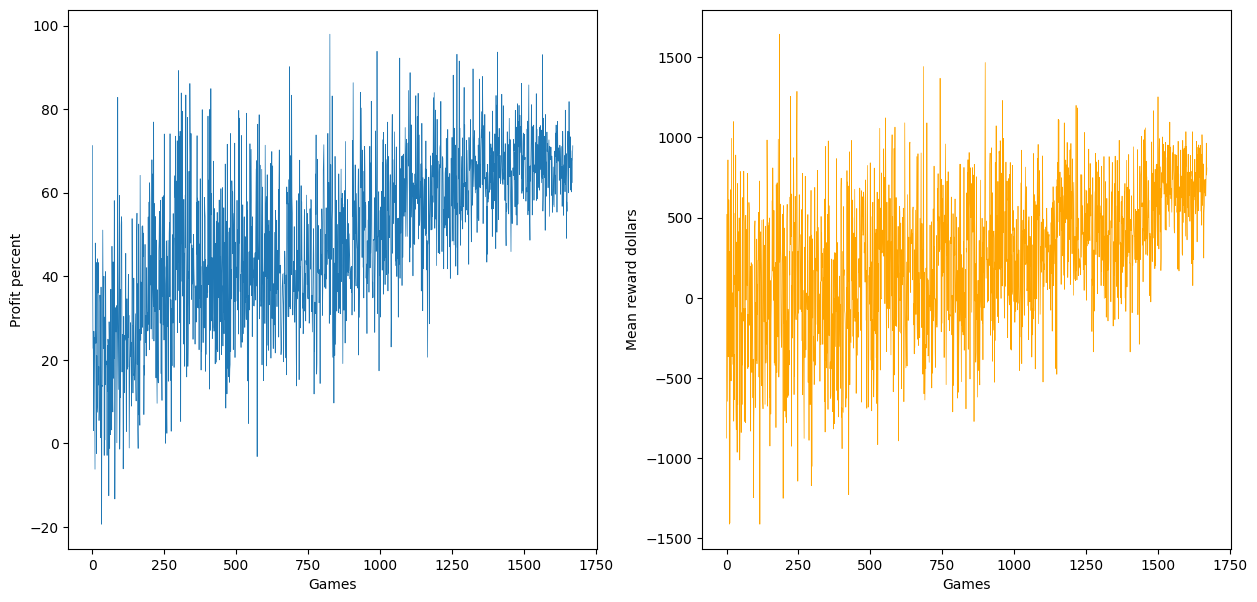

In [125]:
fig, ax=plt.subplots(1,2, figsize=(15,7))
ax[0].plot(np.array(plot_profit)*100,  linewidth=0.5) #profit as a percentage
ax[0].set(xlabel='Games', ylabel='Profit percent')

ax[1].plot(plot_reward, linewidth=0.5, color='orange')
ax[1].set(xlabel='Games', ylabel='Mean reward dollars')

# ax[2].plot(plot_loss, linewidth=0.5, color='royalblue')
# ax[2].set(xlabel='Games', ylabel='Smooth L1 Loss')

In [ ]:
# import seaborn as sns
# import seaborn.timeseries

<ipython-input-84-f708beec6d01>:17: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate("Game"+str(game_i),xy=(0,60), textcoords='offset points', fontsize=30)


Text(0, 60, 'Game1661')

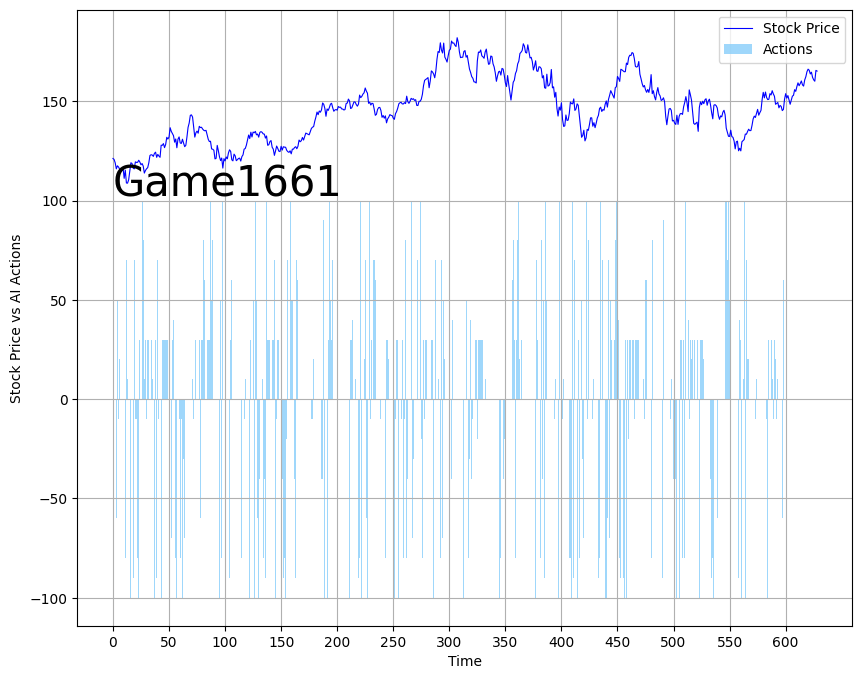

In [84]:
plt.figure(figsize=(10,8))
game_i=1661 #input this to see actions in game i
game_length=stock_price.shape[0]-CONTEXT  #length of stock price
# np.pad(stock_price, (CONTEXT//2,CONTEXT//2),'constant', constant_values=(stock_price[0], stock_price[-1]))
#visualize actions
# plt.plot(np.array(actions[game_length*game_i:game_length*(game_i+1)])/50,linewidth=1, color='tomato', label='Actions')
plt.bar(x=np.arange(0,game_length), height=np.array(actions[game_length*game_i:game_length*(game_i+1)])/50, label='Actions', color='lightskyblue', alpha=0.8)
#plot stock price
plt.plot(stock_price, linewidth=0.8, color="blue", label='Stock Price')

#plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.xticks(np.arange(0,stock_price.shape[0],50))
plt.ylabel("Stock Price vs AI Actions")
plt.xlabel("Time")
plt.grid(True)
plt.legend()
plt.annotate("Game"+str(game_i),xy=(0,60), textcoords='offset points', fontsize=30)